# Extract ISIMIP3b glacier climate change informations:
- creates glacier area-weighted temperature changes (globally or per RGI region) : `../data/temp_ch_ipcc_isimip3b_glacier_regionally.csv`
    - at the moment it gives the "temp. change comparaed to preindustrial times" in the following way: "assumes" that regional/glacier temp. change is also +0.63°C between 1850 and "(1986, 2005)" and then just estimates the average temperature change of the experimental period to that reference period "(1986, 2005)"
    - PROBLEM: how to define the temperature change. Can we do it the same as done for the global temperature change of the IPCC report with the assumption of +0.63°C of temperature change having occured until 1986-2005? Not really, but it is difficult to find a better solution...
        - for the moment we just assume that temperature change is the same regionally, but we have to solve that later ...
        - alternative: just compute the diffference experimental period - (1986, 2005) (because this is the period of interest anyways ... 
- also: analysis of projected climate changes on glacier level

note that `../data/temp_ch_ipcc_isimip3b.csv` is produced in this noteboook: `../isimip3b_postprocessing_analysis/isimip3b_postprocess_to_monthly.ipynb`

- there are some plots showing temperature changes of the different glacier regions for different gcms and scenarios. This will be helpful for the interpretation of the glacier projections later on. Some plots use another definition of "temperature change" and can be updated, if they are interesting, to the IPCC definition 

---

In [1]:
# path to isimip3b files that are available under https://cluster.klima.uni-bremen.de/~lschuster/isimip3b/: this needs to be changed if not run used on the OGGM cluster
path = '/home/www/lschuster/isimip3b/'

In [2]:
import xarray as xr
import numpy as np
from oggm import utils
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import progressbar
from scipy import stats
import seaborn as sns

# Some defaults:
plt.rcParams['figure.figsize'] = (12, 5)  # Default plot size

## some preprocessing to get the glacier gridpoints and their area
- we take the lon/lat gridpoints nearest to the glaciers and create a mask to get later the climate just for those glacier gridpoints. This mask can either be applied to get a global climate change over glacier estimate or a regional estimate 

In [3]:
# updated to new version 2023.2
ds_inv = xr.open_dataset(path+'orog_W5E5v2.0.nc')
ds_inv.coords['lon'] = np.where(ds_inv.lon.values < 0, ds_inv.lon.values + 360,
                                  ds_inv.lon.values)
ds_inv = ds_inv.sortby(ds_inv.lon)
ds_inv.lon.attrs['units'] = 'degrees_onlypositive'

# get the dataset where coordinates of glaciers are stored
frgi = path + 'rgi62_stats.h5'
odf = pd.read_hdf(frgi, index_col=0)
# remove those glaciers with connectivity level not at 0 or 1 in RGI region 05:
# check if all glaciers with connectivity level not in 0 or 1 are in RGI region 05 
assert np.all(odf.loc[(odf.Connect != 0) & (odf.Connect != 1)].O1Region == '05')
# ok then just select those glaciers with the right connectivity level ...
odf = odf.loc[(odf.Connect == 0) | (odf.Connect == 1)]


nx, ny = ds_inv.dims['lon'], ds_inv.dims['lat']
# just make them into 0-> 360 scheme
cenlon_for_bins = np.where(odf['CenLon'] < 0,
                           odf['CenLon']+360, odf['CenLon'])
# Nearest neighbor lookup
lon_bins = np.linspace(ds_inv.lon.data[0] - 0.25, ds_inv.lon.data[-1] + 0.25, nx+1)
# !!! attention W5E5 sorted from 90 to -90 !!!!
lat_bins = np.linspace(ds_inv.lat.data[0] + 0.25, ds_inv.lat.data[-1] - 0.25, ny+1)
# before it was wrongly 
# lon_bins = np.linspace(0, 360, nx), lat_bins = np.linspace(90, -90, ny)
# which created a non-aligned bins, in addition there was one bin missing, creating a slightly 
# larger resolution which after adding up a lot got problematic... 
# at the end it resulted in some glaciers where the nearest grid point was not found

odf['lon_id'] = np.digitize(cenlon_for_bins, lon_bins)-1
odf['lat_id'] = np.digitize(odf['CenLat'], lat_bins)-1

# Use unique grid points as index and compute the area per location
odf['unique_id'] = ['{:03d}_{:03d}'.format(lon, lat) for (lon, lat) in zip(odf['lon_id'], odf['lat_id'])]
mdf = odf.drop_duplicates(subset='unique_id').set_index('unique_id')
mdf['Area'] = odf.groupby('unique_id').sum()['Area']
print('Total number of glaciers: {} and number of W5E5 gridpoints with glaciers in them: {}'.format(len(odf), len(mdf)))

# this is the mask that we need to remove all non-glacierized gridpoints
mask = np.full((ny, nx), np.NaN)
mask[mdf['lat_id'], mdf['lon_id']] = mdf['Area'] # 1
ds_inv['glacier_mask'] = (('lat', 'lon'), np.isfinite(mask))

ds_inv['glacier_area'] = (('lat', 'lon'), mask)
ds_inv['weight_glacier'] = (('lat', 'lon'), mask / np.nansum(mask))

reg = np.full((ny, nx), np.NaN)
reg[mdf['lat_id'], mdf['lon_id']] = mdf['O1Region'].astype(int)
ds_inv['rgi_region'] = (('lat', 'lon'), reg)


# check the distance to the gridpoints-> it should never be larger than 
diff_lon = ds_inv.lon.data[odf.lon_id] - odf.CenLon
# if the distance is 360 -> it is the same as 0,
diff_lon = np.where(np.abs(diff_lon - 360) < 170, diff_lon-360, diff_lon)
odf['ll_dist_to_point'] = ((diff_lon)**2 + (ds_inv.lat.data[odf.lat_id] - odf.CenLat)**2)**0.5
assert odf['ll_dist_to_point'].max() < (0.25**2 + 0.25**2)**0.5

# Normal Weight
weight = np.cos(np.deg2rad(ds_inv.lat.astype(np.float64))).clip(0)
weight =  ds_inv.orog * 0. + weight
ds_inv['weight'] = (('lat', 'lon'), weight.values / weight.sum().values)

Total number of glaciers: 215547 and number of W5E5 gridpoints with glaciers in them: 4695


In [4]:
print('total glacier area: {} km2'.format(np.nansum(mask)) )

total glacier area: 705738.792 km2


In [5]:
# this should be one
print(ds_inv['weight_glacier'].sum())

<xarray.DataArray 'weight_glacier' ()>
array(1.)


In [8]:
import cartopy  # Map projections libary
import cartopy.crs as ccrs  # Projections list
with sns.axes_style("white"), sns.plotting_context('talk'):
    f = plt.figure(figsize=(18, 6))
    ax = plt.axes(projection=ccrs.Robinson())
    ds_inv['glacier_area'].plot(ax=ax, transform=ccrs.PlateCarree(), vmax=500, 
                            cbar_kwargs={'label':'Glacier area (km$^{2}$)'}) 
    ax.coastlines(); ax.gridlines(); ax.set_title('Glacier area per W5E5 grid point (km$^{2}$)');

ModuleNotFoundError: No module named 'cartopy'

In [ ]:
with sns.axes_style("white"), sns.plotting_context('talk'):
    f = plt.figure(figsize=(18, 6))
    ax = plt.axes(projection=ccrs.Robinson())
    ds_inv['rgi_region'].plot(ax=ax, transform=ccrs.PlateCarree(), 
                            cbar_kwargs={'label':'Region'}) 
    ax.coastlines(); ax.gridlines(); ax.set_title('Glacier RGI region');

## ISIMIP3b average Temperature change at glacier locations for each region separately (using IPCC definition)

- PROBLEM: --> regional temperature change definition???

In [9]:
exp_times = [1851, 1901, 1951, 1995, 2021, 2041, 2061, 2081]

# get the right format for the longitudes
ds_inv.coords['lon'] = np.where(ds_inv.lon.values < 0, ds_inv.lon.values + 360,
                                  ds_inv.lon.values)
ds_inv = ds_inv.sortby(ds_inv.lon)
ds_inv.lon.attrs['units'] = 'degrees_onlypositive'

gcms = ['gfdl-esm4', 'ipsl-cm6a-lr', 'mpi-esm1-2-hr', 'mri-esm2-0', 'ukesm1-0-ll' ]
scenarios = ['ssp126', 'ssp370', 'ssp585']

# weighted average over latitudes
weight_regions = {}
weight_regions['global'] = ds_inv.weight.sum(dim='lon')

# this is glacier area weighted
weight_regions['global_glacier']  = ds_inv.weight_glacier.sum(dim='lon')
for rgi_reg in range(1, 20):
    weight_reg = ds_inv.weight_glacier.where(ds_inv.rgi_region == rgi_reg)
    weight_reg = weight_reg / weight_reg.sum()
    weight_regions[f'RGI{rgi_reg:02g}_glacier'] = weight_reg.sum(dim='lon')
regions = weight_regions.keys()

In [11]:
run = False
if run:
    pd_global_temp_exp = pd.DataFrame(columns=['gcm', 'period_scenario', 'temp_ch_ipcc'])

    typ = 'tasAdjust'
    temp_change_l = []
    period_scenario_l =[]
    gcm_l = []
    region_l = []
    for gcm in gcms:
        if gcm in ['gfdl-esm4', 'ipsl-cm6a-lr', 'mpi-esm1-2-hr', 'mri-esm2-0']:
            ensemble = 'r1i1p1f1'
        elif gcm == 'ukesm1-0-ll':
            ensemble = 'r1i1p1f2'


        folder_output = 'isimip3b_{}_monthly'.format(typ)
            
        for region in regions:
            ybegin = 1850
            yend = 2014
            scenario = 'hist'
            path_output = path + '{}/{}_{}_w5e5_{}_{}_global_monthly_{}_{}.nc'.format(folder_output, gcm, ensemble,
                                                                                      'historical', typ, ybegin, yend)
            with xr.open_dataset(path_output) as ds_tas_yearly:
                ds_tas_yearly = ds_tas_yearly.groupby('time.year').mean().load()
            
            weight_sel = weight_regions[region]
            np.testing.assert_allclose(weight_sel.sum(),1)
            global_tas_mean = (ds_tas_yearly.tasAdjust.mean(dim='lon') * weight_sel).sum(dim='lat') - 273.15  # from K to °C
            ref_period_avg = global_tas_mean.sel(year = slice(str(1986),str(2005))).mean()

            for exp_time in exp_times[:4]:
                exp_period_avg = global_tas_mean.sel(year=slice(str(exp_time), str(exp_time+19))).mean(dim='year')
                gcm_l.append(gcm)
                period_scenario_l.append(f'{str(exp_time)}-{str(exp_time+19)}_{scenario}')
                temp_change_l.append((exp_period_avg-ref_period_avg + 0.63).values)
                region_l.append(region)

            for scenario in scenarios:
                ybegin = 2015
                yend = 2100
                path_output_f = path + '{}/{}_{}_w5e5_{}_{}_global_monthly_{}_{}.nc'.format(folder_output, gcm, ensemble, scenario,
                                                                                                typ, ybegin, yend)

                with xr.open_dataset(path_output_f) as ds_tas_yearly_f:
                    ds_tas_yearly_f = ds_tas_yearly_f.groupby('time.year').mean().load()
                    global_tas_mean_f = (ds_tas_yearly_f.tasAdjust.mean(dim='lon') * weight_sel).sum(dim='lat') - 273.15  # from K to °C

                for exp_time in exp_times[4:]:
                    exp_period_avg = global_tas_mean_f.sel(year=slice(str(exp_time), str(exp_time+19))).mean(dim='year')
                    gcm_l.append(gcm)
                    period_scenario_l.append(f'{str(exp_time)}-{str(exp_time+19)}_{scenario}')
                    temp_change_l.append((exp_period_avg-ref_period_avg + 0.63).values)
                    region_l.append(region)
            ds_tas_yearly_f.close()
        ds_tas_yearly.close()
        print('t')
    pd_global_temp_exp['gcm'] = gcm_l
    pd_global_temp_exp['period_scenario'] = period_scenario_l
    pd_global_temp_exp[f'temp_ch_ipcc'] = np.array(temp_change_l)
    pd_global_temp_exp['region'] = region_l
    pd_global_temp_exp.to_csv('../data/temp_ch_ipcc_isimip3b_glacier_regionally.csv')
else:
    pd_global_temp_exp = pd.read_csv('../data/temp_ch_ipcc_isimip3b_glacier_regionally.csv', index_col=[0])
    
pd_global_true_temp_exp = pd.read_csv('../data/temp_ch_ipcc_isimip3b.csv', index_col = 0)
_glob = pd_global_temp_exp.loc[pd_global_temp_exp.region == 'global']
np.testing.assert_allclose(_glob['temp_ch_ipcc'].values,pd_global_true_temp_exp['temp_ch_ipcc'].values)
assert np.all(_glob['gcm'].values==pd_global_true_temp_exp['gcm'].values)
assert np.all(_glob['period_scenario'].values==pd_global_true_temp_exp['period_scenario'].values)
pd_global_temp_exp

gcm   period_scenario  temp_ch_ipcc         region
0       gfdl-esm4    1851-1870_hist      0.171409         global
1       gfdl-esm4    1901-1920_hist      0.418289         global
2       gfdl-esm4    1951-1970_hist      0.332281         global
3       gfdl-esm4    1995-2014_hist      0.841467         global
4       gfdl-esm4  2021-2040_ssp126      1.433792         global
...           ...               ...           ...            ...
1675  ukesm1-0-ll  2081-2100_ssp370      5.620589  RGI19_glacier
1676  ukesm1-0-ll  2021-2040_ssp585      1.904378  RGI19_glacier
1677  ukesm1-0-ll  2041-2060_ssp585      3.025883  RGI19_glacier
1678  ukesm1-0-ll  2061-2080_ssp585      4.639923  RGI19_glacier
1679  ukesm1-0-ll  2081-2100_ssp585      6.683839  RGI19_glacier

[1680 rows x 4 columns]

***Future experiments***

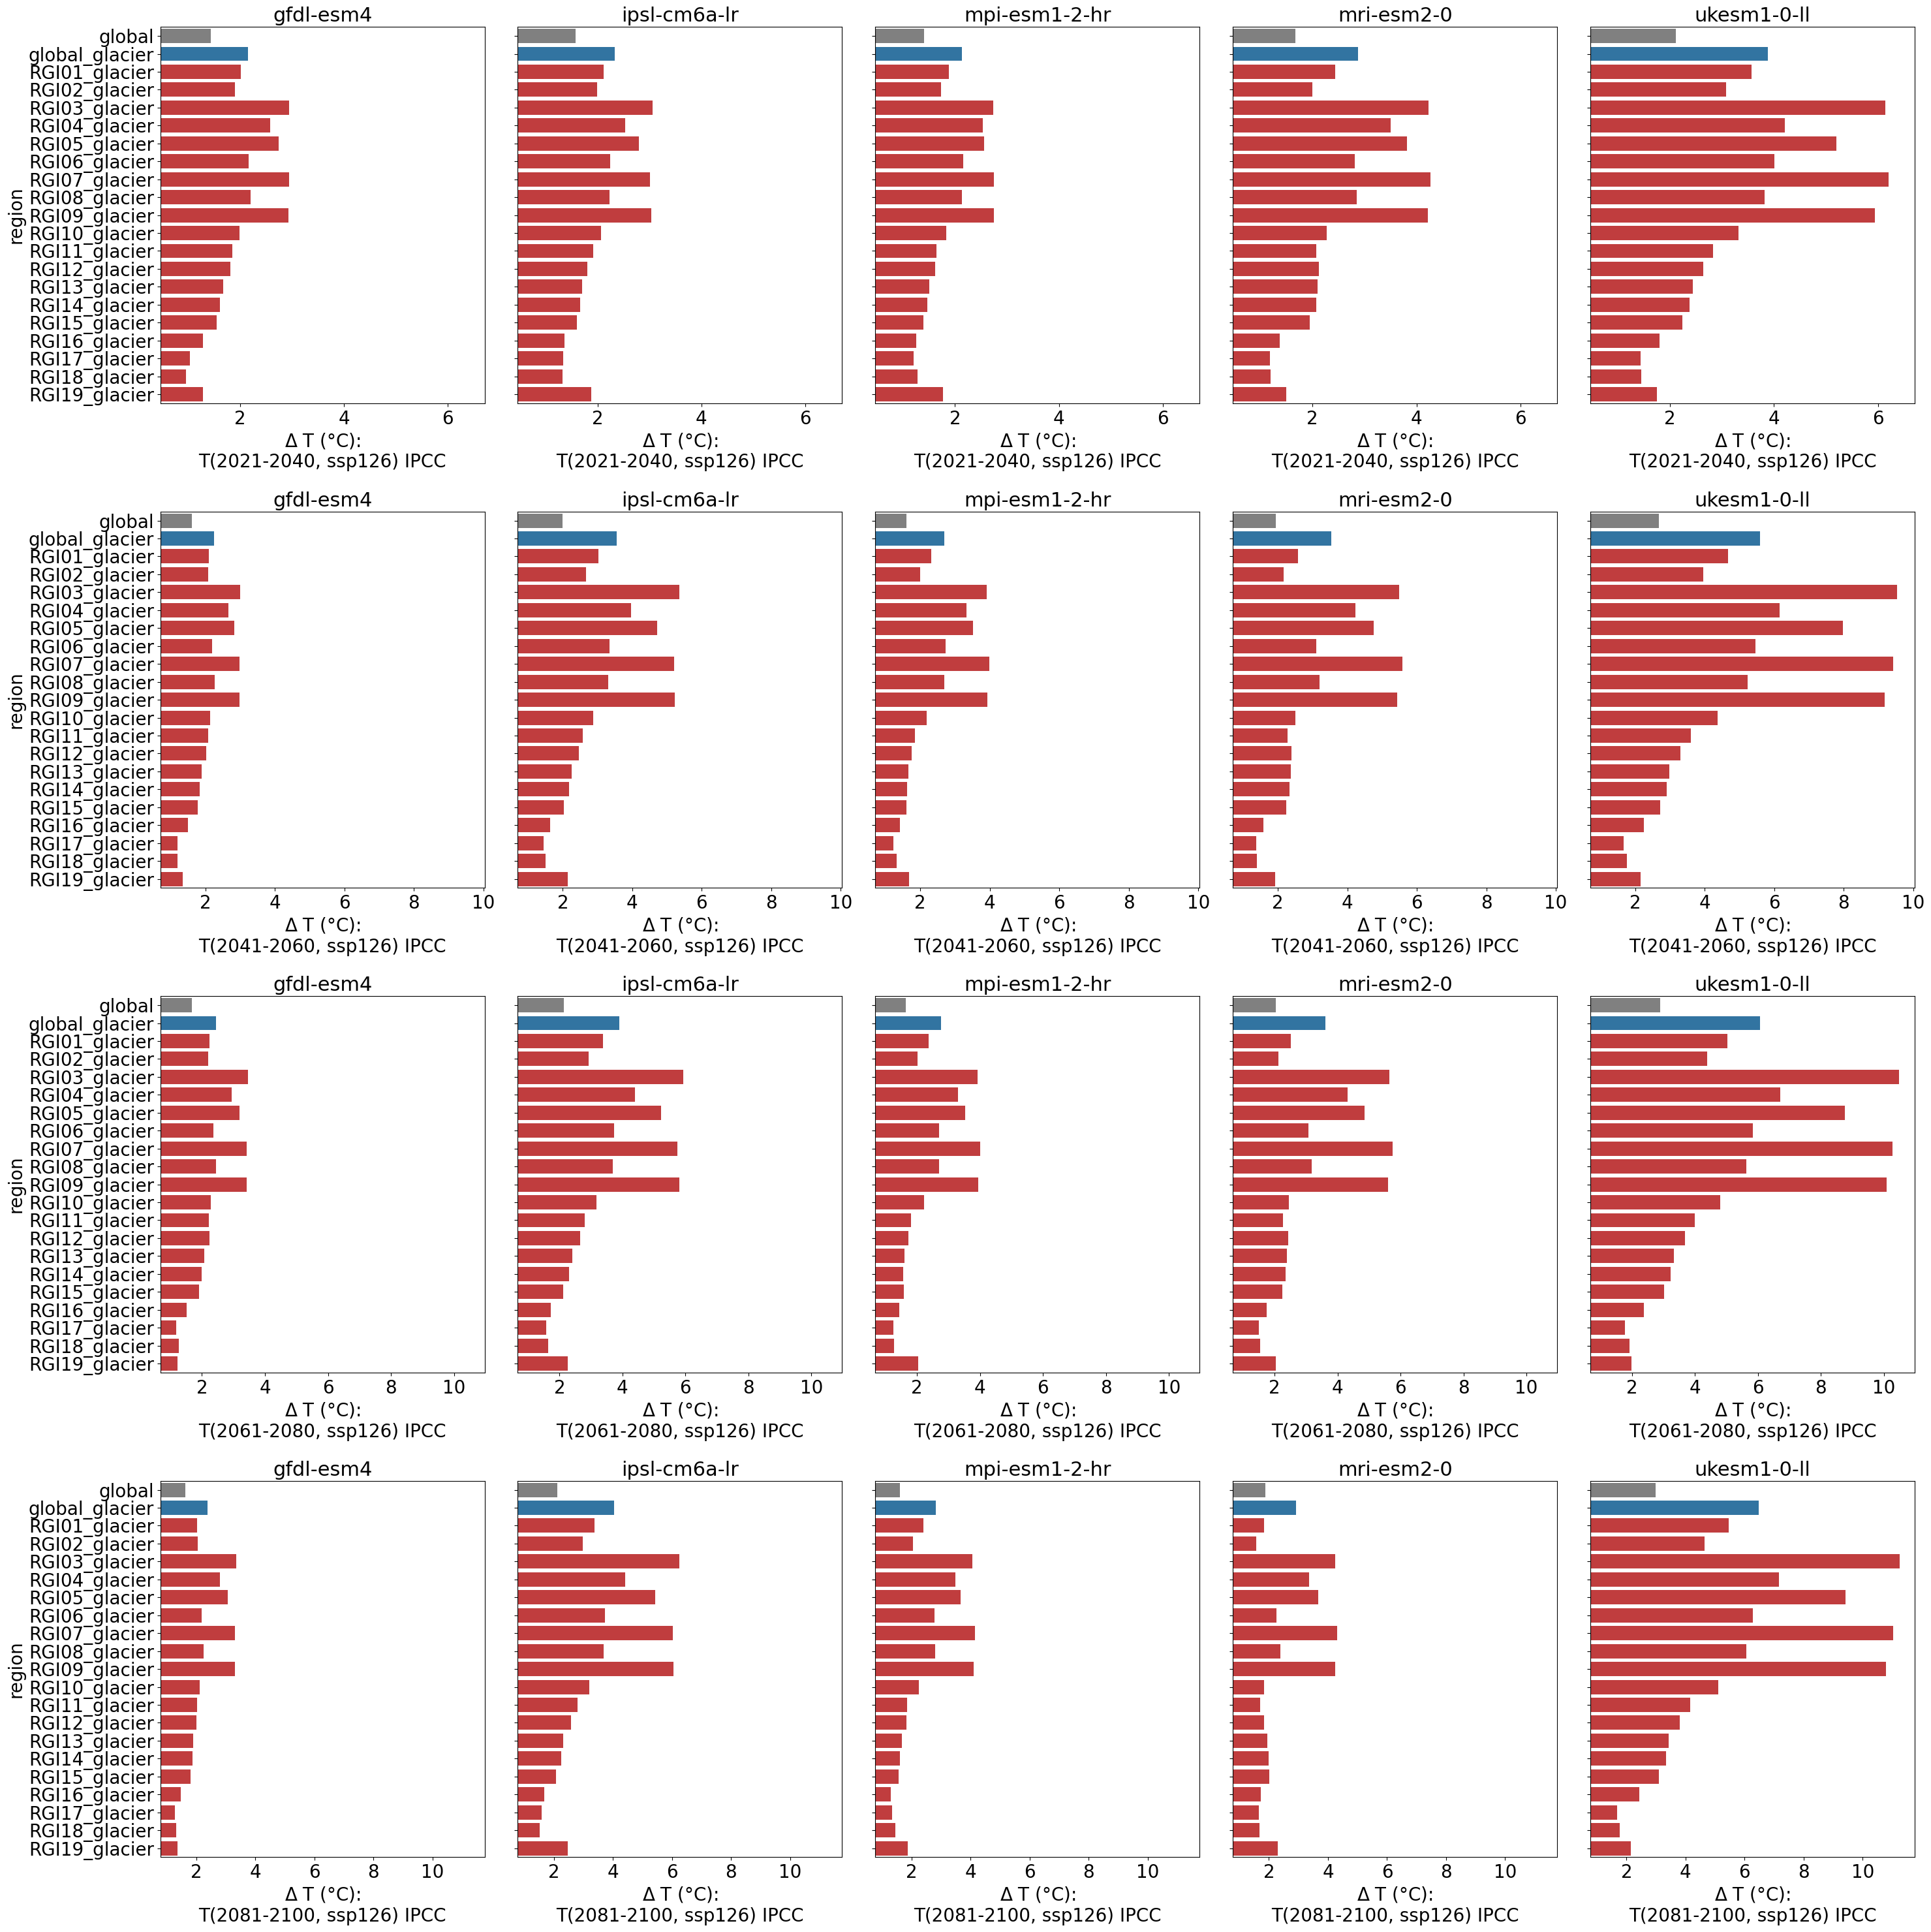

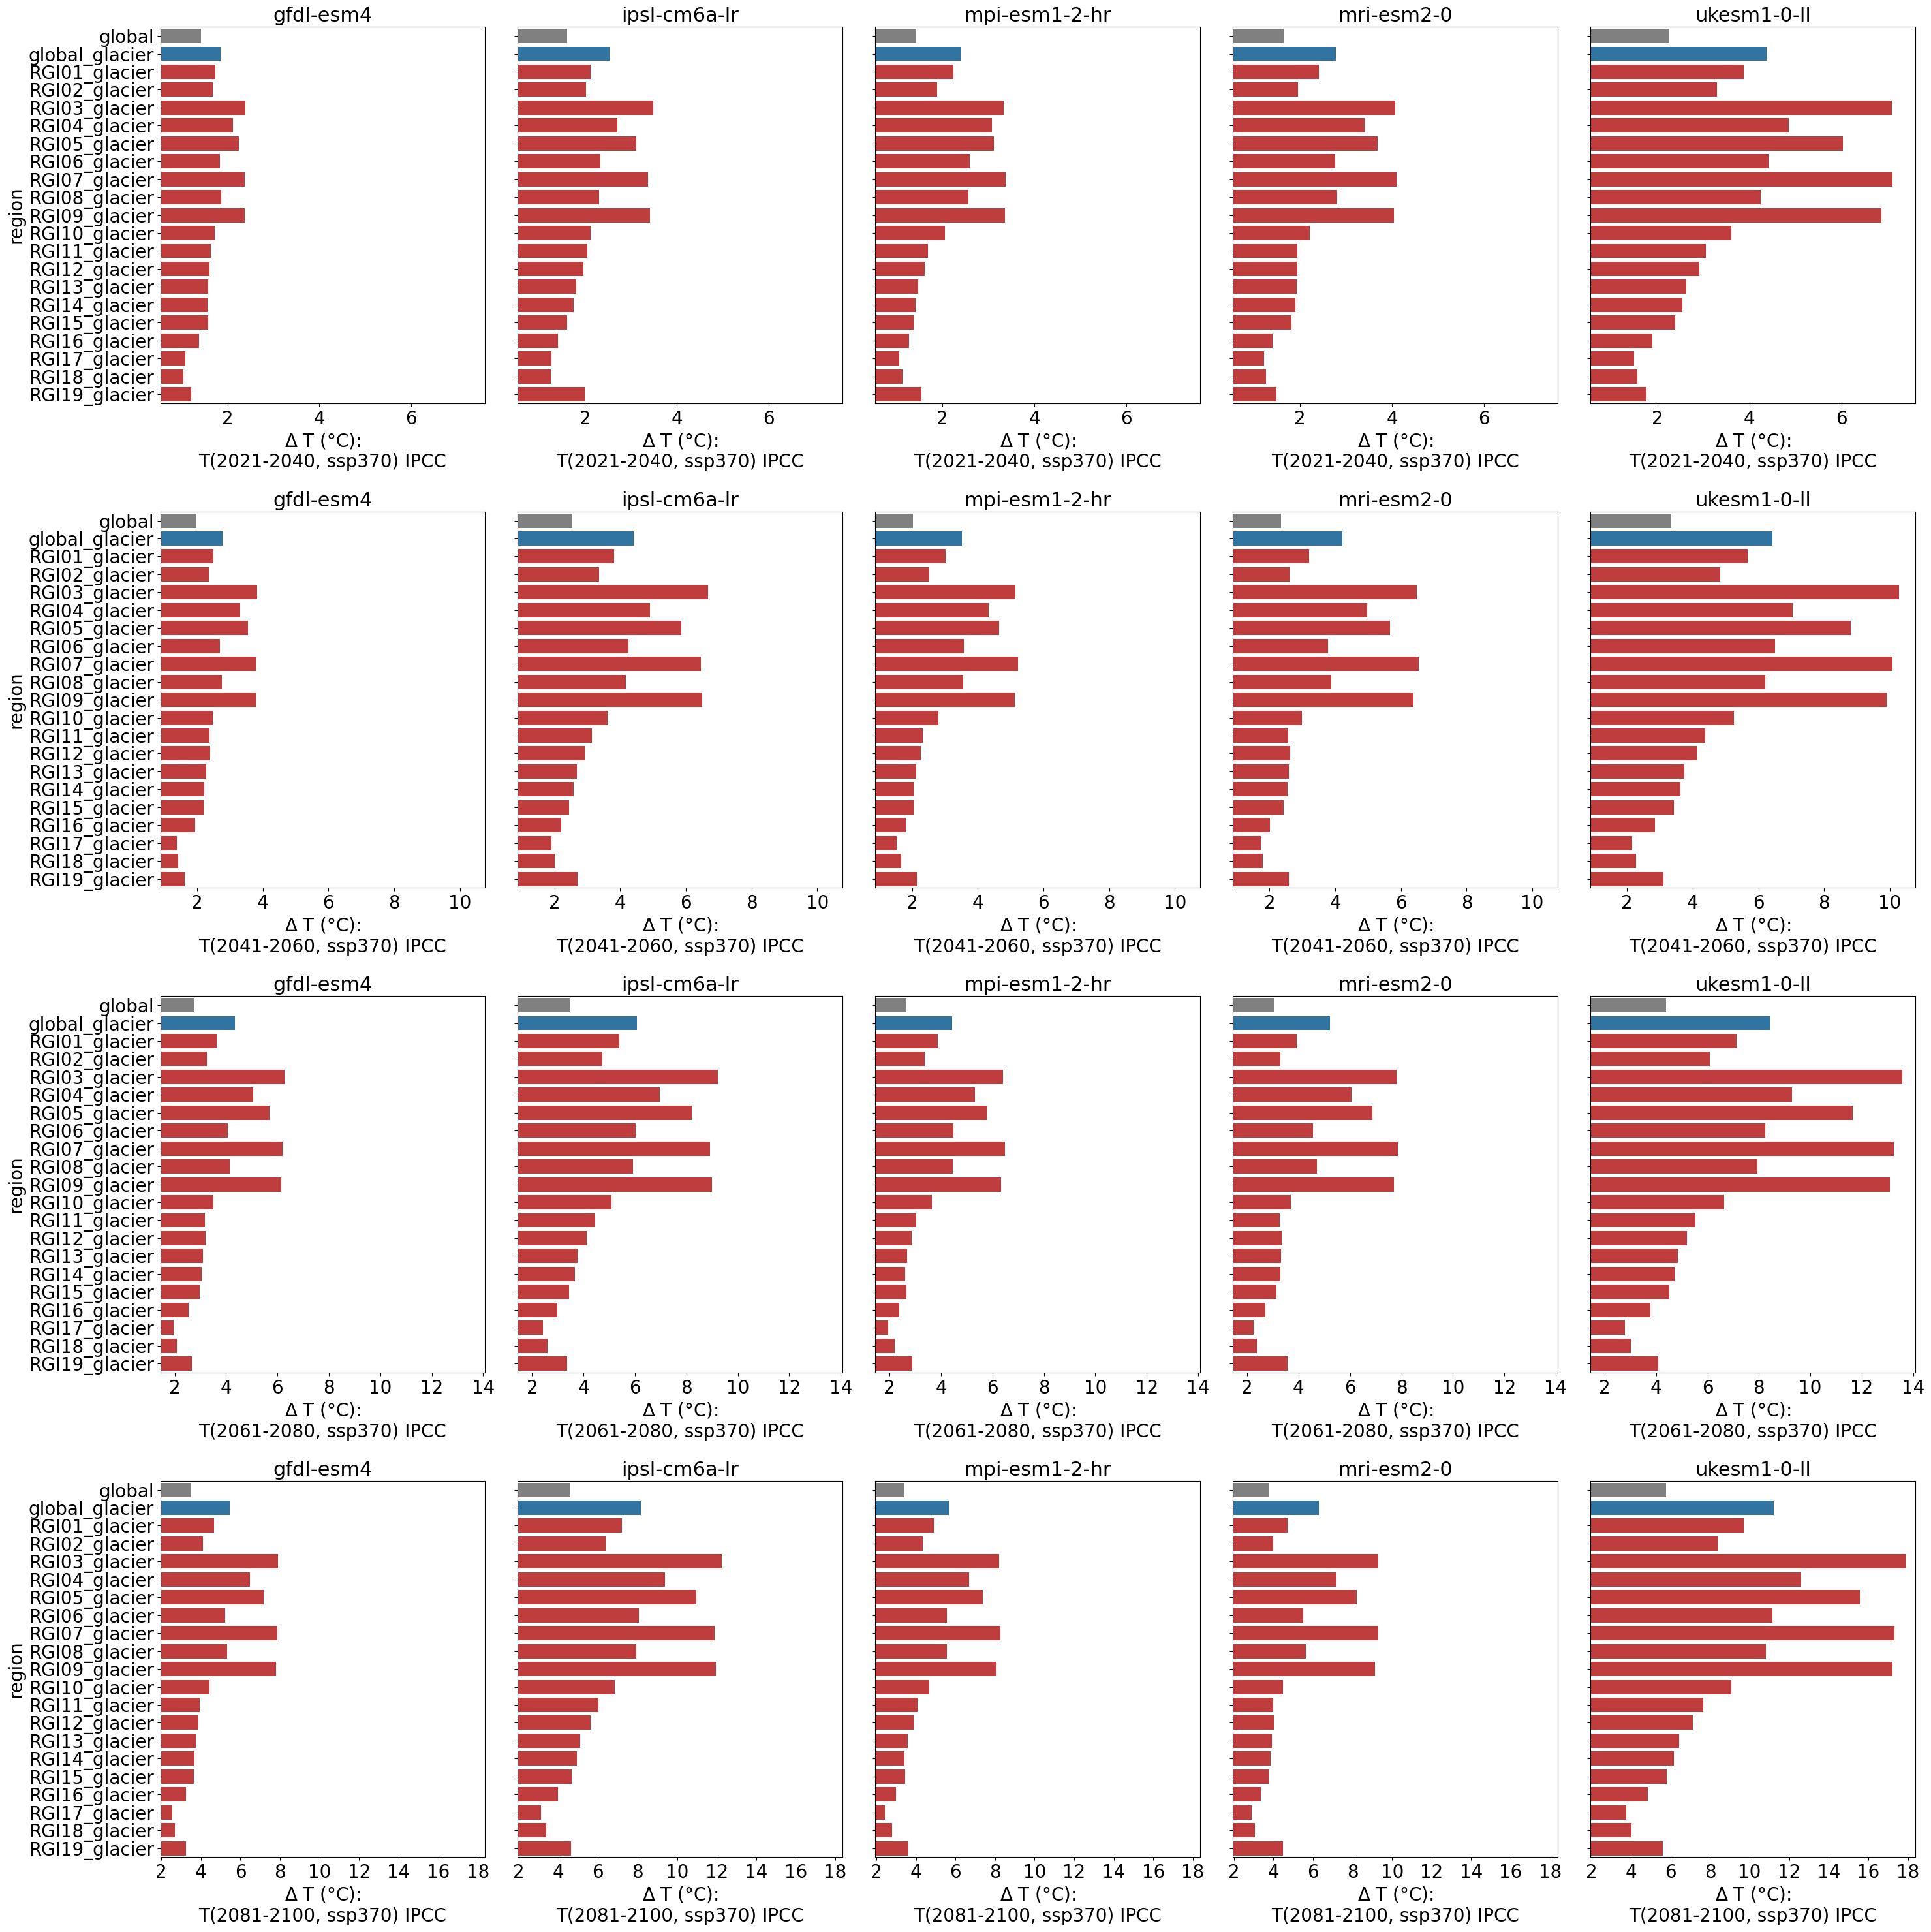

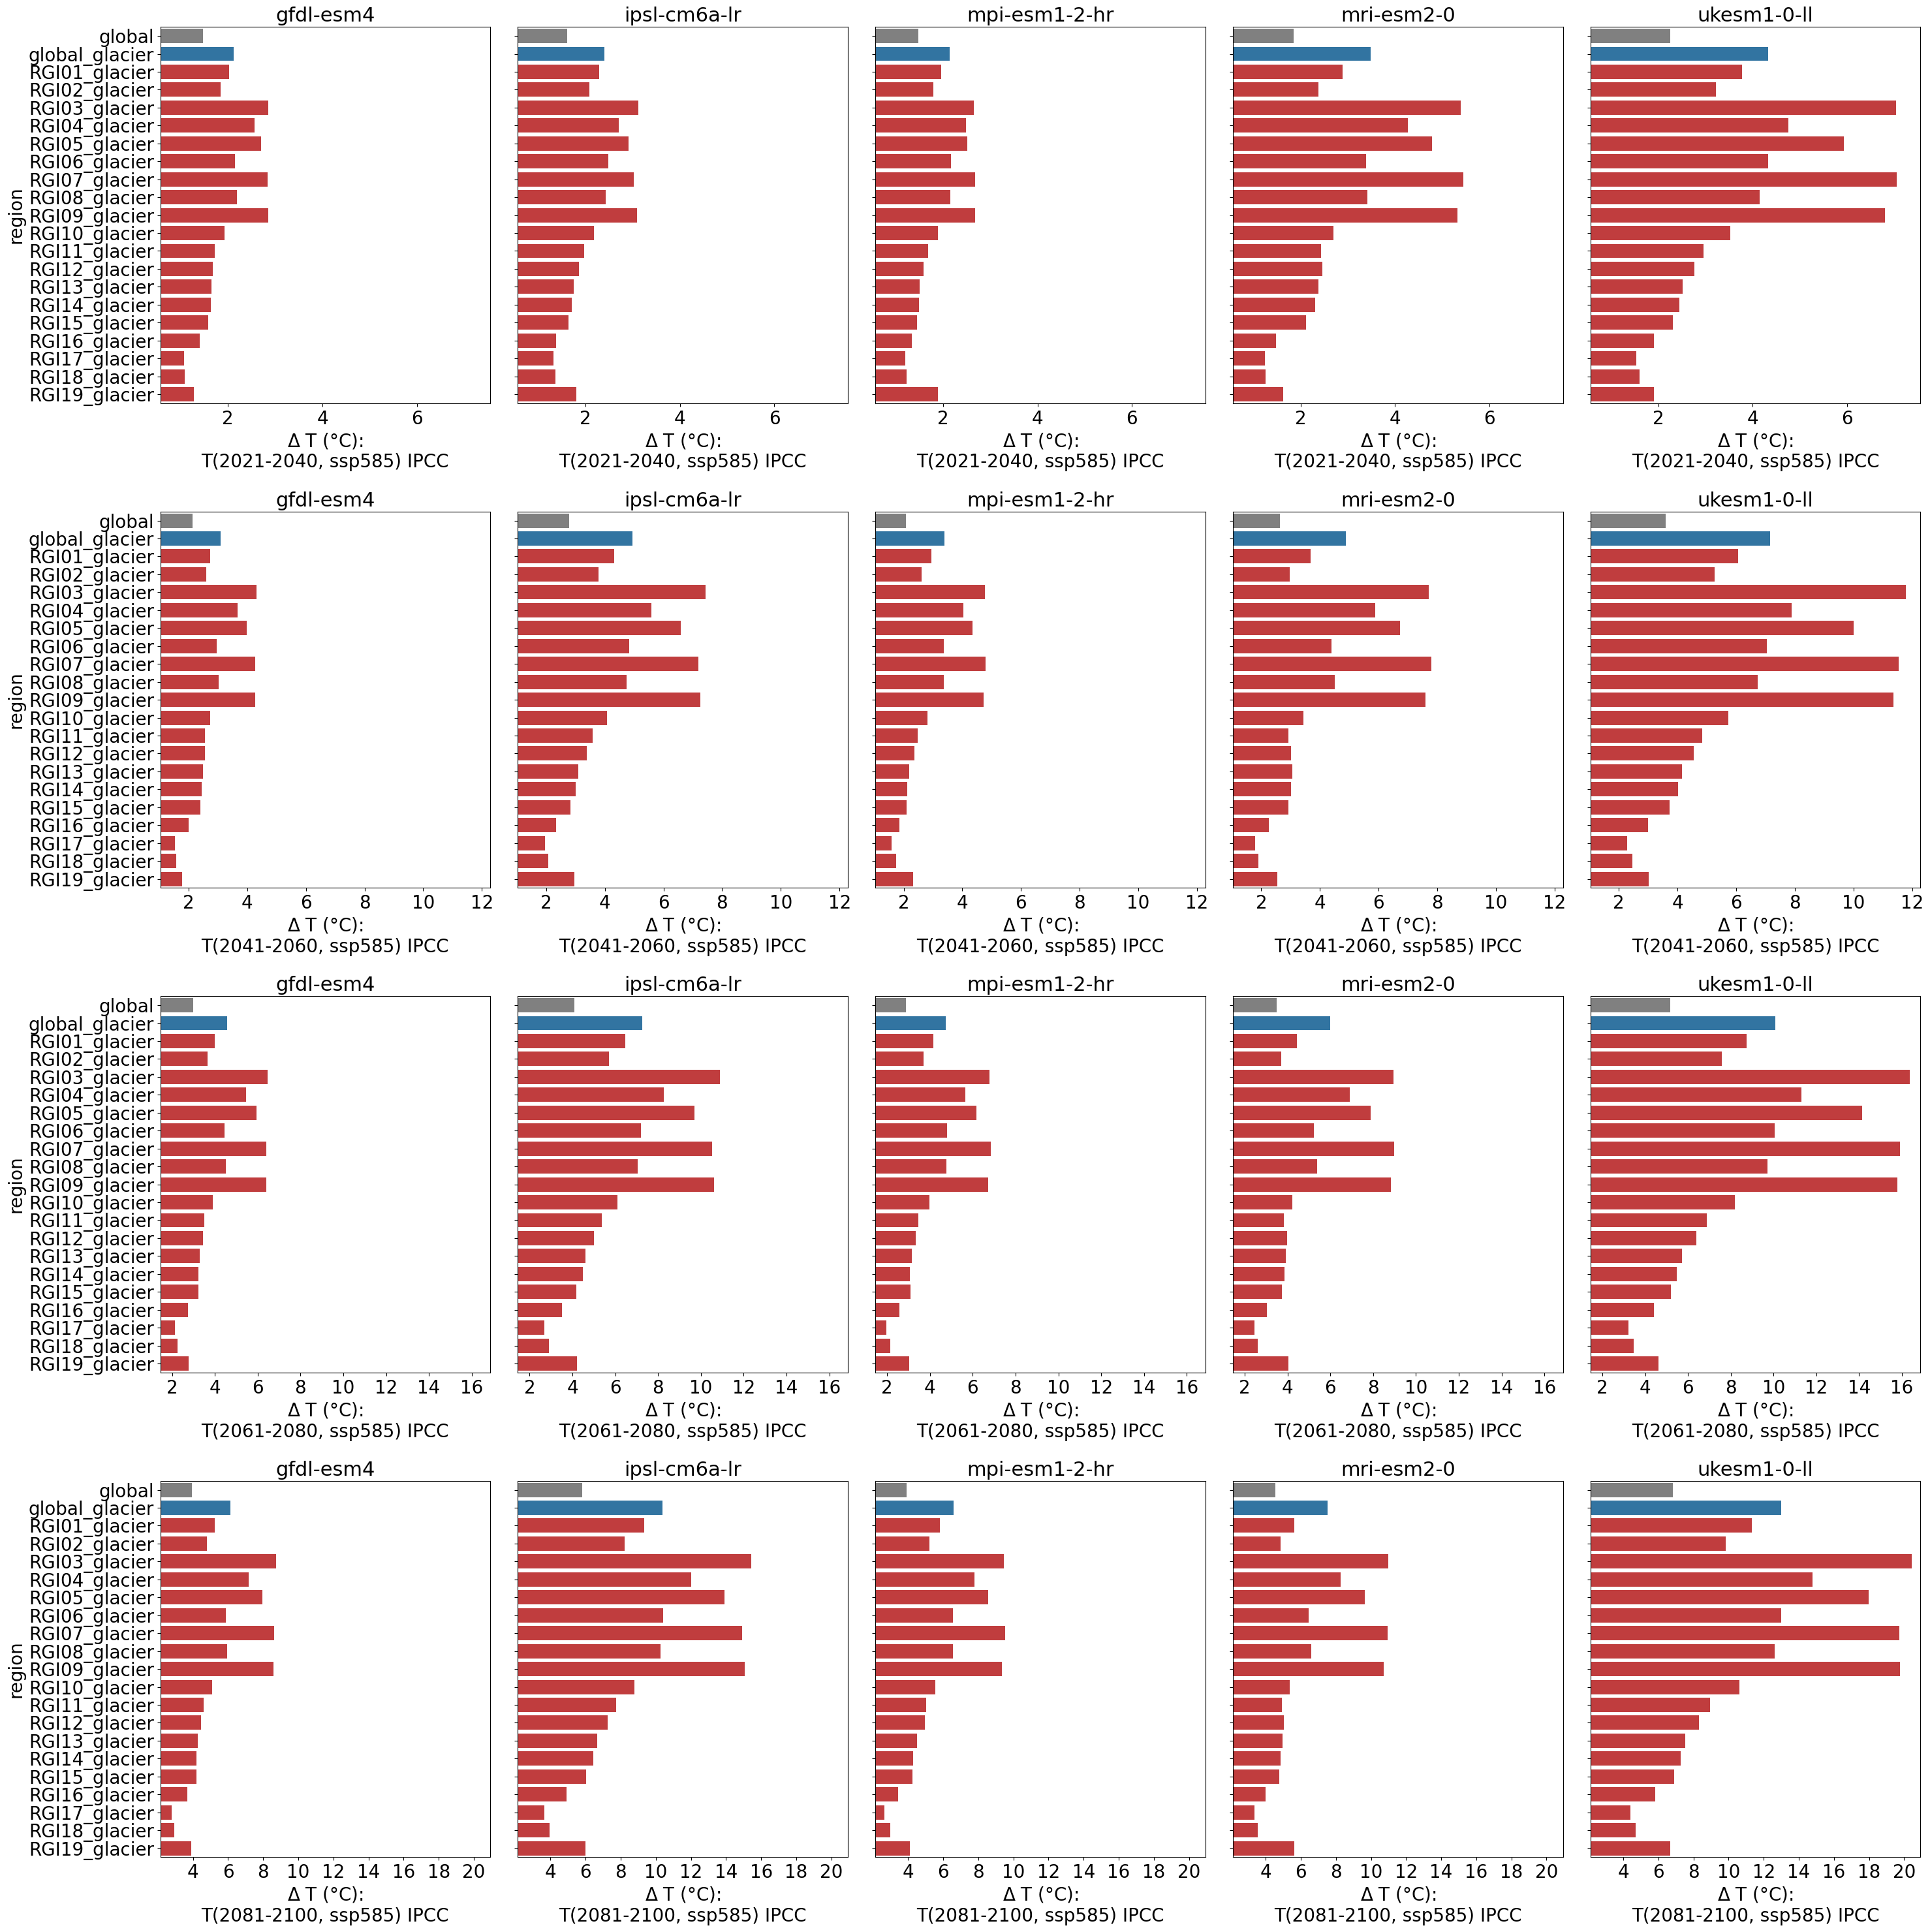

In [12]:
plt.rcParams.update({'font.size': 20})

for scenario in scenarios:
    fig,axss = plt.subplots(4,5, figsize=(30, 30),sharey=True)
    j = 0
    for exp_time in exp_times[4:]:
        axs = axss[j]
        period = f'{exp_time}-{exp_time+19}'
        pd_sel_ps = pd_global_temp_exp.loc[(pd_global_temp_exp.period_scenario==f'{period}_{scenario}')]
        jj = 0
        for gcm in gcms:
            ax = axs[jj]
            
            pd_sel = pd_sel_ps.loc[(pd_global_temp_exp.gcm==gcm)]
            pd_sel.index = pd_sel.region
            
            sns.barplot(pd_sel, y='region', x='temp_ch_ipcc',
                        palette=['grey', 'C0']+['C3'] * 19, ax=ax)
            ax.set_xlabel('$\Delta$ T (°C):\nT({}-{}, {}) IPCC'.format(exp_time, exp_time+19, scenario), fontsize=20)
            if gcm==gcms[0]:
                ax.set_ylabel('region')
            else:
                ax.set_ylabel('')
            ax.set_xticks(np.arange(-14,22,2))
            maxi = pd_sel_ps['temp_ch_ipcc'].max() +0.5
            mini = pd_sel_ps['temp_ch_ipcc'].min() -0.5
            ax.set_xlim(mini, maxi)
            ax.set_title('{}'.format(gcm), fontsize=22)
            ax.tick_params(axis='y',which='minor',bottom=False)
            jj+=1
        j+=1
    plt.tight_layout()
    plt.savefig(f'figures/0_temp_change_global_regional_glacier_{scenario}.png')

***Past experiments***

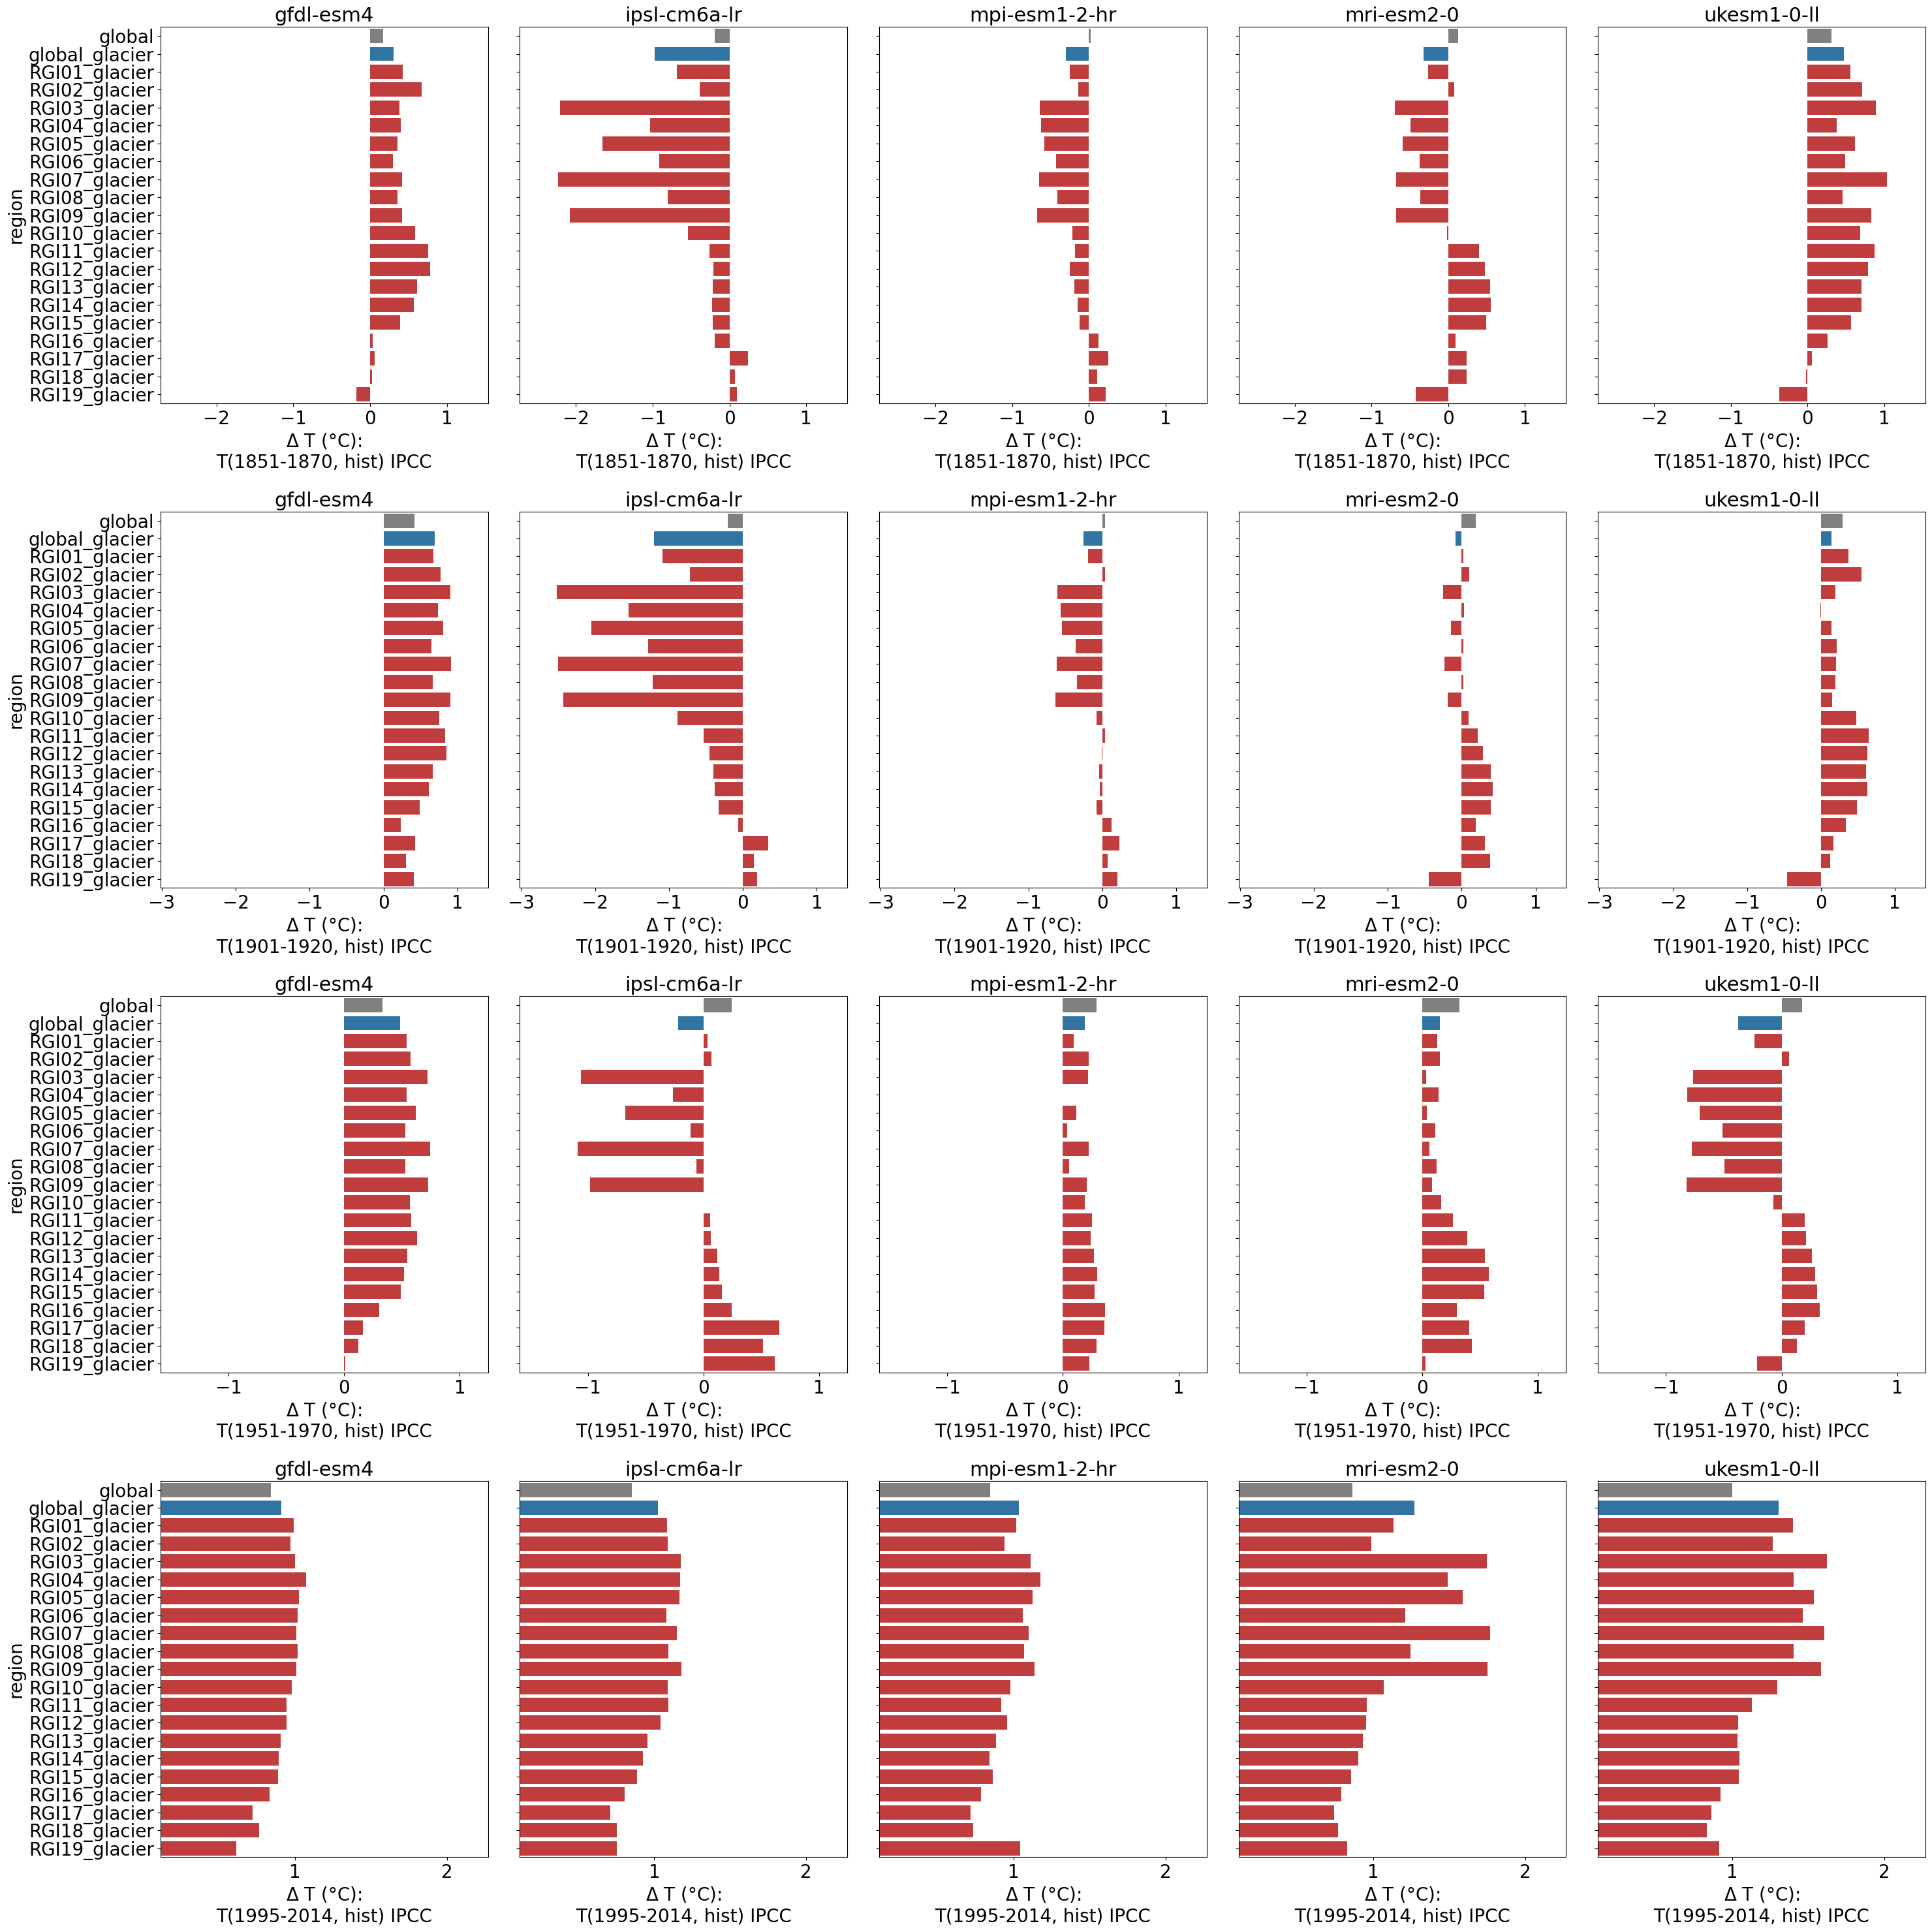

In [13]:
plt.rcParams.update({'font.size': 20})

scenario = 'hist'
fig,axss = plt.subplots(4,5, figsize=(30, 30),sharey=True)
j = 0
for exp_time in exp_times[:4]:
    axs = axss[j]
    period = f'{exp_time}-{exp_time+19}'
    pd_sel_ps = pd_global_temp_exp.loc[(pd_global_temp_exp.period_scenario==f'{period}_{scenario}')]
    jj = 0
    for gcm in gcms:
        ax = axs[jj]

        pd_sel = pd_sel_ps.loc[(pd_global_temp_exp.gcm==gcm)]
        pd_sel.index = pd_sel.region

        sns.barplot(pd_sel, y='region', x='temp_ch_ipcc',
                    palette=['grey', 'C0']+['C3'] * 19, ax=ax)
        ax.set_xlabel('$\Delta$ T (°C):\nT({}-{}, {}) IPCC'.format(exp_time, exp_time+19, scenario), fontsize=20)
        if gcm==gcms[0]:
            ax.set_ylabel('region')
        else:
            ax.set_ylabel('')
        ax.set_xticks(np.arange(-14,22,1))
        maxi = pd_sel_ps['temp_ch_ipcc'].max() +0.5
        mini = pd_sel_ps['temp_ch_ipcc'].min() -0.5
        ax.set_xlim(mini, maxi)
        ax.set_title('{}'.format(gcm), fontsize=22)
        ax.tick_params(axis='y',which='minor',bottom=False)
        jj+=1
    j+=1
plt.tight_layout()
plt.savefig(f'figures/0_temp_change_global_regional_glacier_{scenario}.png')

- There are more complex analysis of that further below, but these use another definition of temperature change. If they get interesting again, I can recreate these plot with the (new) IPCC definition.

In [ ]:
old = False
if old:
    for scenario in scenarios:
        plt.figure(figsize=(30, 25))
        j = 0
        for exp_time in exp_times[4:]:
            period = f'{exp_time}-{exp_time+19}'
            pd_sel_ps = pd_global_temp_exp.loc[(pd_global_temp_exp.period_scenario==f'{period}_{scenario}')]
            for gcm in gcms:
                plt.subplot(4,5,j+1)
                ax = plt.gca()

                pd_sel = pd_sel_ps.loc[(pd_global_temp_exp.gcm==gcm)]
                pd_sel.index = pd_sel.region


                pd_sel.plot(ax=ax, kind='bar',
                            rot=45, color=['grey', 'C0']+['C3'] * 19,legend=False);


                # for every GCM the same ... 
                #plt.plot(pd_sel.groupby('rgi_reg').median().index,
                #         pd_sel.groupby('rgi_reg').median()[var].values,
                #         marker='_', ls = '',
                #         color='grey', markersize=15, markeredgewidth=3,
                #         label='median difference over GCMs for that region')

                if gcm==gcms[0]:
                    ax.set_ylabel('$\Delta$ T (°C):\nT({}-{}, {}) IPCC'.format(exp_time, exp_time+19, scenario), fontsize=20)
                ax.set_yticks(np.arange(-14,22,1))
                maxi = pd_sel_ps['temp_ch_ipcc'].max() +0.5
                mini = pd_sel_ps['temp_ch_ipcc'].min() -0.5
                ax.set_ylim(mini, maxi)
                plt.title('{}'.format(gcm), fontsize=22)
                ax.tick_params(axis='x',which='minor',bottom=False)
                j+=1
        plt.tight_layout()

## Plots about global climate time series of only glacier regions (weighted by glacier area)

**first get the annual global mean time series for each scenario and ensemble**

In [14]:
ds_inv.coords['lon'] = np.where(ds_inv.lon.values > 180, ds_inv.lon.values - 360,
                                  ds_inv.lon.values)
ds_inv = ds_inv.sortby(ds_inv.lon)
ds_inv.lon.attrs['units'] = 'degrees_neg_pos'

dict_global_pr_mean_g= {}
dict_global_tas_mean_g= {}
dict_global_tas_daily_std_g = {}

gcms = ['gfdl-esm4', 'ipsl-cm6a-lr', 'mpi-esm1-2-hr', 'mri-esm2-0', 'ukesm1-0-ll' ]
scenarios = ['historical', 'ssp126', 'ssp370', 'ssp585']

for gcm in gcms:
    if gcm in ['gfdl-esm4', 'ipsl-cm6a-lr', 'mpi-esm1-2-hr', 'mri-esm2-0']:
        ensemble = 'r1i1p1f1'
    elif gcm == 'ukesm1-0-ll':
        ensemble = 'r1i1p1f2'
    for scenario in scenarios:
        print(gcm, ensemble, scenario)

        if scenario == 'historical':
            ybegin = 1850
            yend = 2014
        else:
            ybegin = 2015
            yend = 2100    

        typ = 'prAdjust'
        folder_output = 'isimip3b_{}_monthly'.format(typ)
        path_output_pr = '{}/{}_{}_w5e5_{}_{}_global_monthly_{}_{}.nc'.format(folder_output, gcm, ensemble, scenario, typ, ybegin, yend)
        typ = 'tasAdjust'
        folder_output = 'isimip3b_{}_monthly'.format(typ)
        path_output_tas = '{}/{}_{}_w5e5_{}_{}_global_monthly_{}_{}.nc'.format(folder_output, gcm, ensemble, scenario, typ, ybegin, yend)
        folder_output_std = 'isimip3b_{}_std_monthly'.format(typ)
        path_output_tas_std = '{}/{}_{}_w5e5_{}_{}_std_global_monthly_{}_{}.nc'.format(folder_output_std, gcm, ensemble, scenario, typ, ybegin, yend)

        # get the global means for every month:
        with xr.open_dataset(path+path_output_pr) as ds_pr_monthly:
            global_pr_mean_g = (ds_pr_monthly.prAdjust.load() * ds_inv.weight_glacier).sum(dim=['lon','lat']).resample(time='1Y').mean() *60*60*24  # from kg /m2 /s to  mm/day
        

        with xr.open_dataset(path+path_output_tas) as ds_tas_monthly:
            global_tas_mean_g = (ds_tas_monthly.tasAdjust.load()* ds_inv.weight_glacier).sum(dim=['lon','lat']).resample(time='1Y').mean() - 273.15  # from K to °C

        
        with xr.open_dataset(path+path_output_tas_std) as ds_tas_daily_std:
            #ds_tas_daily_var = np.square(ds_tas_daily_std.tasAdjust_std).load()
            global_tas_daily_std_g = (ds_tas_daily_std.tasAdjust_std.load()* ds_inv.weight_glacier).sum(dim=['lat','lon']).resample(time='1Y').mean()


        # !!! can not simply sum up standard deviations!!# 
        #! I am not totally sure about the daily standard deviation stuff ... 
        # I think we can NOT assume independence inbetween the standard deviations of different grid points ... 
        # it would be better to take the real daily values and get than global daily values by the weighting and then compute the standard deviations from the global daily Temp. values to check that !!!
        #global_tas_daily_std_g = np.sqrt(np.square(ds_tas_daily_std.tasAdjust_std* ds_inv.weight_glacier).sum(dim=['lon','lat'])).resample(time='1Y').mean() #- 273.15  # from K to °C
        #(ds_tas_daily_std.tasAdjust_std.mean(dim='lon') * ds_inv.weight_glacier).sum(dim='lat').resample(time='1Y').mean() #- 273.15  # from K to °C

        #global_tas_daily_std_g = np.sqrt(((ds_tas_daily_var* ds_inv.weight_glacier).sum(dim=['lon','lat'])).resample(time='1Y').mean()) #- 273.15  # from K to °C

        print('global glacier precipitation mean: {} mm/day \nglobal glacier temperature mean: {} °C'.format(global_pr_mean_g.mean().values.round(2), global_tas_mean_g.mean().values.round(2)))

        dict_global_pr_mean_g['{}_{}'.format(gcm, scenario)] = global_pr_mean_g
        dict_global_tas_mean_g['{}_{}'.format(gcm, scenario)] = global_tas_mean_g
        dict_global_tas_daily_std_g['{}_{}'.format(gcm, scenario)] = global_tas_daily_std_g


gfdl-esm4 r1i1p1f1 historical
global glacier precipitation mean: 1.99 mm/day 
global glacier temperature mean: -9.71 °C
gfdl-esm4 r1i1p1f1 ssp126
global glacier precipitation mean: 2.11 mm/day 
global glacier temperature mean: -7.99 °C
gfdl-esm4 r1i1p1f1 ssp370
global glacier precipitation mean: 2.16 mm/day 
global glacier temperature mean: -6.78 °C
gfdl-esm4 r1i1p1f1 ssp585
global glacier precipitation mean: 2.2 mm/day 
global glacier temperature mean: -6.48 °C
ipsl-cm6a-lr r1i1p1f1 historical
global glacier precipitation mean: 1.93 mm/day 
global glacier temperature mean: -10.6 °C
ipsl-cm6a-lr r1i1p1f1 ssp126
global glacier precipitation mean: 2.13 mm/day 
global glacier temperature mean: -7.18 °C
ipsl-cm6a-lr r1i1p1f1 ssp370
global glacier precipitation mean: 2.25 mm/day 
global glacier temperature mean: -5.6 °C
ipsl-cm6a-lr r1i1p1f1 ssp585
global glacier precipitation mean: 2.32 mm/day 
global glacier temperature mean: -4.73 °C
mpi-esm1-2-hr r1i1p1f1 historical
global glacier preci

### just some plots

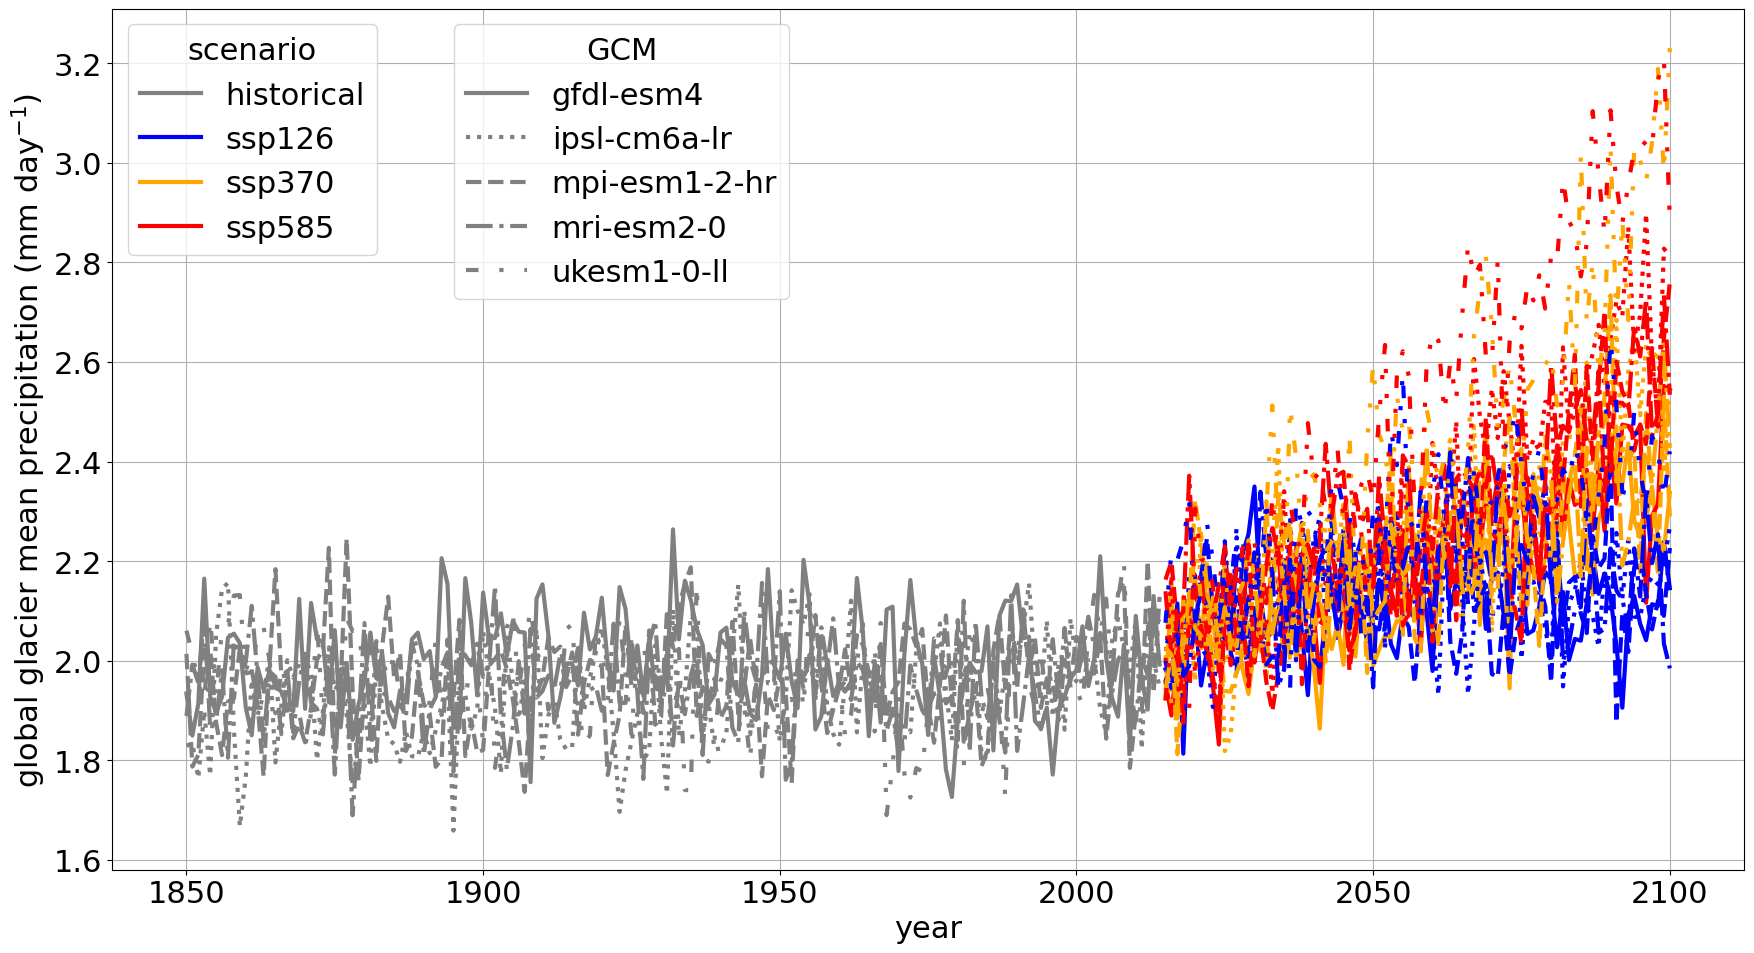

In [15]:
plt.rcParams.update({'font.size': 22})
#fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(18,28))
plt.figure(figsize=(18,10))
lss = ['-',':', '--', '-.', (0, (3, 5, 1, 5, 1, 5))]
for gcm, ls in zip(gcms,lss): 
    # visual test:
    for scenario, c in zip(scenarios, ['grey', 'blue', 'orange', 'red']):
        if scenario == 'historical':
            yr = np.arange(1850, 2015)
        else:
            yr = np.arange(2015, 2101)
        # ax1 = plt.subplot(2,1,1)
        plt.plot(yr, dict_global_pr_mean_g['{}_{}'.format(gcm, scenario)],
                 label = '{}'.format(scenario), color = c, ls =ls, lw=3)
        ax = plt.gca()
        ax.set_ylabel(r'global glacier mean precipitation (mm day$^{-1}$)')
        ax.set_xlabel('year')
        if ls == '-':
            legend1 = ax.legend(loc=2, title = 'scenario')
            
lines = ax.get_lines()
legend2 = ax.legend(lines[::4], gcms , loc=2,
                     bbox_to_anchor=(0.2,1),
                     title='GCM')
ax.add_artist(legend1)

plt.tight_layout()
ax.grid()
plt.savefig('../isimip3b_postprocessing_analysis/plots_isimip3b_analysis/plot_isimip3b_glaciers_mean_time_series_pr.pdf');

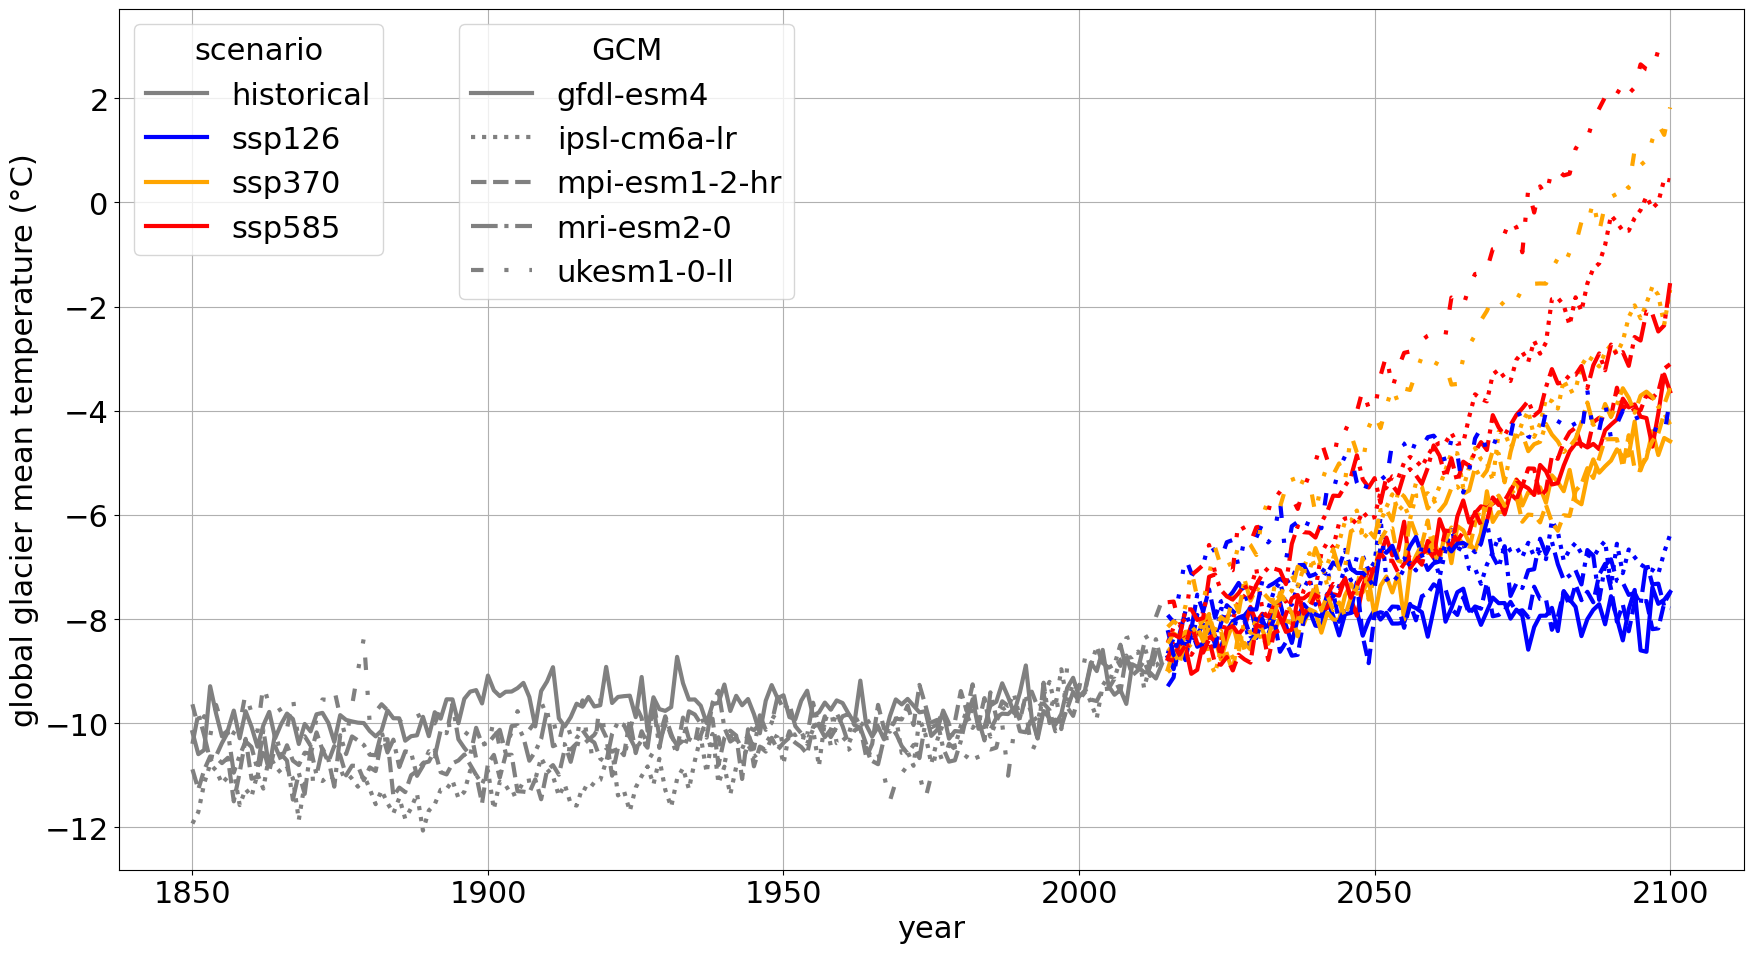

In [16]:
plt.rcParams.update({'font.size': 22})
#fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(18,28))
plt.figure(figsize=(18,10))
lss = ['-',':', '--', '-.', (0, (3, 5, 1, 5, 1, 5))]
for gcm, ls in zip(gcms,lss): 
    # visual test:
    for scenario, c in zip(scenarios, ['grey', 'blue', 'orange', 'red']):
        if scenario == 'historical':
            yr = np.arange(1850, 2015)
        else:
            yr = np.arange(2015, 2101)
        # ax1 = plt.subplot(2,1,1)
        
        plt.plot(yr, dict_global_tas_mean_g['{}_{}'.format(gcm, scenario)],
                 label = '{}'.format(scenario), color = c, ls = ls, lw=3)
        ax = plt.gca()
        ax.set_ylabel('global glacier mean temperature (°C)')
        ax.set_xlabel('year')
        if ls == '-':
            legend1 = ax.legend(loc=2, title = 'scenario')
            
lines = ax.get_lines()
legend2 = ax.legend(lines[::4], gcms , loc=2,
                     bbox_to_anchor=(0.2,1),
                     title='GCM')
ax.add_artist(legend1)

plt.tight_layout()
ax.grid()
plt.savefig('../isimip3b_postprocessing_analysis/plots_isimip3b_analysis/plot_isimip3b_glaciers_mean_time_series_temp.pdf');

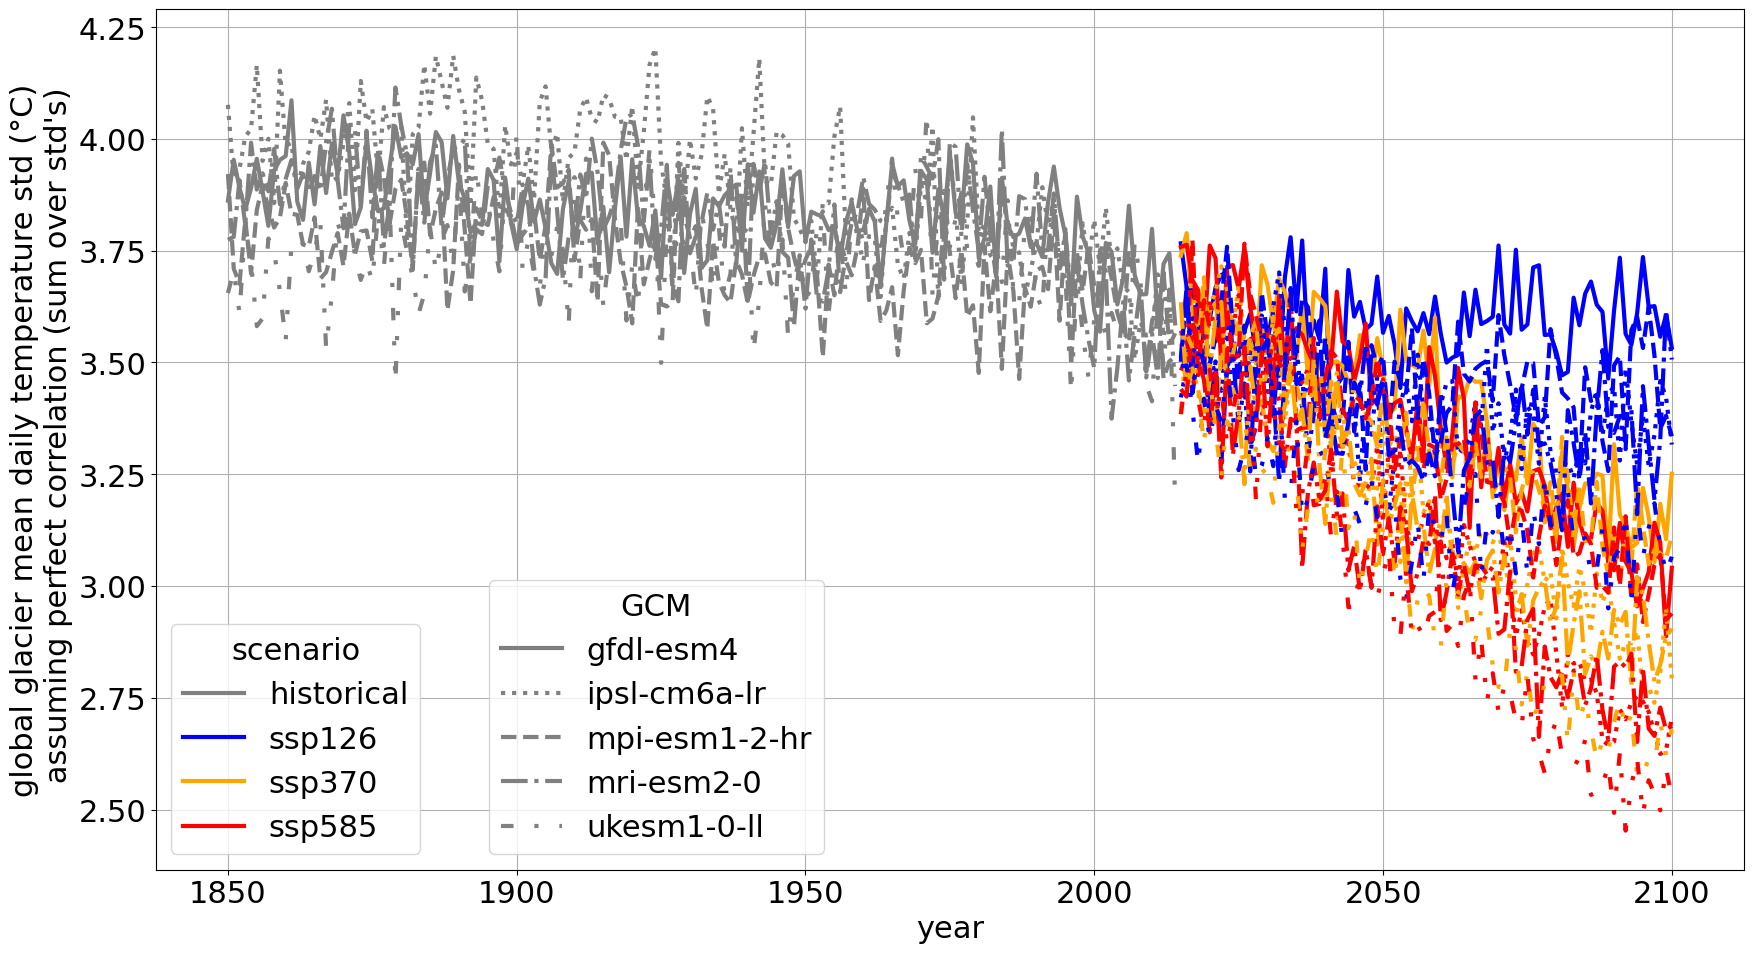

In [17]:
plt.rcParams.update({'font.size': 22})
#fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(18,28))
plt.figure(figsize=(18,10))
lss = ['-',':', '--', '-.', (0, (3, 5, 1, 5, 1, 5))]
for gcm, ls in zip(gcms,lss): 
    # visual test:
    for scenario, c in zip(scenarios, ['grey', 'blue', 'orange', 'red']):
        if scenario == 'historical':
            yr = np.arange(1850, 2015)
        else:
            yr = np.arange(2015, 2101)
        # ax1 = plt.subplot(2,1,1)
        
        plt.plot(yr, dict_global_tas_daily_std_g['{}_{}'.format(gcm, scenario)],
                 label = '{}'.format(scenario), color = c, ls = ls, lw=3)
        ax = plt.gca()
        ax.set_ylabel("global glacier mean daily temperature std (°C)\n assuming perfect correlation (sum over std's)")
        ax.set_xlabel('year')
        if ls == '-':
            legend1 = ax.legend(loc=3, title = 'scenario')
            
lines = ax.get_lines()
legend2 = ax.legend(lines[::4], gcms , loc=3,
                     bbox_to_anchor=(0.2,0),
                     title='GCM')
ax.add_artist(legend1)

plt.tight_layout()
ax.grid()
plt.savefig('../isimip3b_postprocessing_analysis/plots_isimip3b_analysis/plot_isimip3b_glaciers_mean_time_series_temp_std.pdf');

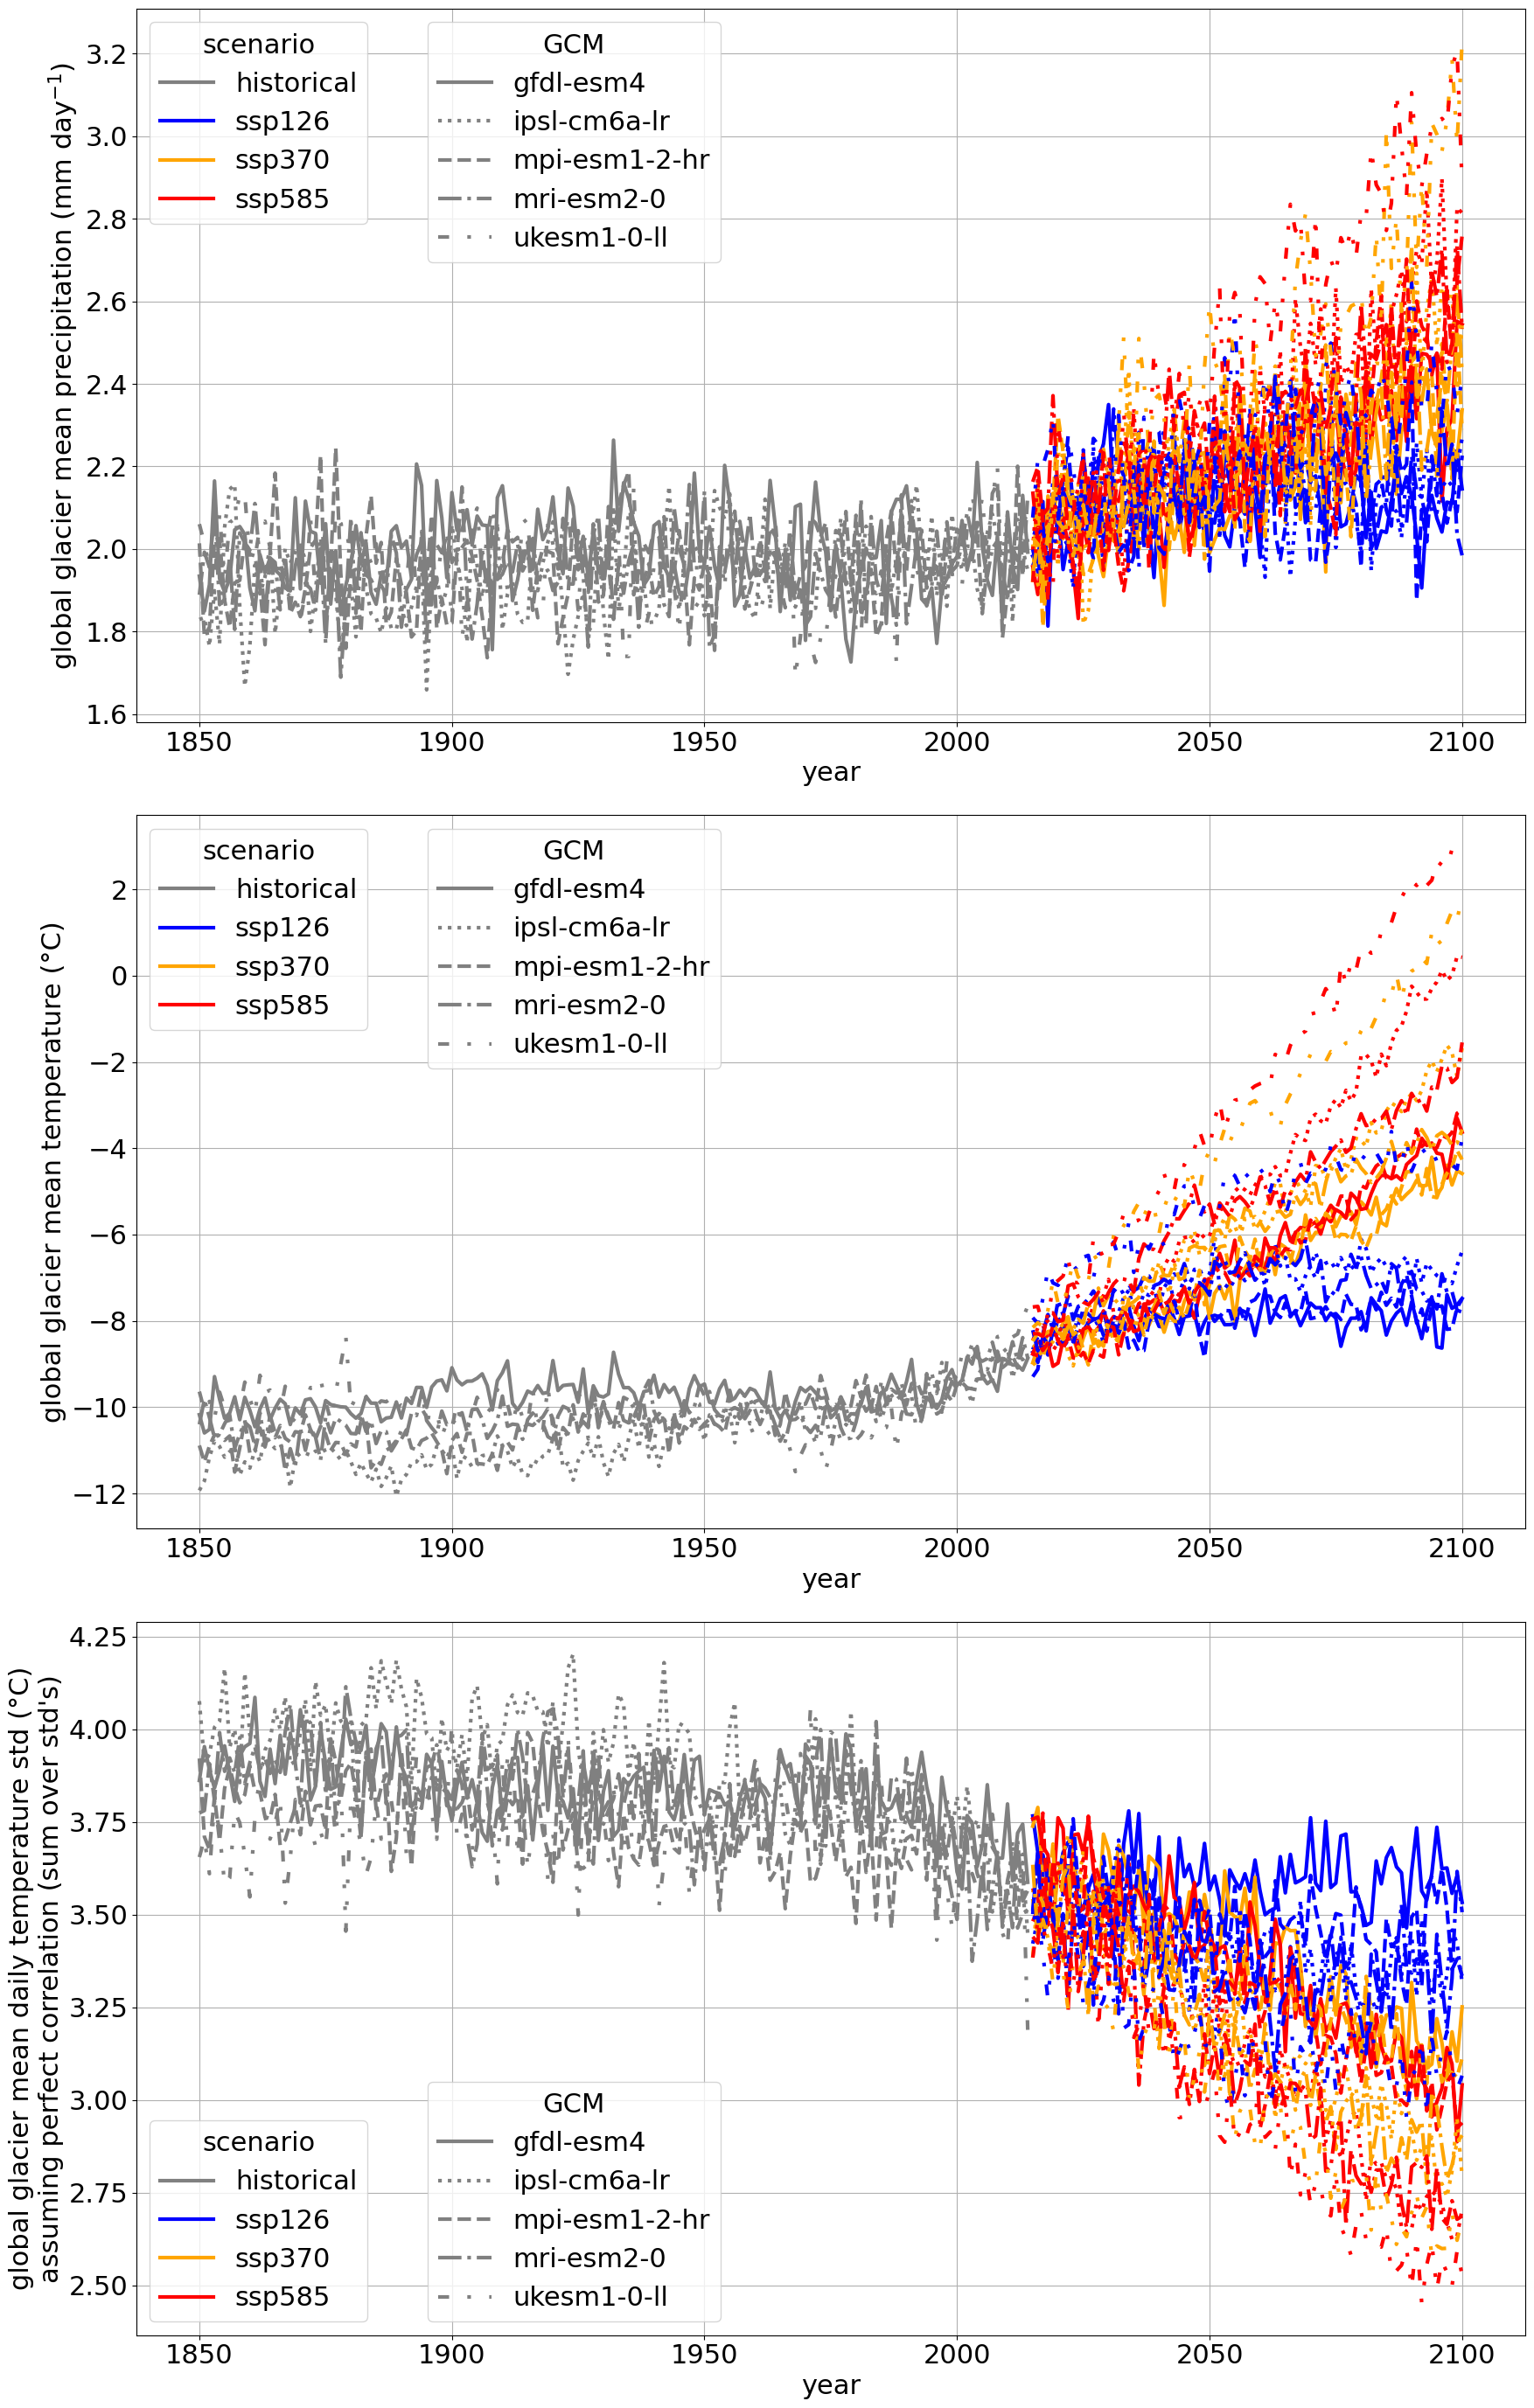

In [18]:
plt.rcParams.update({'font.size': 22})
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(18,28))

lss = ['-',':', '--', '-.', (0, (3, 5, 1, 5, 1, 5))]
for gcm, ls in zip(gcms,lss): 
    # visual test:
    for scenario, c in zip(scenarios, ['grey', 'blue', 'orange', 'red']):
        if scenario == 'historical':
            yr = np.arange(1850, 2015)
        else:
            yr = np.arange(2015, 2101)
        # ax1 = plt.subplot(2,1,1)
        ax1.plot(yr, dict_global_pr_mean_g['{}_{}'.format(gcm, scenario)],
                 label = '{}'.format(scenario), color = c, ls =ls, lw=3)
        ax1.set_ylabel(r'global glacier mean precipitation (mm day$^{-1}$)')
        ax1.set_xlabel('year')
        if ls == '-':
            legend1 = ax1.legend(loc=2, title = 'scenario')
        # ax2.subplot(2,1,2)
        ax2.plot(yr, dict_global_tas_mean_g['{}_{}'.format(gcm, scenario)],
                 label = '{}'.format(scenario), color = c, ls = ls, lw=3)
        ax2.set_ylabel('global glacier mean temperature (°C)')
        ax2.set_xlabel('year')
        if ls == '-':
            legend12 = ax2.legend(loc=2, title = 'scenario')
        ###
        ax3.plot(yr, dict_global_tas_daily_std_g['{}_{}'.format(gcm, scenario)],
                 label = '{}'.format(scenario), color = c, ls = ls, lw=3)
        ax3.set_ylabel("global glacier mean daily temperature std (°C)\nassuming perfect correlation (sum over std's)")
        ax3.set_xlabel('year')
        if ls == '-':
            legend13 = ax3.legend(loc=3, title = 'scenario')
        
lines = ax1.get_lines()
legend2 = ax1.legend(lines[::4], gcms , loc=2,
                     bbox_to_anchor=(0.2,1),
                     title='GCM')
ax1.add_artist(legend1)

lines = ax2.get_lines()
legend22 = ax2.legend(lines[::4], gcms , loc=2,
                      bbox_to_anchor=(0.2,1),
                      title='GCM')
ax2.add_artist(legend12)

lines = ax3.get_lines()
legend23 = ax3.legend(lines[::4], gcms , loc=3,
                      bbox_to_anchor=(0.2,0),
                      title='GCM')
ax3.add_artist(legend13)
plt.tight_layout()
ax1.grid()
ax2.grid()
ax3.grid()

plt.savefig('../isimip3b_postprocessing_analysis/plots_isimip3b_analysis/plot_isimip3b_glaciers_mean_time_series.pdf');

# OLD:

In [ ]:
# just drop GMT mean diff
_pd_temp_diff_1995_2014 = pd_temp_diff_1995_2014.loc[pd_temp_diff_1995_2014.rgi_reg!='GMT_mean_diff']
var = 'deltaT to median GCM'

from matplotlib.lines import Line2D
plt.rcParams.update({'font.size': 14})

for scenario in scenarios:
    plt.figure(figsize=(30, 25))
    j=0
    for exp_time in exp_times[4:]:
        period = f'{exp_time}-{exp_time+19}'
        pd_sel = _pd_temp_diff_1995_2014.loc[(_pd_temp_diff_1995_2014.period==period) & (_pd_temp_diff_1995_2014.ssp==scenario)] 
        for gcm in gcms:
            plt.subplot(4,5,j+1)
            ax = plt.gca()
            # for every GCM the same ... 
            plt.plot(pd_sel.groupby('rgi_reg').median().index,
                     pd_sel.groupby('rgi_reg').median()[var].values,
                     marker='_', ls = '',
                     color='grey', markersize=15, markeredgewidth=3,
                     label='median difference over GCMs for that region')

            if gcm==gcms[0]:
                plt.ylabel('$\Delta$ T (°C):\nT({}-{})'.format(exp_time, exp_time+19)+r'- T$_{med,GCMs}$(1995-2014)', fontsize=20)
            plt.yticks(np.arange(-14,22,1))
            maxi = pd_sel[var].max() +0.5
            mini = pd_sel[var].min() -0.5
            plt.ylim(mini, maxi)
            plt.title('{}: {}'.format(gcm,scenario), fontsize=22)
            ax.tick_params(axis='x',which='minor',bottom=False)
            if j==0:
                ax.legend([Line2D([0], [0], color='grey', marker='_', markersize=12, markeredgewidth=3)],
                      ['median difference over GCMs for that region'], fontsize=22)
            pd_sel_gcm = pd_sel.loc[pd_sel.gcm==gcm]
            pd_sel_gcm.index = pd_sel_gcm.rgi_reg
            pd_sel_gcm[var].plot(ax=ax, kind='bar', rot=45, color=['C3'] * 19+ [ 'C0','grey']) 
            j+=1
    plt.tight_layout()
    plt.savefig('plots_isimip3b_analysis/plot_isimip3b_glaciers_deltaT_expfuture-ref_{}_ref_median_GCM.pdf'.format(scenario))

In [ ]:
run = True
if run:
    scenario = 'hist'

    avg_ref_time_temp_per_gp_gcm_l = []
    avg_ref_time_temp_gcm_l = []
    avg_ref_time_pr_per_gp_gcm_l = []
    avg_ref_time_pr_gcm_l = []
    for gcm in gcms:
        if gcm in ['gfdl-esm4', 'ipsl-cm6a-lr', 'mpi-esm1-2-hr', 'mri-esm2-0']:
            ensemble = 'r1i1p1f1'
        elif gcm == 'ukesm1-0-ll':
            ensemble = 'r1i1p1f2'
        # for the ssp:
        ybegin = 2015
        yend = 2100
        ### temperature 
        # get the historical temperature file
        folder_output_t = 'isimip3b_tasAdjust_monthly'
        path_h_tas = '{}/{}_{}_w5e5_{}_{}_global_monthly_{}_{}.nc'.format(folder_output_t, gcm, ensemble, 'historical', 'tasAdjust', 1850, 2014)

        ds_gcm_t2m_hist = xr.open_dataset(path+path_h_tas).tasAdjust-273.15
        ds_gcm_t2m_hist['lon'] = np.where(ds_gcm_t2m_hist.lon.values < 0,
                                     ds_gcm_t2m_hist.lon.values + 360,
                                     ds_gcm_t2m_hist.lon.values)
        # temperature of the average reference time  for each gridpoint and for a single gcm 
        avg_ref_time_temp_per_gp_gcm = ds_gcm_t2m_hist.sel(time=slice(str(1850), str(1900))).mean(dim='time')
        avg_ref_time_temp_per_gp_gcm.coords['gcm'] = gcm
        avg_ref_time_temp_per_gp_gcm_l.append(avg_ref_time_temp_per_gp_gcm)      
        avg_ref_time_temp_gcm_l.append((ds_gcm_t2m_hist.sel(time=slice(str(1850),
                                                               str(1900))).groupby('time.year').mean()  * ds_inv.weight).sum(dim=['lon','lat']).mean())
        ### same for prcp.:
        folder_output_p = 'isimip3b_prAdjust_monthly'
        path_h_pr = '{}/{}_{}_w5e5_{}_{}_global_monthly_{}_{}.nc'.format(folder_output_p, gcm, ensemble, 'historical', 'prAdjust', 1850, 2014)
        ds_gcm_pr_hist = xr.open_dataset(path+path_h_pr).prAdjust
        ds_gcm_pr_hist['lon'] = np.where(ds_gcm_pr_hist.lon.values < 0,
                                         ds_gcm_pr_hist.lon.values + 360,
                                         ds_gcm_pr_hist.lon.values)
        avg_ref_time_pr_per_gp_gcm = ds_gcm_pr_hist.sel(time=slice(str(1850),str(1900))).mean(dim='time')
        avg_ref_time_pr_per_gp_gcm.coords['gcm'] = gcm
        avg_ref_time_pr_per_gp_gcm_l.append(avg_ref_time_pr_per_gp_gcm)
        avg_ref_time_pr_gcm_l.append((ds_gcm_pr_hist.sel(time=slice(str(1850),
                                                               str(1900))).groupby('time.year').mean()  * ds_inv.weight).sum(dim=['lon','lat']).mean())

    # the median temperature from the 5 gcms for the average reference time period for each gridpoint
    ds_avg_ref_time_temp_per_gp_gcm = xr.concat(avg_ref_time_temp_per_gp_gcm_l, dim='gcm')
    # median global temperature over the 5 GCMs  for the average reverence time period
    avg_ref_time_temp_median_gcm = np.median(avg_ref_time_temp_gcm_l)


    # the median precipitation from the 5 gcms for the average reference time period for each gridpoint
    avg_ref_time_pr_median_gcm = np.median(avg_ref_time_pr_gcm_l)
    # median global precipitation from the 5 GCMs  for the average reverence time period
    ds_avg_ref_time_pr_per_gp_gcm = xr.concat(avg_ref_time_pr_per_gp_gcm_l, dim='gcm')

run = False
if run:
    tdf_e = {}
    taf_e = {}
    taf_e_med = {}
    # this has to be repeated for each experiment:
    # it would be better to repeat the experiment for each typ (in the inner loop,
    # like that we would not need to repeat)
    for exp_time in exp_times:
        tdf_d = {}
        taf_d = {}
        taf_d_med = {}

        for scenario in scenarios:
            tdf = pd.DataFrame(dtype=float)
            taf = pd.DataFrame(dtype=float)
            taf_med = pd.DataFrame(dtype=float)
            for gcm in gcms:
                if gcm in ['gfdl-esm4', 'ipsl-cm6a-lr', 'mpi-esm1-2-hr', 'mri-esm2-0']:
                    ensemble = 'r1i1p1f1'
                elif gcm == 'ukesm1-0-ll':
                    ensemble = 'r1i1p1f2'

                    # for the ssp:
                ybegin = 2015
                yend = 2100

                folder_output = 'isimip3b_tasAdjust_monthly'    
                path_s = '{}/{}_{}_w5e5_{}_{}_global_monthly_{}_{}.nc'.format(folder_output, gcm, ensemble, scenario, 'tasAdjust', ybegin, yend)
                path_h = '{}/{}_{}_w5e5_{}_{}_global_monthly_{}_{}.nc'.format(folder_output, gcm, ensemble, 'historical', 'tasAdjust', 1850, 2014)

                # convert from K to Celsius 
                ds_gcm_t2m_hist = xr.open_dataset(path+path_h).tasAdjust-273.15
                ds_gcm_t2m = xr.open_dataset(path+path_s).tasAdjust-273.15
                ds_gcm_t2m_hist['lon'] = np.where(ds_gcm_t2m.lon.values < 0,
                                             ds_gcm_t2m.lon.values + 360,
                                             ds_gcm_t2m.lon.values)
                ds_gcm_t2m['lon'] = np.where(ds_gcm_t2m.lon.values < 0,
                                             ds_gcm_t2m.lon.values + 360,
                                             ds_gcm_t2m.lon.values)

                # could also look at the seasonal cycle, but here I look at the annual means ...
                if exp_time<2015:
                    # in that case the experiment period is also in the historic time!
                    # and actually it is equal for all scenarios !!!!
                    # mean temperature difference for each grid point 
                    t2m_dT = ds_gcm_t2m_hist.sel(time=slice(str(exp_time),
                                                            str(exp_time+19)) ).mean(dim='time') - ds_gcm_t2m_hist.sel(time=slice(str(1850),
                                                                                                                                  str(1900))).mean(dim='time')
                    # ... divided by GMT warming 
                    mean_ref = (ds_gcm_t2m_hist.sel(time=slice(str(1850),
                                                               str(1900))).groupby('time.year').mean()  * ds_inv.weight).sum(dim=['lon','lat'])
                    mean_exp = (ds_gcm_t2m_hist.sel(time=slice(str(exp_time),
                                                               str(exp_time+19))).groupby('time.year').mean()  * ds_inv.weight).sum(dim=['lon','lat'])

                    t2m_dT_per_dT = t2m_dT / (mean_exp.mean()-mean_ref.mean())

                    # this here is the same as before, but now we use as reference time period the median over the 5 GCMs
                    t2m_dT_median_gcm = ds_gcm_t2m_hist.sel(time=slice(str(exp_time),
                                                            str(exp_time+19)) ).mean(dim='time') - ds_avg_ref_time_temp_per_gp_gcm.median(dim='gcm')
                else:
                    # amount of warming for each grid point compared to reference time period (1995-2014)
                    t2m_dT = ds_gcm_t2m.sel(time=slice(str(exp_time),
                                                       str(exp_time+19))).mean(dim='time') - ds_gcm_t2m_hist.sel(time=slice(str(1850), str(1900))).mean(dim='time')

                    # ... divided by GMT warming 
                    mean_exp = (ds_gcm_t2m.sel(time=slice(str(exp_time), str(exp_time+19))).groupby('time.year').mean()  * ds_inv.weight).sum(dim=['lon','lat'])

                    mean_ref = (ds_gcm_t2m_hist.sel(time=slice(str(1850), str(1900))).groupby('time.year').mean()  * ds_inv.weight).sum(dim=['lon','lat'])

                    t2m_dT_per_dT = t2m_dT / (mean_exp.mean()-mean_ref.mean())

                    t2m_dT_median_gcm = ds_gcm_t2m.sel(time=slice(str(exp_time),
                                                       str(exp_time+19))).mean(dim='time') - ds_avg_ref_time_temp_per_gp_gcm.median(dim='gcm')

                # Check (should be one)
                tdf.loc['GMT', gcm] = float((t2m_dT_per_dT * ds_inv.weight).sum(dim=['lon','lat']))

                # these should be the same ... 
                taf.loc['GMT', gcm] = float((t2m_dT * ds_inv.weight).sum(dim=['lon','lat']))
                taf.loc['GMT_mean_diff', gcm] = (mean_exp.mean()-mean_ref.mean())
                tdf.loc['GMT_mean_diff', gcm] = (mean_exp.mean()-mean_ref.mean())

                #taf.loc['GMT_mean_diff', gcm] = (mean_exp.mean()-mean_hist.mean())
                #tdf.loc['GMT_mean_diff', gcm] = (mean_exp.mean()-mean_hist.mean())

                # All glaciers (weighted by area)
                # in weight_glacier: the area of each glacier is already inside
                tdf.loc['All', gcm] = float((t2m_dT_per_dT * ds_inv.weight_glacier).sum(dim=['lon','lat']))
                taf.loc['All', gcm] = float((t2m_dT * ds_inv.weight_glacier).sum(dim=['lon','lat']))

                # also get the numbers when we use the median climate over the 5 GCMs as reference time period
                taf_med.loc['GMT', gcm] = float((t2m_dT_median_gcm * ds_inv.weight).sum(dim=['lon','lat']))
                taf_med.loc['GMT_mean_diff', gcm] = (mean_exp.mean()- avg_ref_time_temp_median_gcm)
                taf_med.loc['All', gcm] = float((t2m_dT_median_gcm * ds_inv.weight_glacier).sum(dim=['lon','lat']))
                for rgi_reg in range(1, 20):
                    weight_reg = ds_inv.weight_glacier.where(ds_inv.rgi_region == rgi_reg)
                    weight_reg = weight_reg / weight_reg.sum()

                    tdf.loc['{:02d}'.format(rgi_reg), gcm] = float((t2m_dT_per_dT * weight_reg).sum(dim=['lon','lat']))
                    taf.loc['{:02d}'.format(rgi_reg), gcm] = float((t2m_dT * weight_reg).sum(dim=['lon','lat']))
                    taf_med.loc['{:02d}'.format(rgi_reg), gcm] = float((t2m_dT_median_gcm * weight_reg).sum(dim=['lon','lat']))

                tdf_d[scenario] = tdf
                taf_d[scenario] = taf
                taf_d_med[scenario] = taf_med

                ds_gcm_t2m_hist.close()
                ds_gcm_t2m.close()
        print(exp_time)
        tdf_e[exp_time] = tdf_d
        taf_e[exp_time] = taf_d
        taf_e_med[exp_time] = taf_d_med
        
if run:
    _pd_temp_diff_1995_2014_list = []
    for y0_time in exp_times:
        period = f'{y0_time}-{y0_time+19}'
        for scenario in scenarios:
            taf = taf_e[y0_time][scenario]
            tdf = tdf_e[y0_time][scenario]
            taf_med = taf_e_med[y0_time][scenario]

            tdf_long = tdf.stack().reset_index()
            # "to same GCM" means here, we compare each GCM to the same GCM, that means in time period 1995-2014, the temperature difference is zero
            tdf_long.columns = ['rgi_reg', 'gcm', r'deltaT per deltaGMT to same GCM']
            taf_long = taf.stack().reset_index()
            taf_long.columns = ['rgi_reg', 'gcm', r'deltaT to same GCM']
            taf_med_long = taf_med.stack().reset_index()
            # "to median GCM" means here, we compare each GCM to the median GCM estimate of the ref. time period,
            # that means in time period 1995-2014, the temperature difference is not exactly zero
            # This is more useful when we want to compare all experiments together!
            taf_med_long.columns = ['rgi_reg', 'gcm', r'deltaT to median GCM']
            _pd_temp_diff_1995_2014 = pd.concat([taf_long.groupby(['rgi_reg', 'gcm']).mean(),
                                        tdf_long.groupby(['rgi_reg', 'gcm']).mean(), 
                                                taf_med_long.groupby(['rgi_reg', 'gcm']).mean()], axis=1)
            _pd_temp_diff_1995_2014 = _pd_temp_diff_1995_2014.reset_index()
            _pd_temp_diff_1995_2014['ssp'] = scenario
            _pd_temp_diff_1995_2014['period'] = period
            _pd_temp_diff_1995_2014['ref_time'] = '1850-1900'
            _pd_temp_diff_1995_2014_list.append(_pd_temp_diff_1995_2014)

    pd_temp_diff_1995_2014 = pd.concat(_pd_temp_diff_1995_2014_list)
    pd_temp_diff_1995_2014 = pd_temp_diff_1995_2014.reset_index(drop=True)

    for p in ['1851-1870', '1901-1920', '1951-1970', '1995-2014']:
        for s in ['ssp370', 'ssp585']:
            index_drop = pd_temp_diff_1995_2014.loc[(pd_temp_diff_1995_2014.period == p) & (pd_temp_diff_1995_2014.ssp == s)].index
            pd_temp_diff_1995_2014 = pd_temp_diff_1995_2014.drop(index_drop)
        for s in ['ssp126']:
            index_rename = pd_temp_diff_1995_2014.loc[(pd_temp_diff_1995_2014.period == p) & (pd_temp_diff_1995_2014.ssp == s)].index
            pd_temp_diff_1995_2014.loc[index_rename, 'ssp'] = 'hist'

    # this is the absolute temperature difference compared to the reference time period together with the
    # per degree global temperature warming temperature difference compared to the reference time period 
    path_analysis = '/home/www/lschuster/glacierMIP3_analysis/'
    pd_temp_diff_1995_2014.to_csv(path_analysis + 'rgi_reg_glacier_area_weighted_temperature_difference_ipcc_0.63_isimip3b.csv')


# ISIMIP3b average Temperature change at glacier locations for each region separately

In [14]:
ds_inv.coords['lon'] = np.where(ds_inv.lon.values < 0, ds_inv.lon.values + 360,
                                  ds_inv.lon.values)
ds_inv = ds_inv.sortby(ds_inv.lon)
ds_inv.lon.attrs['units'] = 'degrees_onlypositive'

gcms = ['gfdl-esm4', 'ipsl-cm6a-lr', 'mpi-esm1-2-hr', 'mri-esm2-0', 'ukesm1-0-ll' ]
typs = ['tasAdjust']
scenarios = ['ssp126', 'ssp370', 'ssp585']
tdf_d = {}
taf_d = {}
for scenario in scenarios:
    tdf = pd.DataFrame(dtype=float)
    taf = pd.DataFrame(dtype=float)

    for gcm in gcms:
        if gcm in ['gfdl-esm4', 'ipsl-cm6a-lr', 'mpi-esm1-2-hr', 'mri-esm2-0']:
            ensemble = 'r1i1p1f1'
        elif gcm == 'ukesm1-0-ll':
            ensemble = 'r1i1p1f2'

            # for the ssp:
        ybegin = 2015
        yend = 2100
        for typ in typs:
            folder_output = 'isimip3b_{}_monthly'.format(typ)

            path_s = '{}/{}_{}_w5e5_{}_{}_global_monthly_{}_{}.nc'.format(folder_output, gcm, ensemble,
                                                                                 scenario, typ, ybegin, yend)
            path_h = '{}/{}_{}_w5e5_{}_{}_global_monthly_{}_{}.nc'.format(folder_output, gcm,
                                                                                   ensemble, 'historical',
                                                                                   typ, 1850, 2014)

            ds_gcm_t2m_hist = xr.open_dataset(path+path_h).tasAdjust-273.15
            ds_gcm_t2m = xr.open_dataset(path+path_s).tasAdjust-273.15
            ds_gcm_t2m_hist['lon'] = np.where(ds_gcm_t2m.lon.values < 0,
                                         ds_gcm_t2m.lon.values + 360,
                                         ds_gcm_t2m.lon.values)
            ds_gcm_t2m['lon'] = np.where(ds_gcm_t2m.lon.values < 0,
                                         ds_gcm_t2m.lon.values + 360,
                                         ds_gcm_t2m.lon.values)

            # could also look at the seasonal cycle, but here I look at the annual means ...
            mean = (ds_gcm_t2m.groupby('time.year').mean()  * ds_inv.weight).sum(dim=['lon','lat'])
            mean_hist = (ds_gcm_t2m_hist.groupby('time.year').mean()  * ds_inv.weight).sum(dim=['lon','lat'])

            
            # amount of warming for each grid point 
            t2m_dT = ds_gcm_t2m.sel(time=slice('2086','2100')).mean(dim='time') - ds_gcm_t2m_hist.sel(time=slice('2000', '2014')).mean(dim='time')
            # ... divided by GMT warming 
            t2m_dT_per_dT = t2m_dT / (mean.sel(year=slice(2086, 2100)).mean()-mean_hist.sel(year=slice(2000,2014)).mean())

            # Check (should be one)
            tdf.loc['GMT', gcm] = float((t2m_dT_per_dT * ds_inv.weight).sum(dim=['lon','lat']))

            # these should be the same ... 
            taf.loc['GMT', gcm] = float((t2m_dT * ds_inv.weight).sum(dim=['lon','lat']))
            taf.loc['GMT_mean_diff', gcm] = (mean.sel(year=slice(2086, 2100)).mean()-mean_hist.sel(year=slice(2000,2014)).mean())
            tdf.loc['GMT_mean_diff', gcm] = (mean.sel(year=slice(2086, 2100)).mean()-mean_hist.sel(year=slice(2000,2014)).mean())

            # All glaciers (weighted by area)
            # in weight_glacier: the area of each glacier is already inside
            tdf.loc['All', gcm] = float((t2m_dT_per_dT * ds_inv.weight_glacier).sum(dim=['lon','lat']))
            taf.loc['All', gcm] = float((t2m_dT * ds_inv.weight_glacier).sum(dim=['lon','lat']))

            for rgi_reg in range(1, 20):
                weight_reg = ds_inv.weight_glacier.where(ds_inv.rgi_region == rgi_reg)
                weight_reg = weight_reg / weight_reg.sum()

                tdf.loc['{:02d}'.format(rgi_reg), gcm] = float((t2m_dT_per_dT * weight_reg).sum(dim=['lon','lat']))
                taf.loc['{:02d}'.format(rgi_reg), gcm] = float((t2m_dT * weight_reg).sum(dim=['lon','lat']))

            tdf_d[scenario] = tdf
            taf_d[scenario] = taf

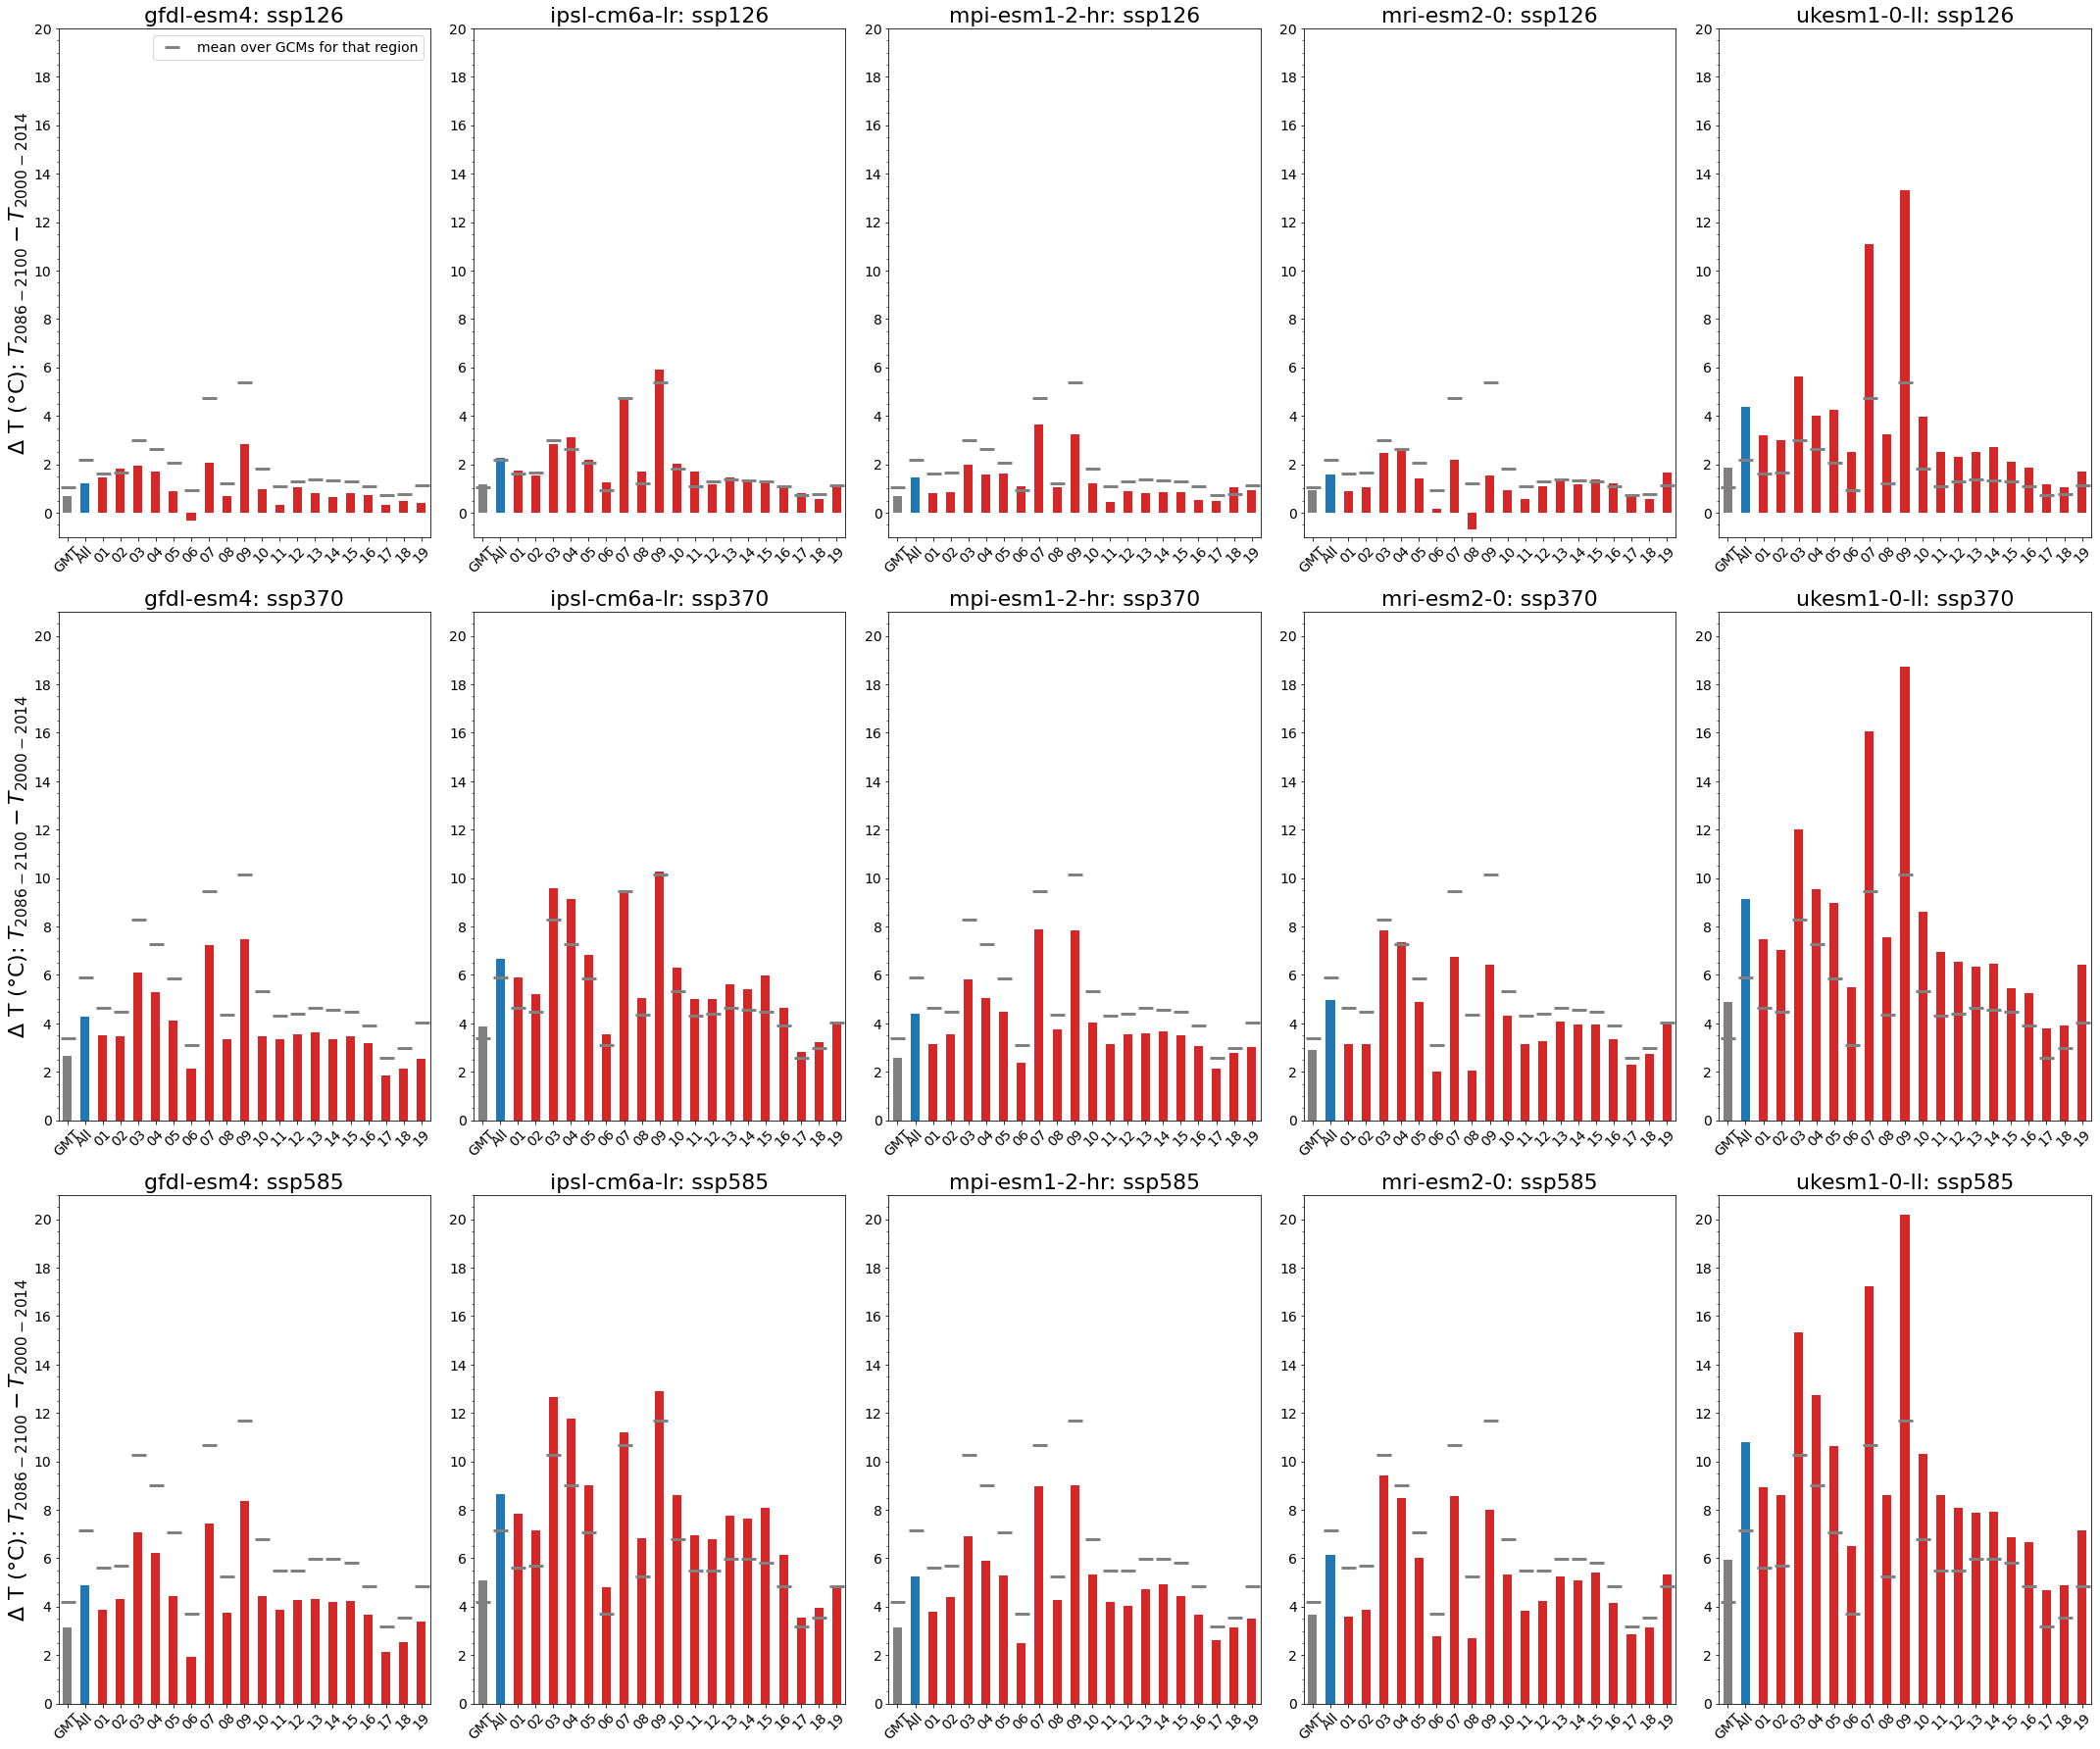

In [30]:
plt.rcParams.update({'font.size': 14})

plt.figure(figsize=(30, 25))

j=0
for scenario in scenarios:
    for gcm in gcms:
        plt.subplot(3,5,j+1)
        ax = plt.gca()
        plt.plot(taf_d[scenario].drop('GMT_mean_diff').mean(axis=1).index,
                 taf_d[scenario].drop('GMT_mean_diff').mean(axis=1).values, '_', color='grey', markersize=15, markeredgewidth=3,
                label='mean over GCMs for that region')
        if gcm==gcms[0]:
            plt.ylabel('$\Delta$ T (°C): $T_{2086-2100} - T_{2000-2014}$', fontsize=22)
        if scenario == scenarios[0]:
            plt.ylim(-1, 15)
        else:
            plt.ylim(0,21)
        plt.title('{}: {}'.format(gcm,scenario), fontsize=22)
        plt.minorticks_on() # (np.arange(0,19))
        plt.yticks(np.arange(0,22,2))
        ax.tick_params(axis='x',which='minor',bottom=False)
        if j==0:
            plt.legend(fontsize=22)
        taf_d[scenario].drop('GMT_mean_diff')[gcm].plot(ax=ax, kind='bar', rot=45, color=['grey', 'C0'] + ['C3'] * 19+ ['grey']) #, yerr=yerr);

        j+=1
plt.tight_layout()

plt.savefig('plots_isimip3b_analysis/plot_isimip3b_glaciers_deltaT.pdf')

we can recognize that:
- for all scenarios and gcms, glaciers will experience more warming
- however, the warming is very different for each region 
    - strongest warming in RGI 3,4, 7, 9
    - smallest warming in RGI 6, 17, 18
        - even some cooling in case of RGI 6 and RGI 8 for SSP126 for some ensembles
- ukesm has the largest temperature variations in between the regions

**same but as mean over GCMs with std of GCMs**

(mean corresponds to the grey lines that were visible in the plot above)

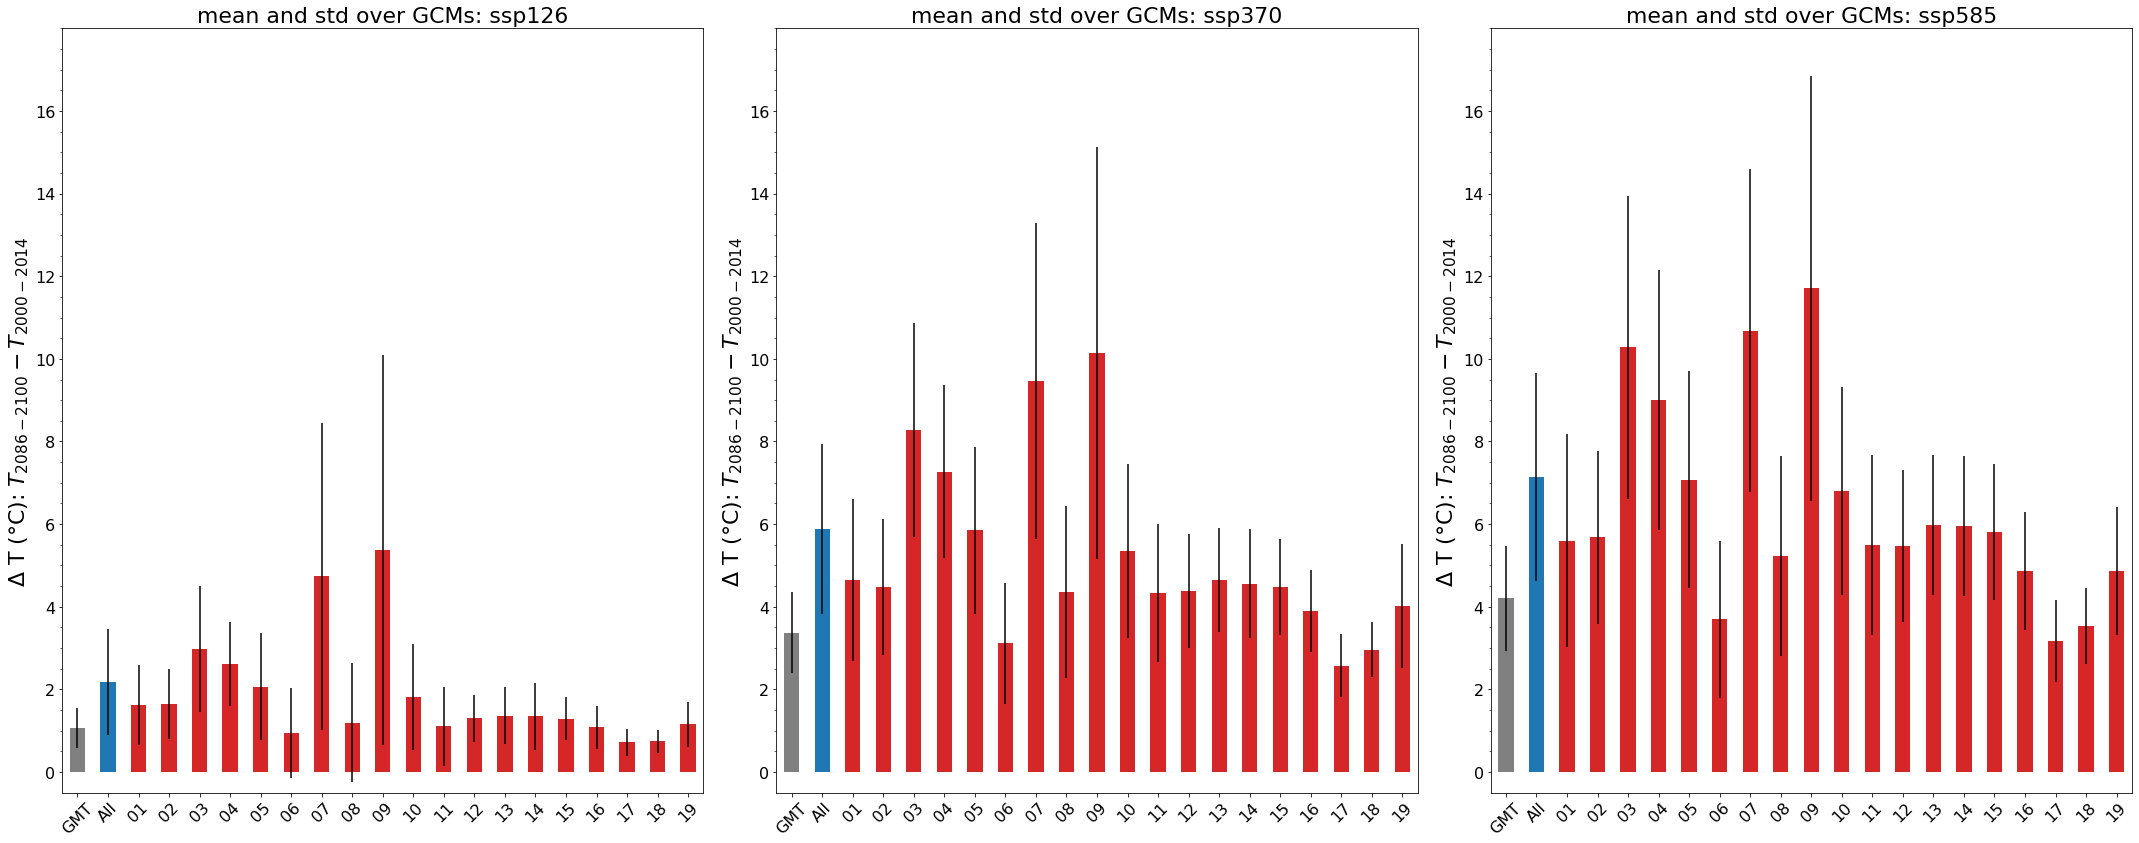

In [31]:
plt.rcParams.update({'font.size': 16})

plt.figure(figsize=(30, 12))

j=0
for scenario in scenarios:
        plt.subplot(1,3,j+1)
        ax = plt.gca()
        plt.ylabel('$\Delta$ T (°C): $T_{2086-2100} - T_{2000-2014}$', fontsize=22)
        plt.ylim(-0.5, 18)
        plt.title('mean and std over GCMs: {}'.format(scenario), fontsize=22)
        plt.minorticks_on() # (np.arange(0,19))
        plt.yticks(np.arange(0,18,2))
        ax.tick_params(axis='x',which='minor',bottom=False)
        yerr = taf_d[scenario].drop('GMT_mean_diff').std(axis=1)
        taf_d[scenario].drop('GMT_mean_diff').mean(axis=1).plot(ax=ax, kind='bar', rot=45, color=['grey', 'C0'] + ['C3'] * 19+ ['grey'], yerr=yerr);

        j+=1
plt.tight_layout()

plt.savefig('plots_isimip3b_analysis/plot_isimip3b_glaciers_deltaT_mean_std.pdf')



### gridpoint temperature warming per GMT warming

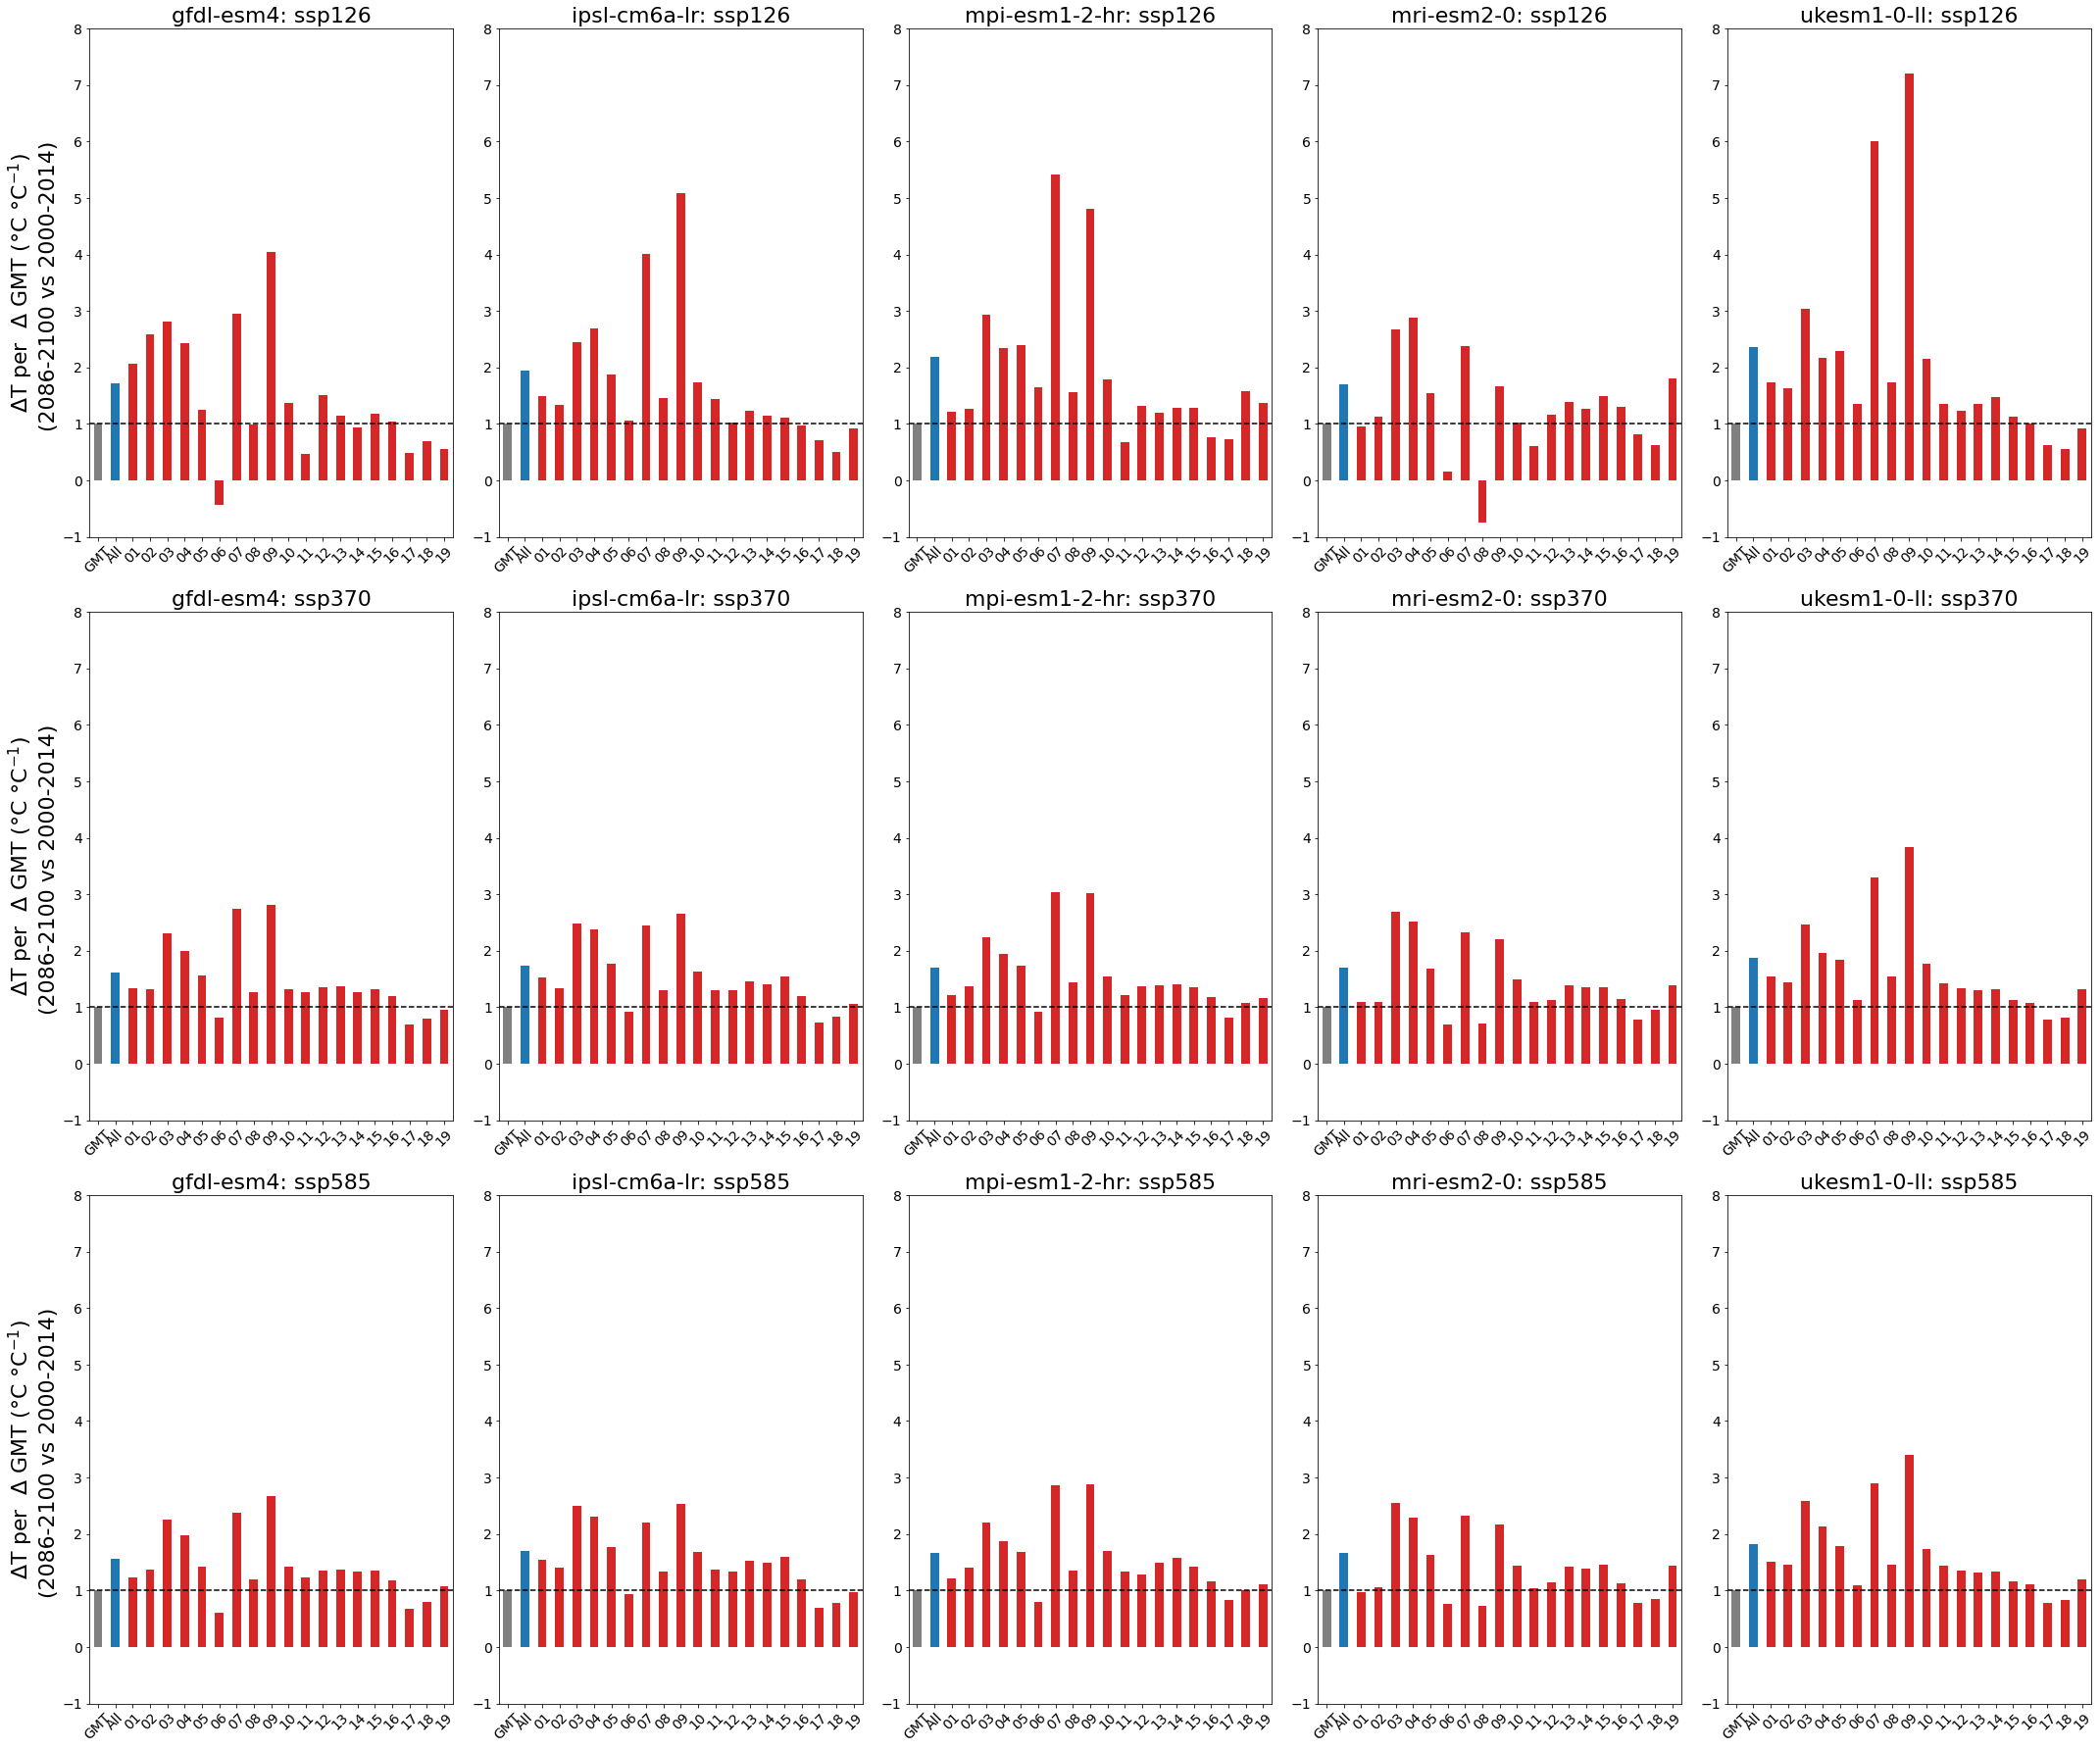

In [32]:
plt.rcParams.update({'font.size': 14})
plt.figure(figsize=(30, 25))


j=0
for scenario in scenarios:
    for gcm in gcms:

        plt.subplot(3,5,j+1)
        ax = plt.gca()
        plt.axhline([1], linestyle='--', color='k')
        tdf_d[scenario].drop('GMT_mean_diff')[gcm].plot(ax=ax, kind='bar', rot=45, color=['grey', 'C0'] + ['C3'] * 19+ ['grey']) #, yerr=yerr);
        if gcm == gcms[0]:
            plt.ylabel('$\Delta$T per  $\Delta$ GMT (°C °C$^{-1}$)\n(2086-2100 vs 2000-2014) ', fontsize=22)
        plt.ylim(-1, 8)
        plt.title('{}: {}'.format(gcm,scenario), fontsize=22)
        j+=1
plt.tight_layout()
#plt.suptitle(f'ISIMIP3b average T change at glacier locations per degree global warming(°C per GMT °C) 2086-2100 vs 2000-2014')

plt.savefig('plots_isimip3b_analysis/plot_isimip3b_glaciers_deltaT_per_deltaGMT.pdf')

- "1" means here that warming in this region is same as the global mean temperature warming for that scenario and that GCM
    - so it only shows the relative changes and is difficult to compare!

# Climate change for the different selected GlacierMIP3 time periods compared to the reference time period (1995-2014)

- 1995-2014 climate (here just randomly chosen median over GCMs)
    - temperature of the average reference time  for each gridpoint and for a single gcm 
    - then computed the amount of warming for each grid point compared to reference time period (1995-2014)
    - then estimate glacier-area weighted averaged temp. change for each RGI region!!! 
    
**FIRST: precompute the 1995-2014 reference climate (i.e. median over the 5 GCM's)**


In [7]:
# **FIRST: precompute the 1995-2014 reference climate (i.e. median over the 5 GCM's)**

# 20 years before 2015 (starting with 2015, data depends on ssp!)
ref_time = 1995 #slice(int(1995),int(2014),1)
# I also added here the reference period
exp_times = [1851, 1901, 1951, 1995, 2021, 2041, 2061, 2081]

# get the right format for the longitudes
ds_inv.coords['lon'] = np.where(ds_inv.lon.values < 0, ds_inv.lon.values + 360,
                                  ds_inv.lon.values)
ds_inv = ds_inv.sortby(ds_inv.lon)
ds_inv.lon.attrs['units'] = 'degrees_onlypositive'

gcms = ['gfdl-esm4', 'ipsl-cm6a-lr', 'mpi-esm1-2-hr', 'mri-esm2-0', 'ukesm1-0-ll' ]
scenarios = ['ssp126', 'ssp370', 'ssp585']

In [12]:
run = False
if run:
    scenario = 'hist'
    ref_time = 1995

    avg_ref_time_temp_per_gp_gcm_l = []
    avg_ref_time_temp_gcm_l = []
    avg_ref_time_pr_per_gp_gcm_l = []
    avg_ref_time_pr_gcm_l = []
    for gcm in gcms:
        if gcm in ['gfdl-esm4', 'ipsl-cm6a-lr', 'mpi-esm1-2-hr', 'mri-esm2-0']:
            ensemble = 'r1i1p1f1'
        elif gcm == 'ukesm1-0-ll':
            ensemble = 'r1i1p1f2'
        # for the ssp:
        ybegin = 2015
        yend = 2100
        ### temperature 
        # get the historical temperature file
        folder_output_t = 'isimip3b_tasAdjust_monthly'
        path_h_tas = '{}/{}_{}_w5e5_{}_{}_global_monthly_{}_{}.nc'.format(folder_output_t, gcm, ensemble, 'historical', 'tasAdjust', 1850, 2014)

        ds_gcm_t2m_hist = xr.open_dataset(path+path_h_tas).tasAdjust-273.15
        ds_gcm_t2m_hist['lon'] = np.where(ds_gcm_t2m_hist.lon.values < 0,
                                     ds_gcm_t2m_hist.lon.values + 360,
                                     ds_gcm_t2m_hist.lon.values)
        # temperature of the average reference time  for each gridpoint and for a single gcm 
        avg_ref_time_temp_per_gp_gcm = ds_gcm_t2m_hist.sel(time=slice(str(ref_time), str(ref_time+19))).mean(dim='time')
        avg_ref_time_temp_per_gp_gcm.coords['gcm'] = gcm
        avg_ref_time_temp_per_gp_gcm_l.append(avg_ref_time_temp_per_gp_gcm)      
        avg_ref_time_temp_gcm_l.append((ds_gcm_t2m_hist.sel(time=slice(str(ref_time),
                                                               str(ref_time+19))).groupby('time.year').mean()  * ds_inv.weight).sum(dim=['lon','lat']).mean())
        ### same for prcp.:
        folder_output_p = 'isimip3b_prAdjust_monthly'
        path_h_pr = '{}/{}_{}_w5e5_{}_{}_global_monthly_{}_{}.nc'.format(folder_output_p, gcm, ensemble, 'historical', 'prAdjust', 1850, 2014)
        ds_gcm_pr_hist = xr.open_dataset(path+path_h_pr).prAdjust
        ds_gcm_pr_hist['lon'] = np.where(ds_gcm_pr_hist.lon.values < 0,
                                         ds_gcm_pr_hist.lon.values + 360,
                                         ds_gcm_pr_hist.lon.values)
        avg_ref_time_pr_per_gp_gcm = ds_gcm_pr_hist.sel(time=slice(str(ref_time),str(ref_time+19))).mean(dim='time')
        avg_ref_time_pr_per_gp_gcm.coords['gcm'] = gcm
        avg_ref_time_pr_per_gp_gcm_l.append(avg_ref_time_pr_per_gp_gcm)
        avg_ref_time_pr_gcm_l.append((ds_gcm_pr_hist.sel(time=slice(str(ref_time),
                                                               str(ref_time+19))).groupby('time.year').mean()  * ds_inv.weight).sum(dim=['lon','lat']).mean())

    # the median temperature from the 5 gcms for the average reference time period for each gridpoint
    ds_avg_ref_time_temp_per_gp_gcm = xr.concat(avg_ref_time_temp_per_gp_gcm_l, dim='gcm')
    # median global temperature over the 5 GCMs  for the average reverence time period
    avg_ref_time_temp_median_gcm = np.median(avg_ref_time_temp_gcm_l)


    # the median precipitation from the 5 gcms for the average reference time period for each gridpoint
    avg_ref_time_pr_median_gcm = np.median(avg_ref_time_pr_gcm_l)
    # median global precipitation from the 5 GCMs  for the average reverence time period
    ds_avg_ref_time_pr_per_gp_gcm = xr.concat(avg_ref_time_pr_per_gp_gcm_l, dim='gcm')

## Temperature changes of the different selected GlacierMIP3 time periods compared to the reference time period (1995-2014)

In [ ]:
run = False
if run:
    tdf_e = {}
    taf_e = {}
    taf_e_med = {}
    # this has to be repeated for each experiment:
    # it would be better to repeat the experiment for each typ (in the inner loop,
    # like that we would not need to repeat)
    for exp_time in exp_times:
        tdf_d = {}
        taf_d = {}
        taf_d_med = {}

        for scenario in scenarios:
            tdf = pd.DataFrame(dtype=float)
            taf = pd.DataFrame(dtype=float)
            taf_med = pd.DataFrame(dtype=float)
            for gcm in gcms:
                if gcm in ['gfdl-esm4', 'ipsl-cm6a-lr', 'mpi-esm1-2-hr', 'mri-esm2-0']:
                    ensemble = 'r1i1p1f1'
                elif gcm == 'ukesm1-0-ll':
                    ensemble = 'r1i1p1f2'

                    # for the ssp:
                ybegin = 2015
                yend = 2100

                folder_output = 'isimip3b_tasAdjust_monthly'    
                path_s = '{}/{}_{}_w5e5_{}_{}_global_monthly_{}_{}.nc'.format(folder_output, gcm, ensemble, scenario, 'tasAdjust', ybegin, yend)
                path_h = '{}/{}_{}_w5e5_{}_{}_global_monthly_{}_{}.nc'.format(folder_output, gcm, ensemble, 'historical', 'tasAdjust', 1850, 2014)

                # convert from K to Celsius 
                ds_gcm_t2m_hist = xr.open_dataset(path+path_h).tasAdjust-273.15
                ds_gcm_t2m = xr.open_dataset(path+path_s).tasAdjust-273.15
                ds_gcm_t2m_hist['lon'] = np.where(ds_gcm_t2m.lon.values < 0,
                                             ds_gcm_t2m.lon.values + 360,
                                             ds_gcm_t2m.lon.values)
                ds_gcm_t2m['lon'] = np.where(ds_gcm_t2m.lon.values < 0,
                                             ds_gcm_t2m.lon.values + 360,
                                             ds_gcm_t2m.lon.values)

                # could also look at the seasonal cycle, but here I look at the annual means ...
                if exp_time<2015:
                    # in that case the experiment period is also in the historic time!
                    # and actually it is equal for all scenarios !!!!
                    # mean temperature difference for each grid point 
                    t2m_dT = ds_gcm_t2m_hist.sel(time=slice(str(exp_time),
                                                            str(exp_time+19)) ).mean(dim='time') - ds_gcm_t2m_hist.sel(time=slice(str(ref_time),
                                                                                                                                  str(ref_time+19))).mean(dim='time')
                    # ... divided by GMT warming 
                    mean_ref = (ds_gcm_t2m_hist.sel(time=slice(str(ref_time),
                                                               str(ref_time+19))).groupby('time.year').mean()  * ds_inv.weight).sum(dim=['lon','lat'])
                    mean_exp = (ds_gcm_t2m_hist.sel(time=slice(str(exp_time),
                                                               str(exp_time+19))).groupby('time.year').mean()  * ds_inv.weight).sum(dim=['lon','lat'])

                    t2m_dT_per_dT = t2m_dT / (mean_exp.mean()-mean_ref.mean())

                    # this here is the same as before, but now we use as reference time period the median over the 5 GCMs
                    t2m_dT_median_gcm = ds_gcm_t2m_hist.sel(time=slice(str(exp_time),
                                                            str(exp_time+19)) ).mean(dim='time') - ds_avg_ref_time_temp_per_gp_gcm.median(dim='gcm')
                else:
                    # amount of warming for each grid point compared to reference time period (1995-2014)
                    t2m_dT = ds_gcm_t2m.sel(time=slice(str(exp_time),
                                                       str(exp_time+19))).mean(dim='time') - ds_gcm_t2m_hist.sel(time=slice(str(ref_time), str(ref_time+19))).mean(dim='time')

                    # ... divided by GMT warming 
                    mean_exp = (ds_gcm_t2m.sel(time=slice(str(exp_time), str(exp_time+19))).groupby('time.year').mean()  * ds_inv.weight).sum(dim=['lon','lat'])

                    mean_ref = (ds_gcm_t2m_hist.sel(time=slice(str(ref_time), str(ref_time+19))).groupby('time.year').mean()  * ds_inv.weight).sum(dim=['lon','lat'])

                    t2m_dT_per_dT = t2m_dT / (mean_exp.mean()-mean_ref.mean())

                    t2m_dT_median_gcm = ds_gcm_t2m.sel(time=slice(str(exp_time),
                                                       str(exp_time+19))).mean(dim='time') - ds_avg_ref_time_temp_per_gp_gcm.median(dim='gcm')

                # Check (should be one)
                tdf.loc['GMT', gcm] = float((t2m_dT_per_dT * ds_inv.weight).sum(dim=['lon','lat']))

                # these should be the same ... 
                taf.loc['GMT', gcm] = float((t2m_dT * ds_inv.weight).sum(dim=['lon','lat']))
                taf.loc['GMT_mean_diff', gcm] = (mean_exp.mean()-mean_ref.mean())
                tdf.loc['GMT_mean_diff', gcm] = (mean_exp.mean()-mean_ref.mean())

                #taf.loc['GMT_mean_diff', gcm] = (mean_exp.mean()-mean_hist.mean())
                #tdf.loc['GMT_mean_diff', gcm] = (mean_exp.mean()-mean_hist.mean())

                # All glaciers (weighted by area)
                # in weight_glacier: the area of each glacier is already inside
                tdf.loc['All', gcm] = float((t2m_dT_per_dT * ds_inv.weight_glacier).sum(dim=['lon','lat']))
                taf.loc['All', gcm] = float((t2m_dT * ds_inv.weight_glacier).sum(dim=['lon','lat']))

                # also get the numbers when we use the median climate over the 5 GCMs as reference time period
                taf_med.loc['GMT', gcm] = float((t2m_dT_median_gcm * ds_inv.weight).sum(dim=['lon','lat']))
                taf_med.loc['GMT_mean_diff', gcm] = (mean_exp.mean()- avg_ref_time_temp_median_gcm)
                taf_med.loc['All', gcm] = float((t2m_dT_median_gcm * ds_inv.weight_glacier).sum(dim=['lon','lat']))
                for rgi_reg in range(1, 20):
                    weight_reg = ds_inv.weight_glacier.where(ds_inv.rgi_region == rgi_reg)
                    weight_reg = weight_reg / weight_reg.sum()

                    tdf.loc['{:02d}'.format(rgi_reg), gcm] = float((t2m_dT_per_dT * weight_reg).sum(dim=['lon','lat']))
                    taf.loc['{:02d}'.format(rgi_reg), gcm] = float((t2m_dT * weight_reg).sum(dim=['lon','lat']))
                    taf_med.loc['{:02d}'.format(rgi_reg), gcm] = float((t2m_dT_median_gcm * weight_reg).sum(dim=['lon','lat']))

                tdf_d[scenario] = tdf
                taf_d[scenario] = taf
                taf_d_med[scenario] = taf_med

                ds_gcm_t2m_hist.close()
                ds_gcm_t2m.close()
        print(exp_time)
        tdf_e[exp_time] = tdf_d
        taf_e[exp_time] = taf_d
        taf_e_med[exp_time] = taf_d_med

1851


**let's save the regional gcm, ssp & period - dependent climate changes compared to the reference time period**
- we can use this later to compare that to the glacier changes

In [ ]:
if run:
    _pd_temp_diff_1995_2014_list = []
    for y0_time in exp_times:
        period = f'{y0_time}-{y0_time+19}'
        for scenario in scenarios:
            taf = taf_e[y0_time][scenario]
            tdf = tdf_e[y0_time][scenario]
            taf_med = taf_e_med[y0_time][scenario]

            tdf_long = tdf.stack().reset_index()
            # "to same GCM" means here, we compare each GCM to the same GCM, that means in time period 1995-2014, the temperature difference is zero
            tdf_long.columns = ['rgi_reg', 'gcm', r'deltaT per deltaGMT to same GCM']
            taf_long = taf.stack().reset_index()
            taf_long.columns = ['rgi_reg', 'gcm', r'deltaT to same GCM']
            taf_med_long = taf_med.stack().reset_index()
            # "to median GCM" means here, we compare each GCM to the median GCM estimate of the ref. time period,
            # that means in time period 1995-2014, the temperature difference is not exactly zero
            # This is more useful when we want to compare all experiments together!
            taf_med_long.columns = ['rgi_reg', 'gcm', r'deltaT to median GCM']
            _pd_temp_diff_1995_2014 = pd.concat([taf_long.groupby(['rgi_reg', 'gcm']).mean(),
                                        tdf_long.groupby(['rgi_reg', 'gcm']).mean(), 
                                                taf_med_long.groupby(['rgi_reg', 'gcm']).mean()], axis=1)
            _pd_temp_diff_1995_2014 = _pd_temp_diff_1995_2014.reset_index()
            _pd_temp_diff_1995_2014['ssp'] = scenario
            _pd_temp_diff_1995_2014['period'] = period
            _pd_temp_diff_1995_2014['ref_time'] = '1995-2014'
            _pd_temp_diff_1995_2014_list.append(_pd_temp_diff_1995_2014)

    pd_temp_diff_1995_2014 = pd.concat(_pd_temp_diff_1995_2014_list)
    pd_temp_diff_1995_2014 = pd_temp_diff_1995_2014.reset_index(drop=True)

    for p in ['1851-1870', '1901-1920', '1951-1970', '1995-2014']:
        for s in ['ssp370', 'ssp585']:
            index_drop = pd_temp_diff_1995_2014.loc[(pd_temp_diff_1995_2014.period == p) & (pd_temp_diff_1995_2014.ssp == s)].index
            pd_temp_diff_1995_2014 = pd_temp_diff_1995_2014.drop(index_drop)
        for s in ['ssp126']:
            index_rename = pd_temp_diff_1995_2014.loc[(pd_temp_diff_1995_2014.period == p) & (pd_temp_diff_1995_2014.ssp == s)].index
            pd_temp_diff_1995_2014.loc[index_rename, 'ssp'] = 'hist'

    # this is the absolute temperature difference compared to the reference time period together with the
    # per degree global temperature warming temperature difference compared to the reference time period 
    path_analysis = '/home/www/lschuster/glacierMIP3_analysis/'
    pd_temp_diff_1995_2014.to_csv(path_analysis + 'rgi_reg_glacier_area_weighted_temperature_difference_vs_1995_2014_isimip3b.csv')


In [ ]:
path_analysis = '/home/www/lschuster/glacierMIP3_analysis/'
pd_temp_diff_1995_2014=pd.read_csv(path_analysis + 'rgi_reg_glacier_area_weighted_temperature_difference_vs_1995_2014_isimip3b.csv', index_col=[0])
pd_temp_diff_1995_2014

#### Future temperature changes 

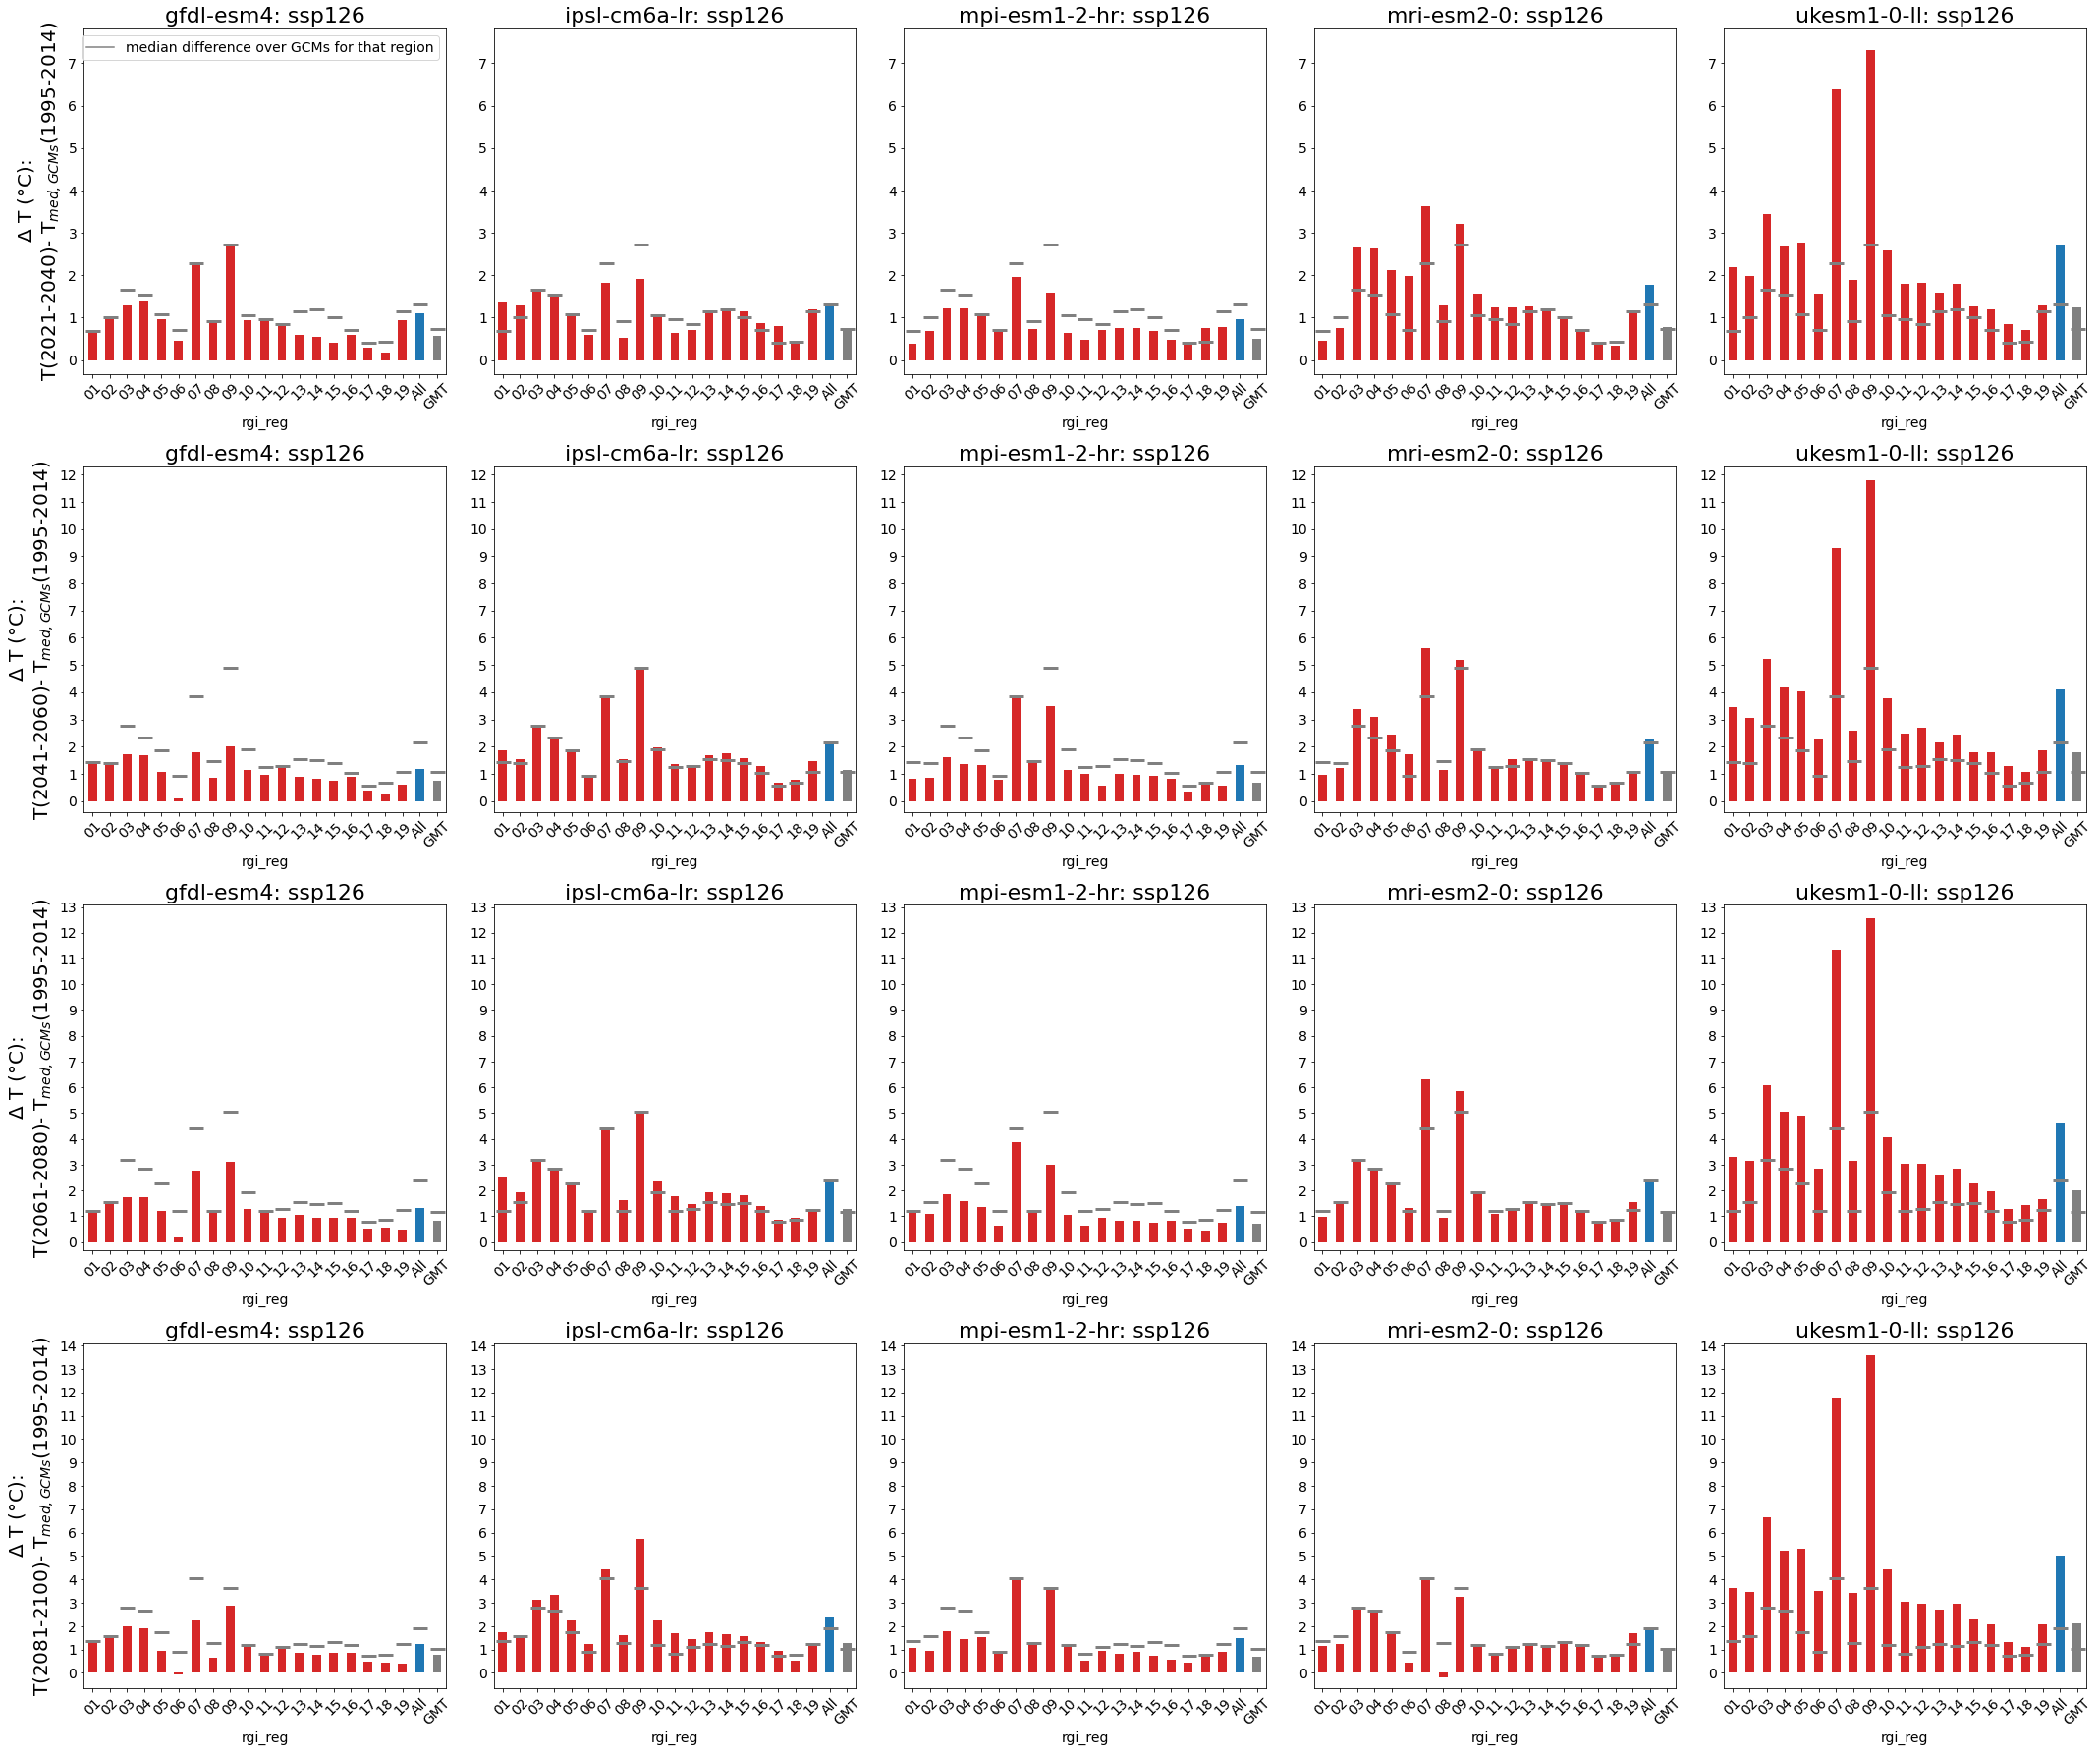

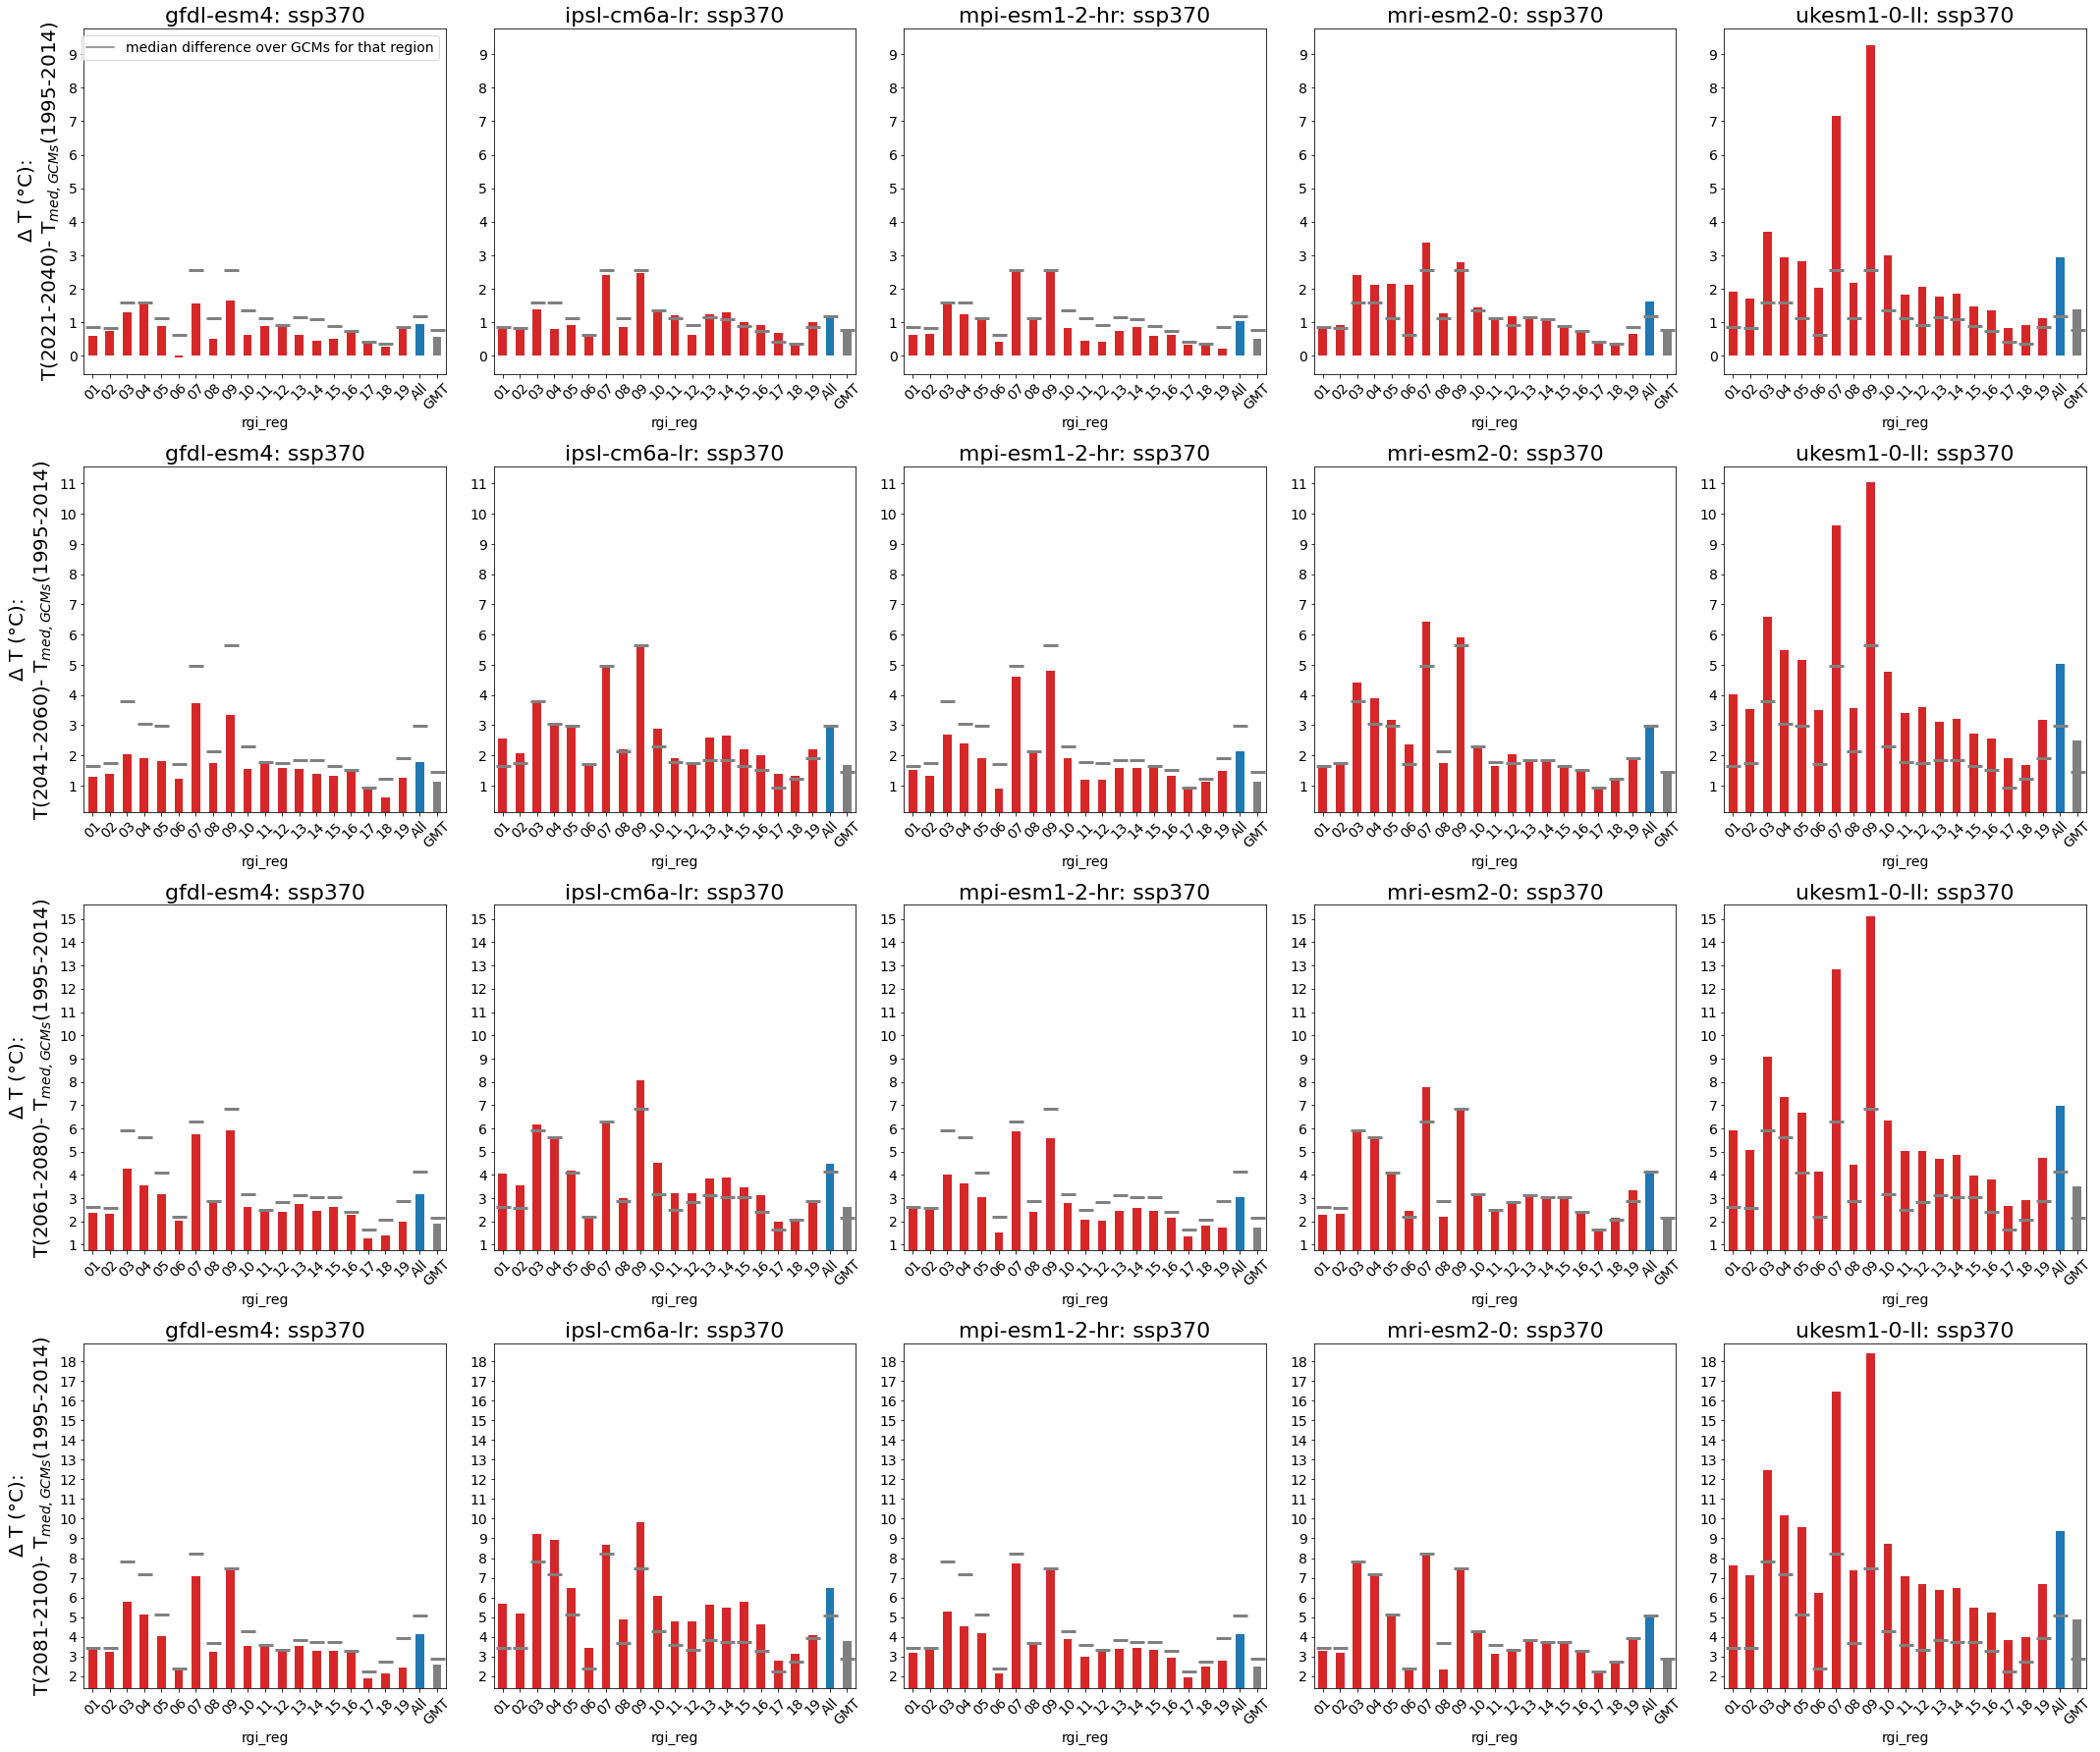

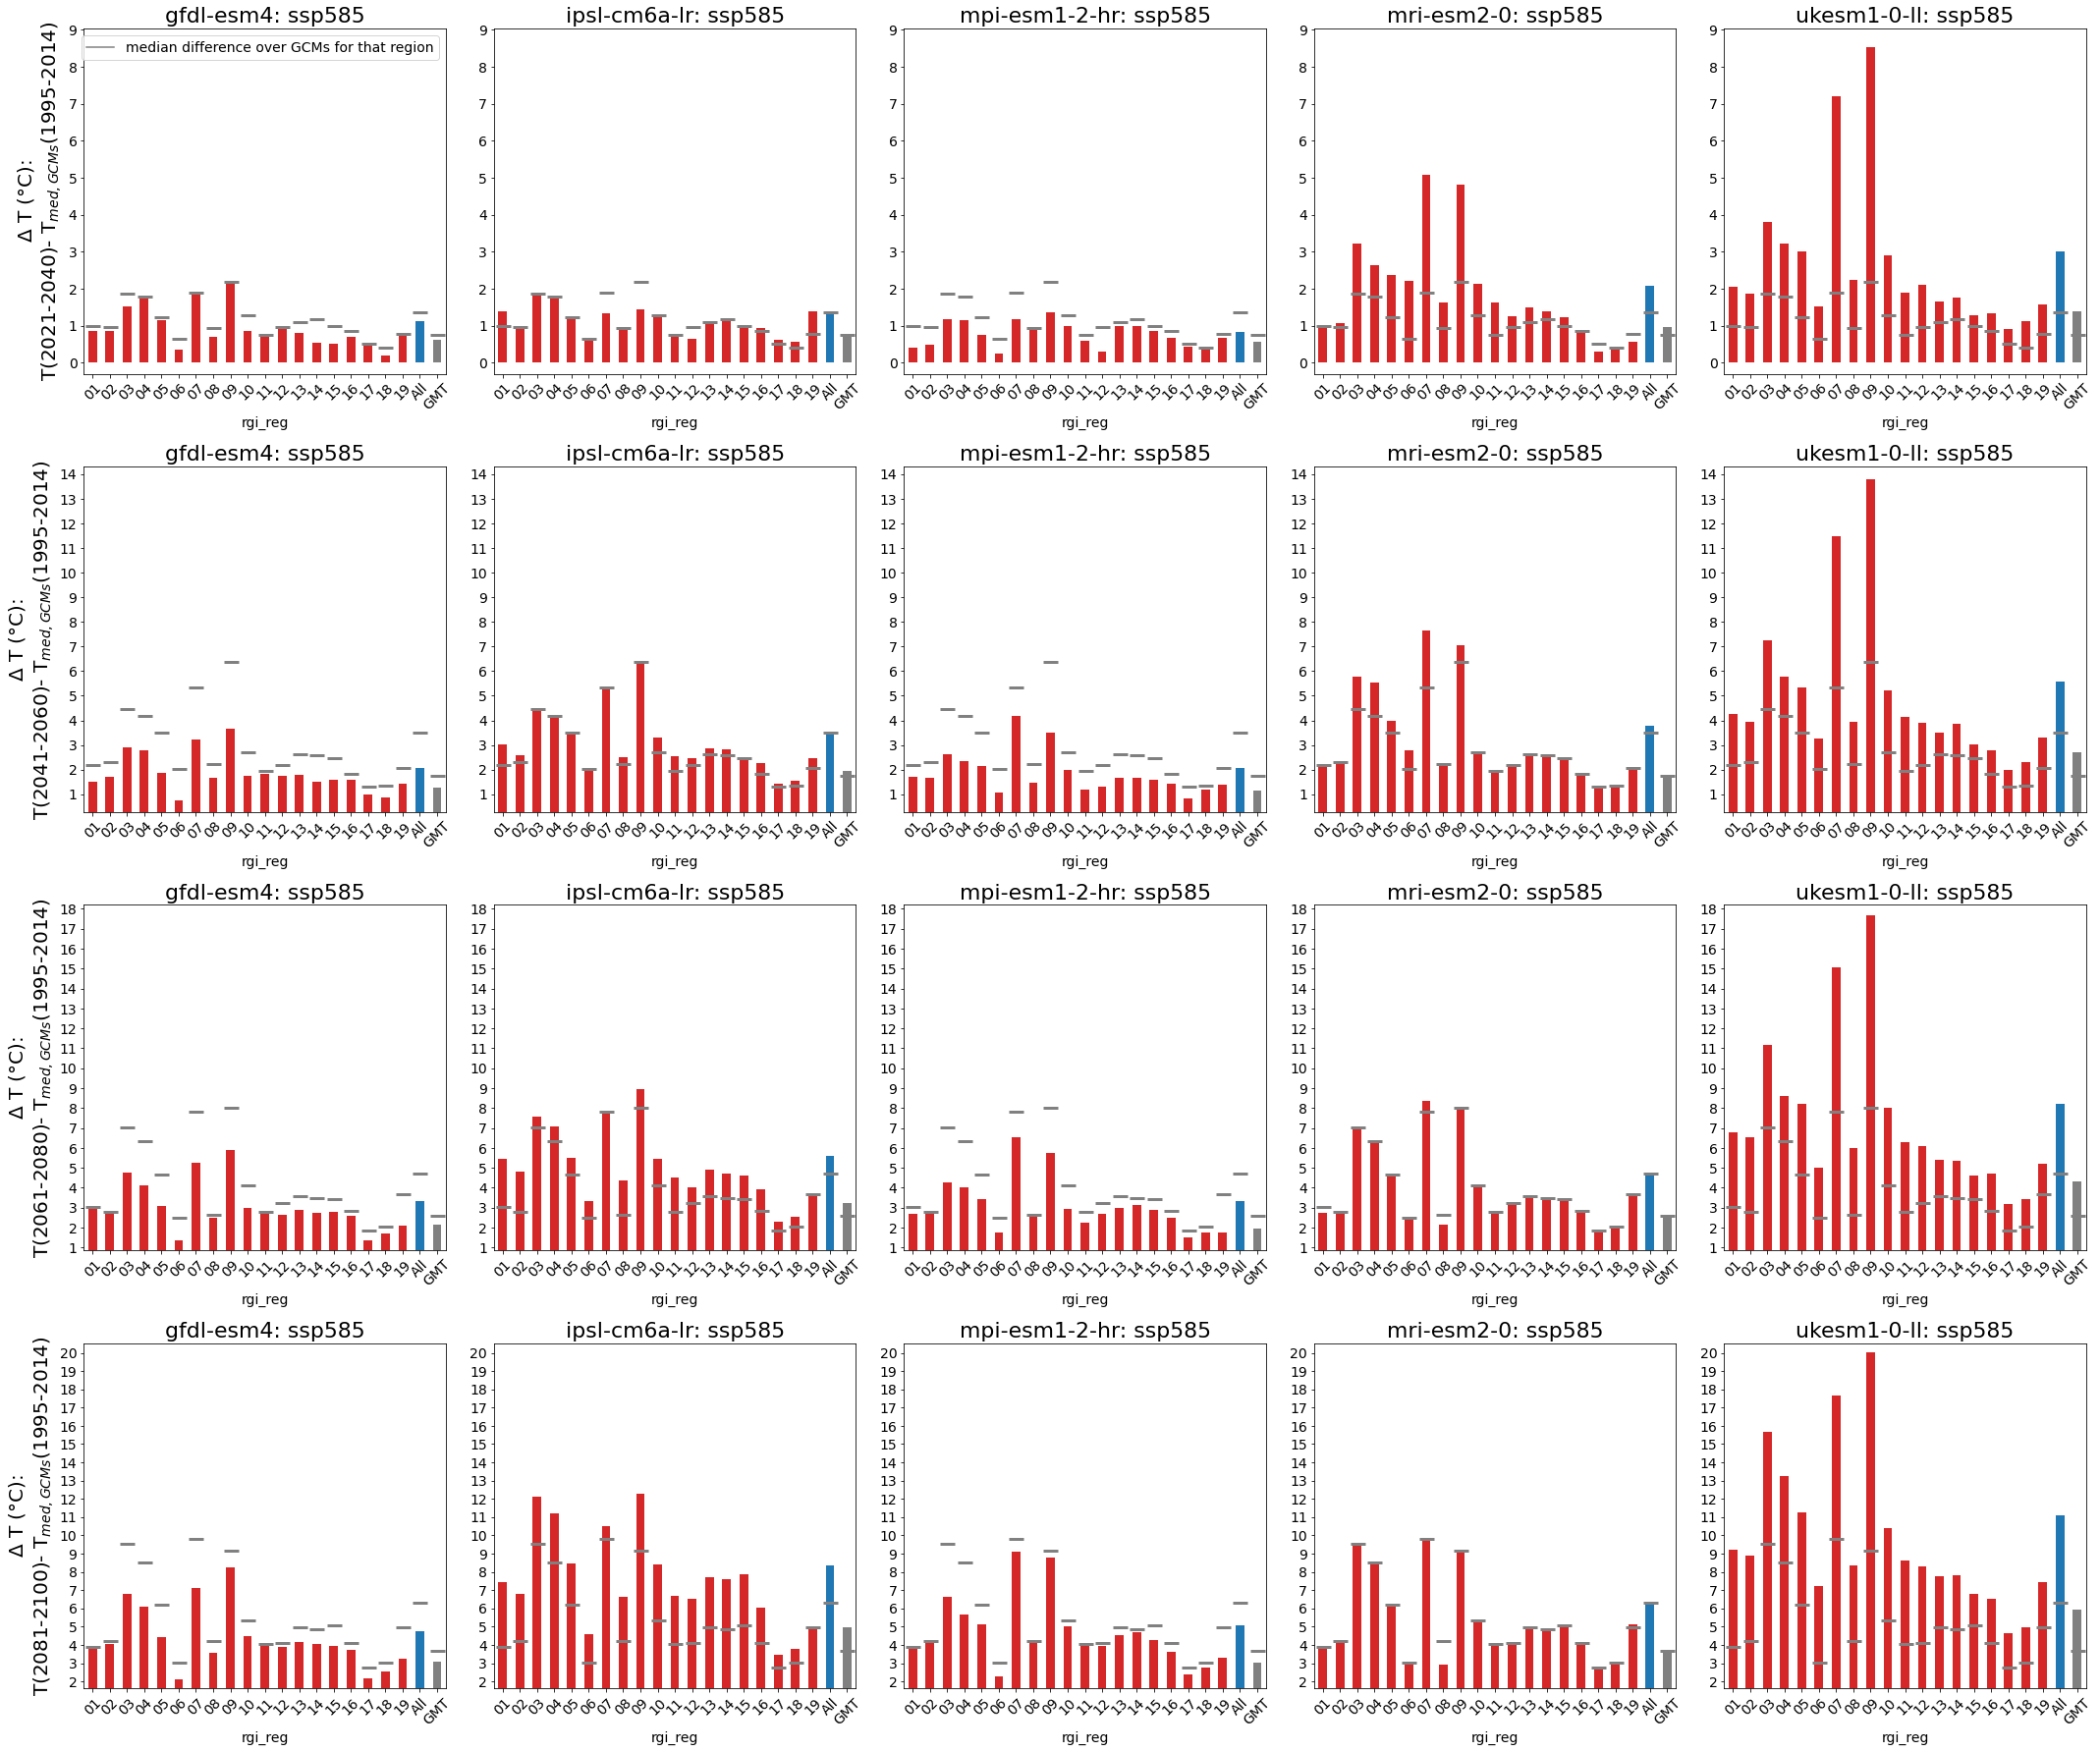

In [231]:
# just drop GMT mean diff
_pd_temp_diff_1995_2014 = pd_temp_diff_1995_2014.loc[pd_temp_diff_1995_2014.rgi_reg!='GMT_mean_diff']
var = 'deltaT to median GCM'

from matplotlib.lines import Line2D
plt.rcParams.update({'font.size': 14})

for scenario in scenarios:
    plt.figure(figsize=(30, 25))
    j=0
    for exp_time in exp_times[4:]:
        period = f'{exp_time}-{exp_time+19}'
        pd_sel = _pd_temp_diff_1995_2014.loc[(_pd_temp_diff_1995_2014.period==period) & (_pd_temp_diff_1995_2014.ssp==scenario)] 
        for gcm in gcms:
            plt.subplot(4,5,j+1)
            ax = plt.gca()
            # for every GCM the same ... 
            plt.plot(pd_sel.groupby('rgi_reg').median().index,
                     pd_sel.groupby('rgi_reg').median()[var].values,
                     marker='_', ls = '',
                     color='grey', markersize=15, markeredgewidth=3,
                     label='median difference over GCMs for that region')

            if gcm==gcms[0]:
                plt.ylabel('$\Delta$ T (°C):\nT({}-{})'.format(exp_time, exp_time+19)+r'- T$_{med,GCMs}$(1995-2014)', fontsize=20)
            plt.yticks(np.arange(-14,22,1))
            maxi = pd_sel[var].max() +0.5
            mini = pd_sel[var].min() -0.5
            plt.ylim(mini, maxi)
            plt.title('{}: {}'.format(gcm,scenario), fontsize=22)
            ax.tick_params(axis='x',which='minor',bottom=False)
            if j==0:
                ax.legend([Line2D([0], [0], color='grey', marker='_', markersize=12, markeredgewidth=3)],
                      ['median difference over GCMs for that region'], fontsize=22)
            pd_sel_gcm = pd_sel.loc[pd_sel.gcm==gcm]
            pd_sel_gcm.index = pd_sel_gcm.rgi_reg
            pd_sel_gcm[var].plot(ax=ax, kind='bar', rot=45, color=['C3'] * 19+ [ 'C0','grey']) 
            j+=1
    plt.tight_layout()
    plt.savefig('plots_isimip3b_analysis/plot_isimip3b_glaciers_deltaT_expfuture-ref_{}_ref_median_GCM.pdf'.format(scenario))

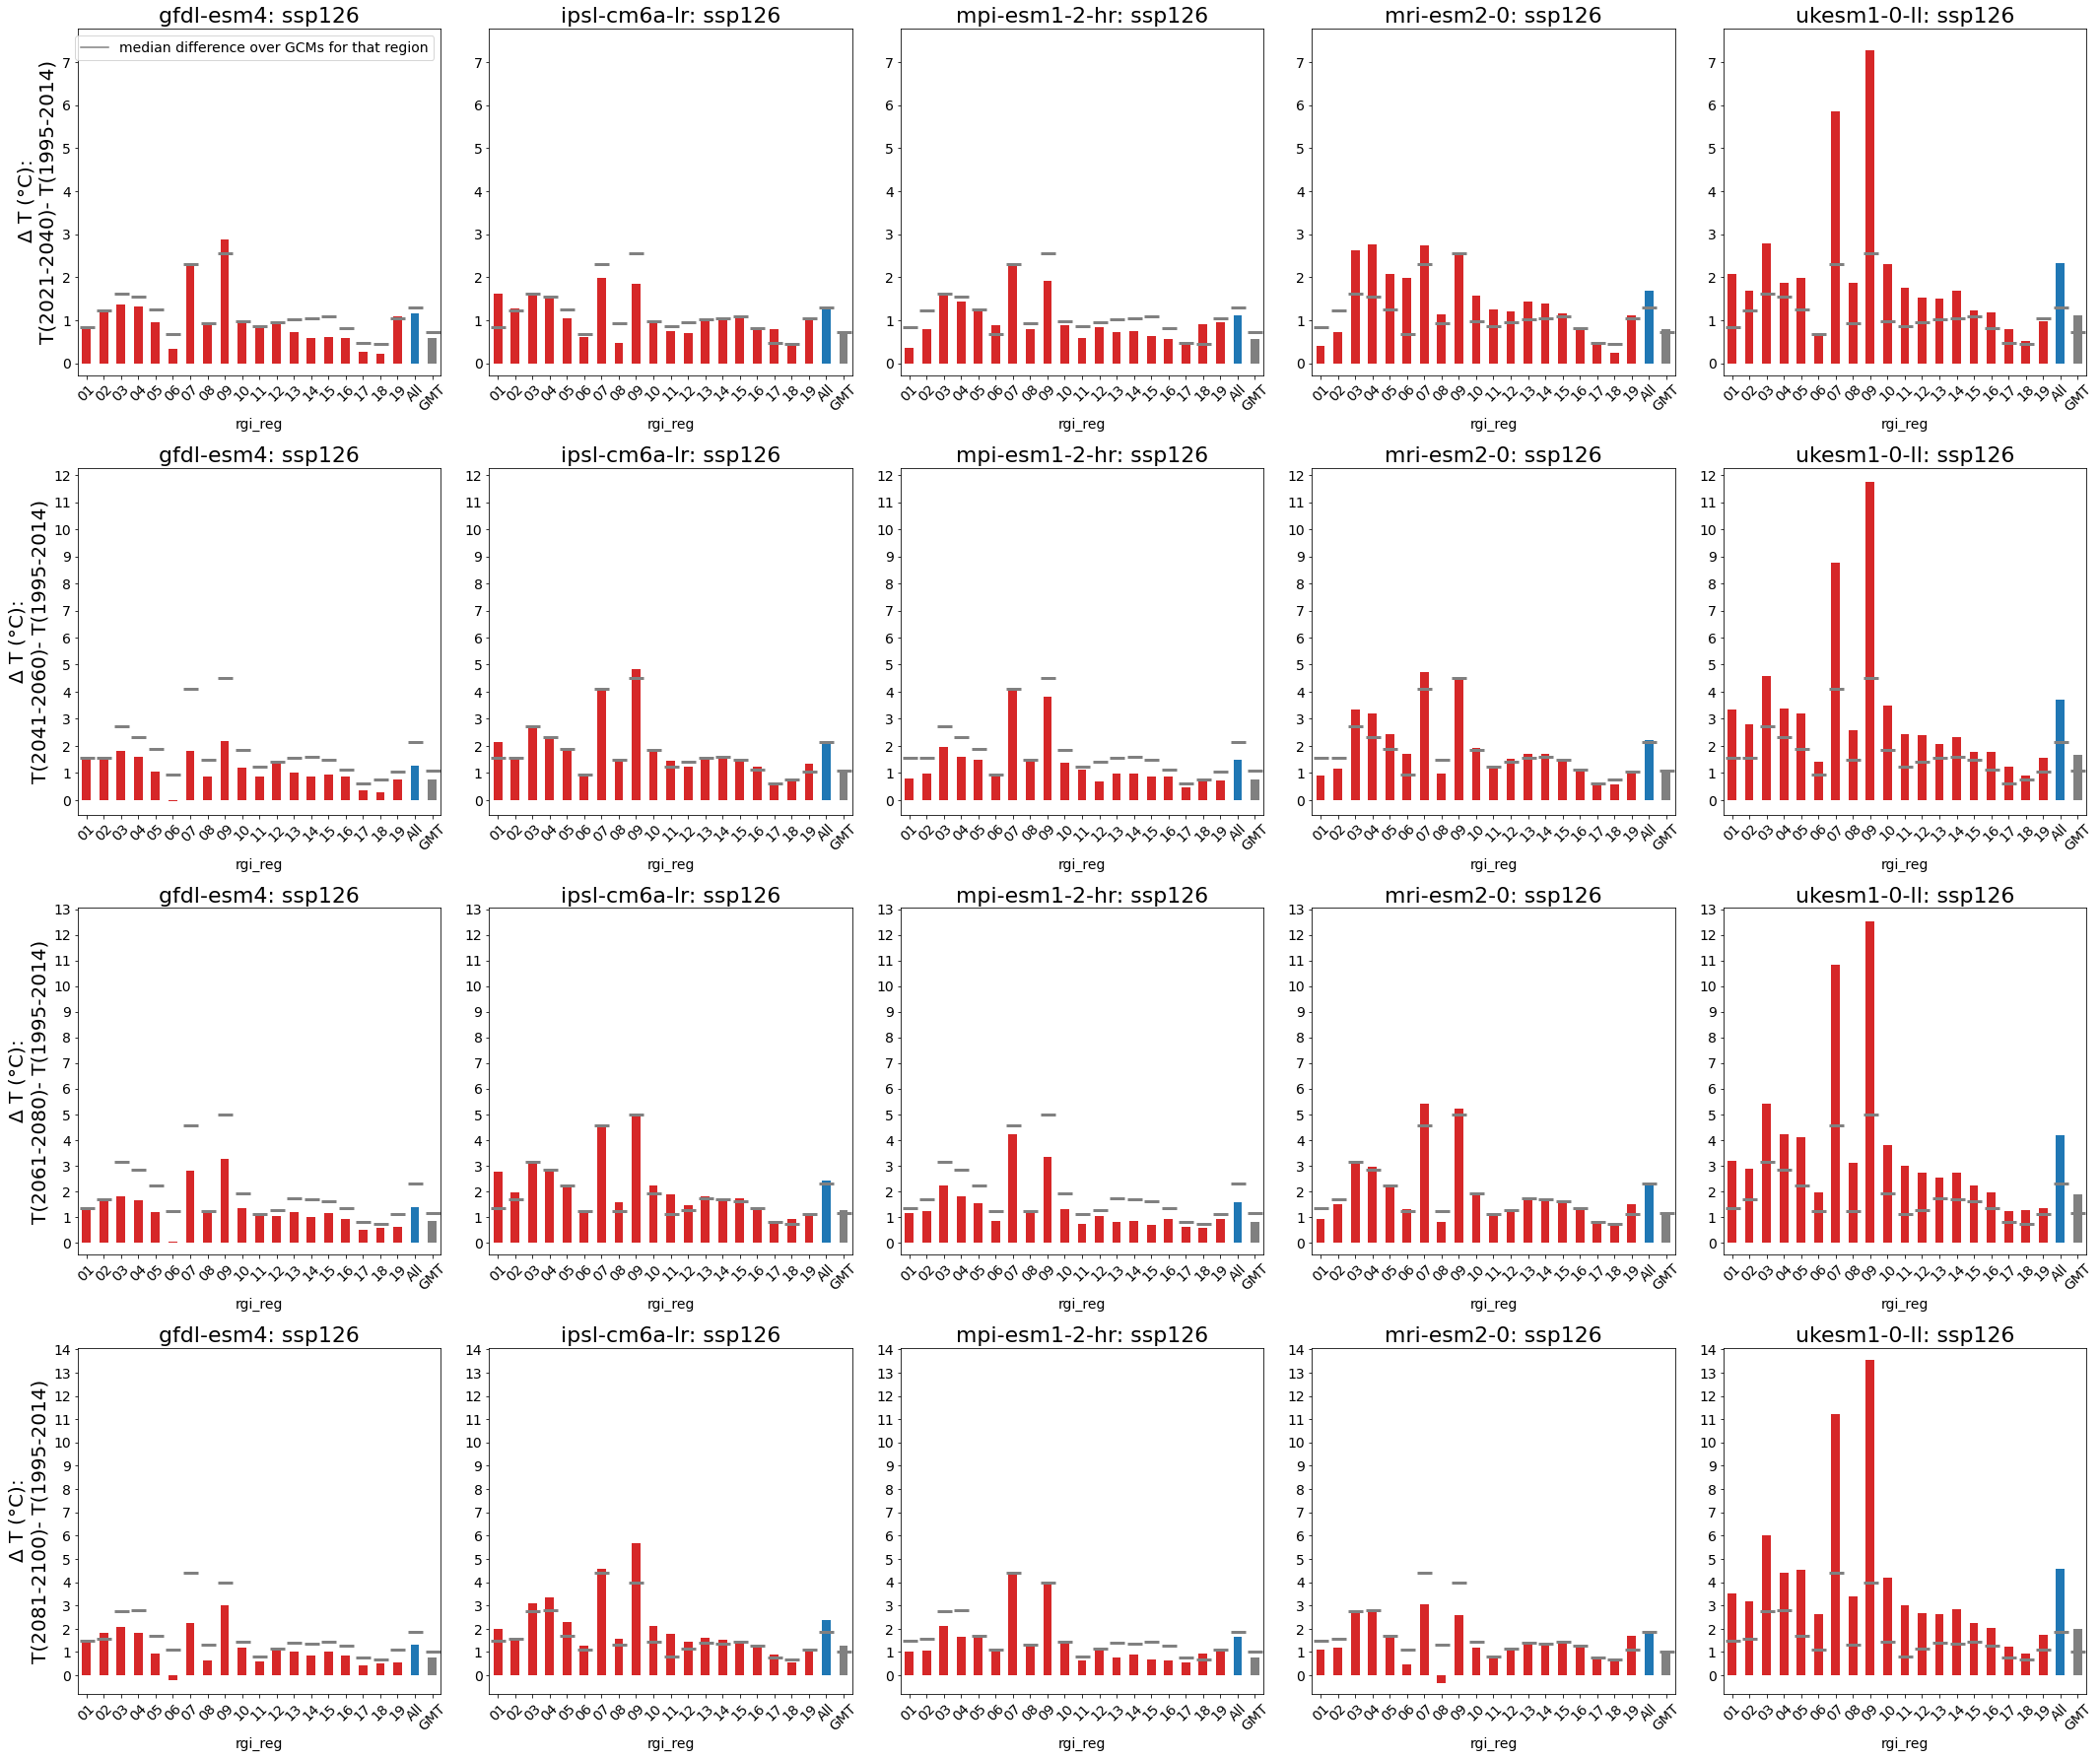

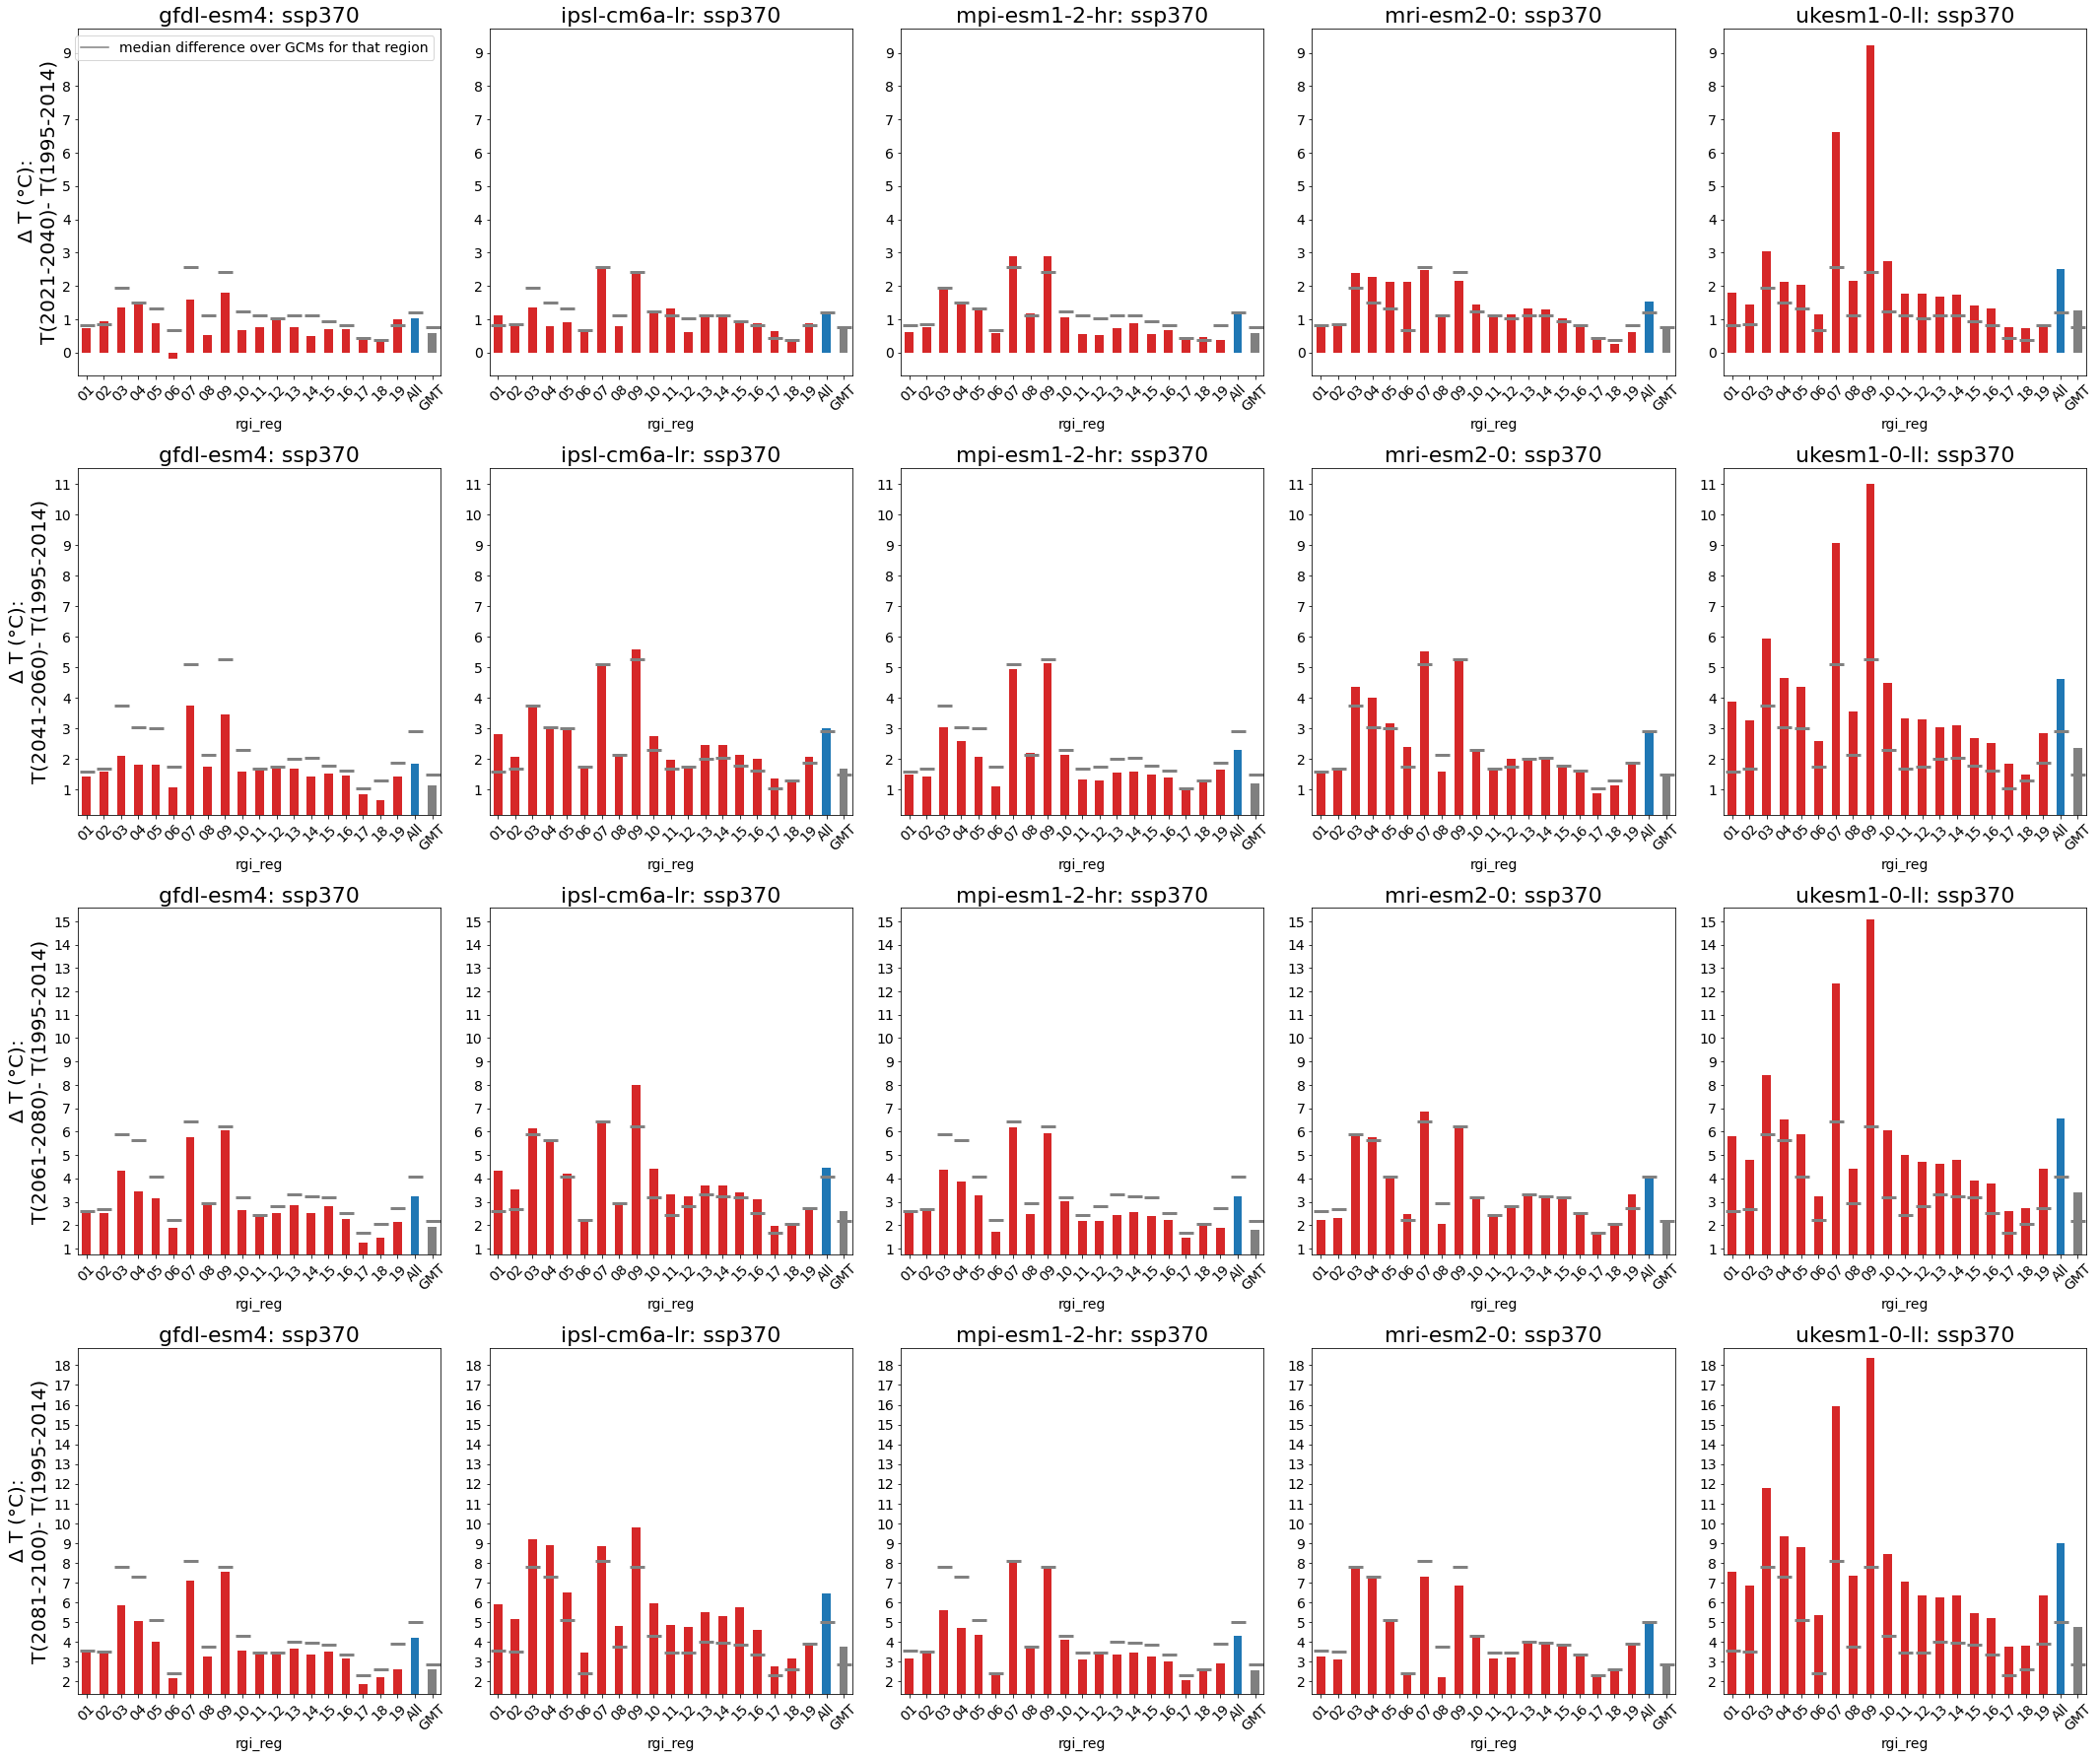

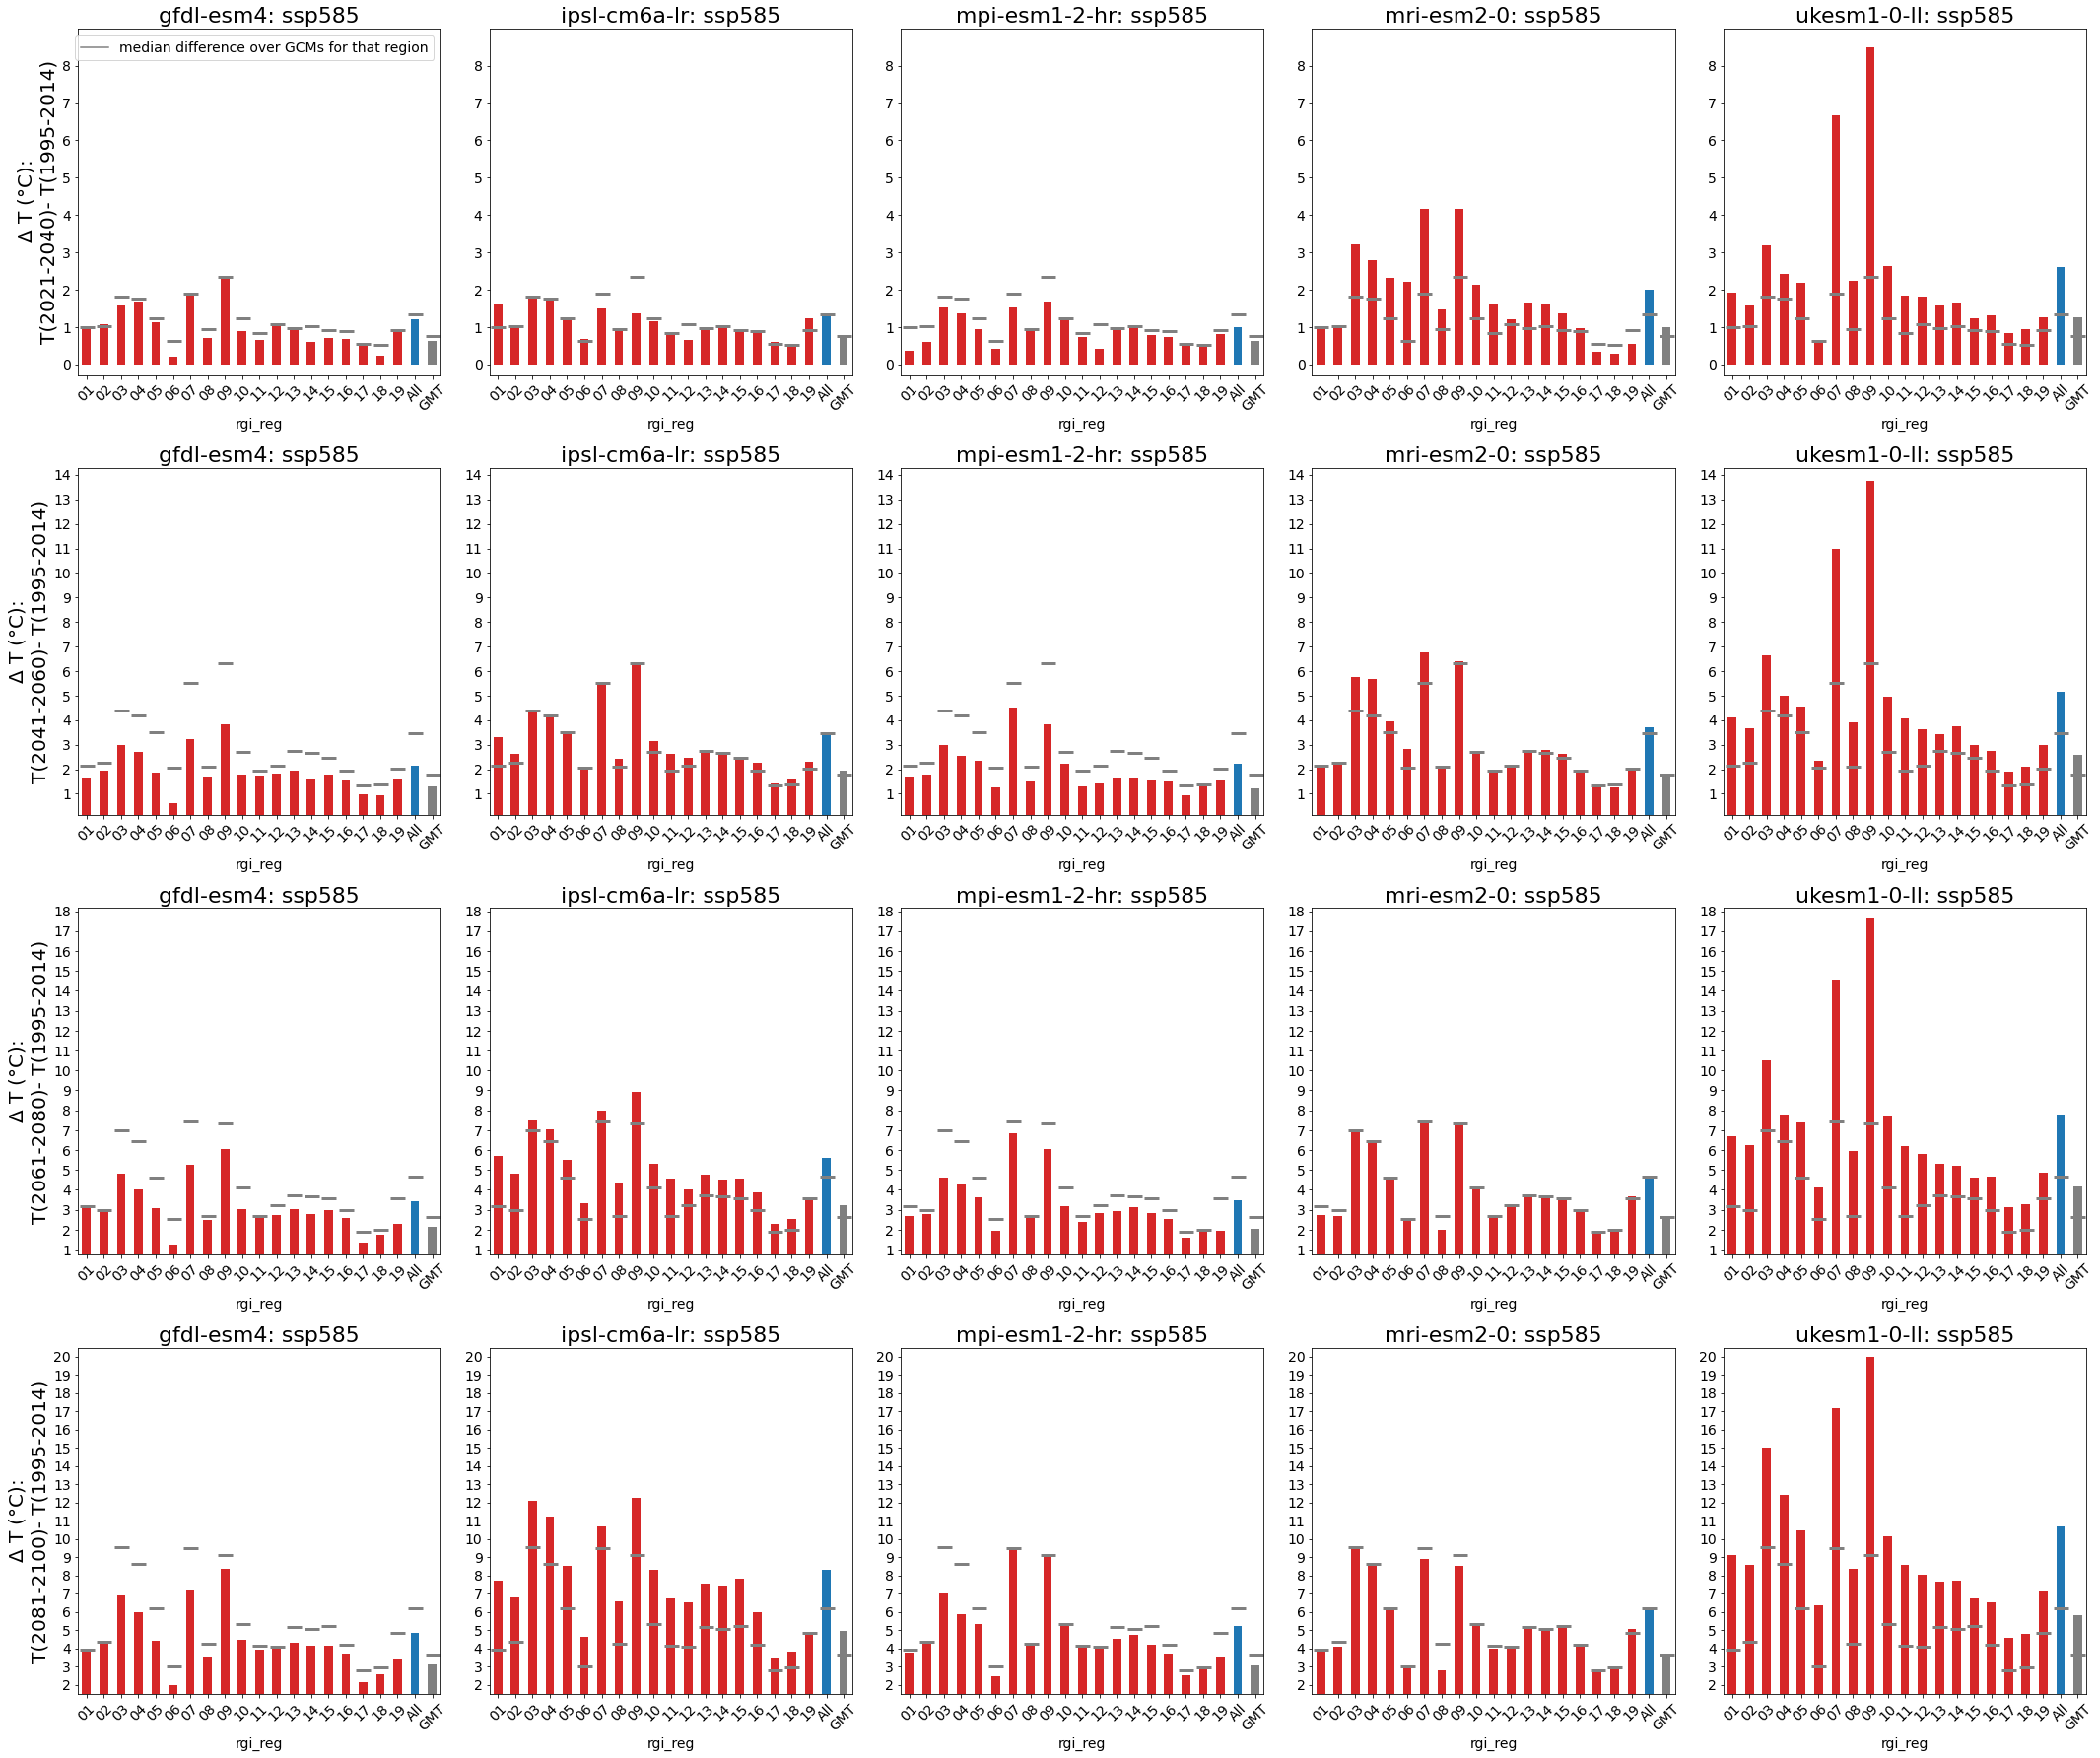

In [230]:
# just drop GMT mean diff
_pd_temp_diff_1995_2014 = pd_temp_diff_1995_2014.loc[pd_temp_diff_1995_2014.rgi_reg!='GMT_mean_diff']
var = 'deltaT to same GCM'

from matplotlib.lines import Line2D
plt.rcParams.update({'font.size': 14})

for scenario in scenarios:
    plt.figure(figsize=(30, 25))
    j=0
    for exp_time in exp_times[4:]:
        period = f'{exp_time}-{exp_time+19}'
        #taf_d = taf_e[exp_time]
        pd_sel = _pd_temp_diff_1995_2014.loc[(_pd_temp_diff_1995_2014.period==period) & (_pd_temp_diff_1995_2014.ssp==scenario)] 

        for gcm in gcms:
            plt.subplot(4,5,j+1)
            ax = plt.gca()
            # for every GCM the same ... 
            plt.plot(pd_sel.groupby('rgi_reg').median().index,
                     pd_sel.groupby('rgi_reg').median()[var].values,
                     marker='_', ls = '',
                     color='grey', markersize=15, markeredgewidth=3,
                     label='median difference over GCMs for that region')

            if gcm==gcms[0]:
                plt.ylabel('$\Delta$ T (°C):\nT({}-{})'.format(exp_time, exp_time+19)+r'- T(1995-2014)', fontsize=20)
            plt.yticks(np.arange(-14,22,1))
            maxi = pd_sel[var].max() +0.5
            mini = pd_sel[var].min() -0.5
            plt.ylim(mini, maxi)
            plt.title('{}: {}'.format(gcm,scenario), fontsize=22)
            ax.tick_params(axis='x',which='minor',bottom=False)
            if j==0:
                ax.legend([Line2D([0], [0], color='grey', marker='_', markersize=12, markeredgewidth=3)],
                      ['median difference over GCMs for that region'], fontsize=22)
            pd_sel_gcm = pd_sel.loc[pd_sel.gcm==gcm]
            pd_sel_gcm.index = pd_sel_gcm.rgi_reg
            pd_sel_gcm[var].plot(ax=ax, kind='bar', rot=45, color=['C3'] * 19+ [ 'C0','grey']) 
            j+=1
    plt.tight_layout()
    plt.savefig('plots_isimip3b_analysis/plot_isimip3b_glaciers_deltaT_expfuture-ref_{}_ref_same_GCM.pdf'.format(scenario))

### Past temperature changes from time periods

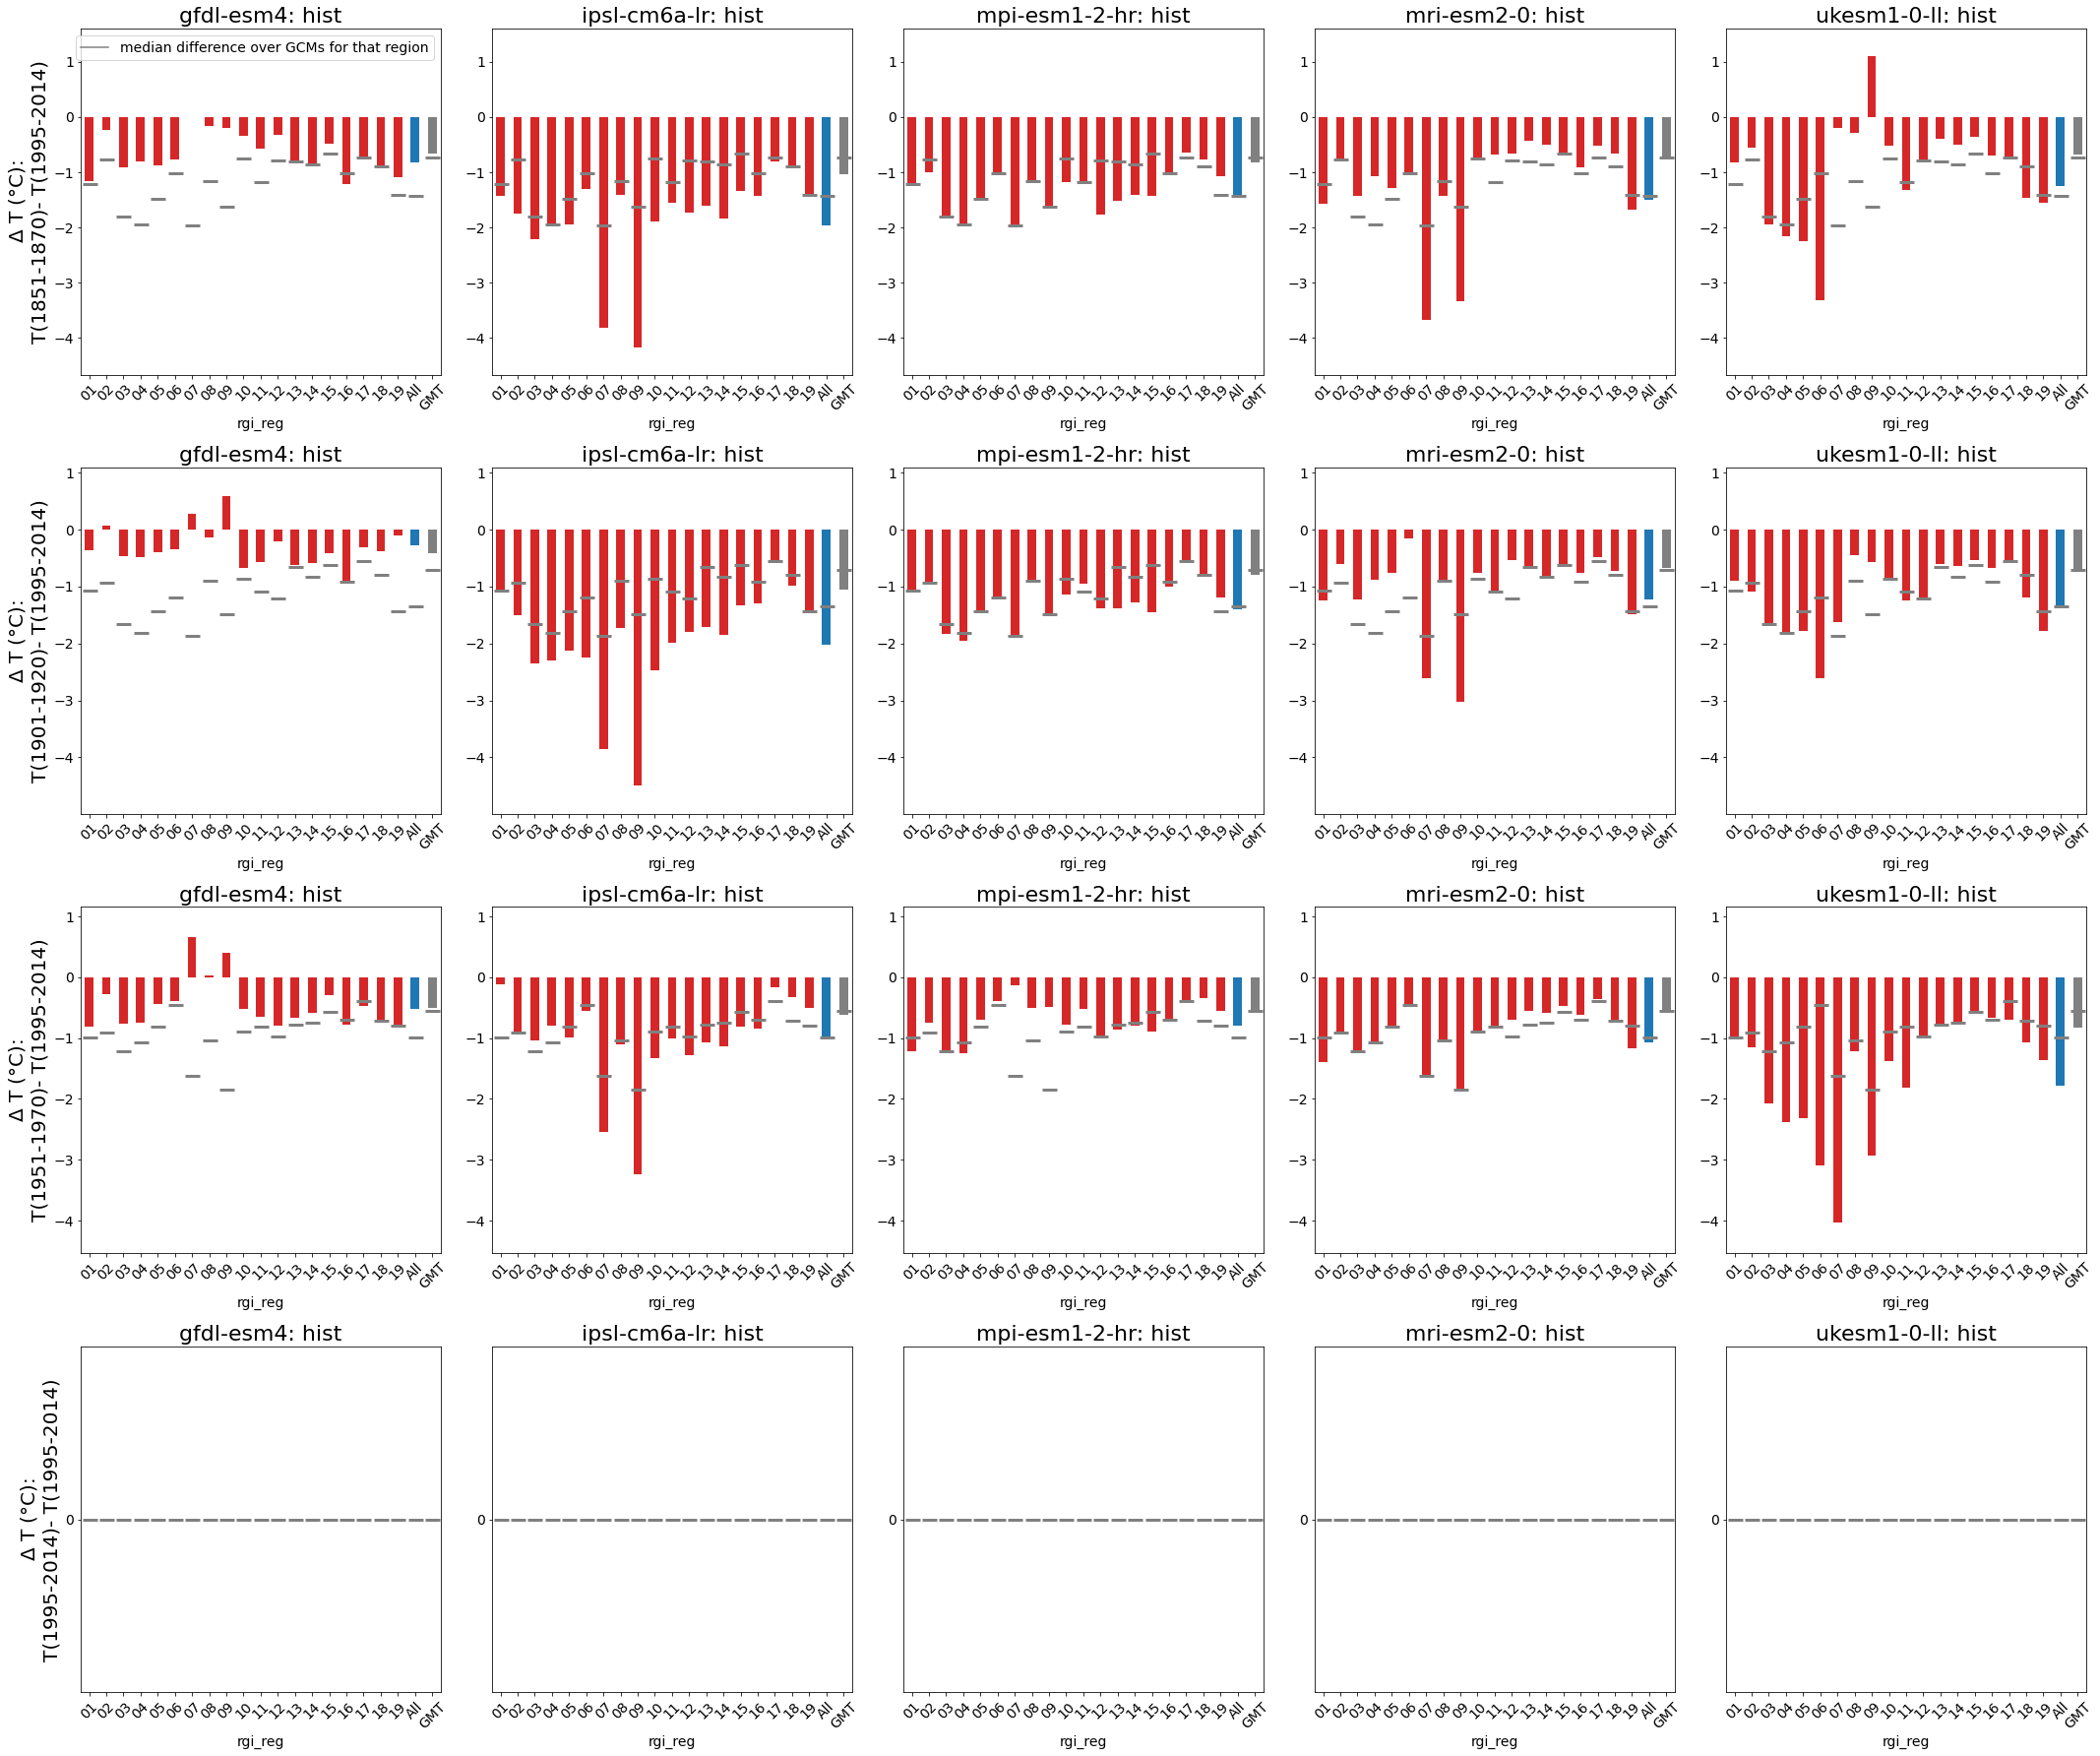

In [228]:
var = 'deltaT to same GCM'


# just drop GMT mean diff
_pd_temp_diff_1995_2014 = pd_temp_diff_1995_2014.loc[pd_temp_diff_1995_2014.rgi_reg!='GMT_mean_diff']

from matplotlib.lines import Line2D
plt.rcParams.update({'font.size': 14})
#rgi_regs_clim = ['GMT','All','01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11',
#       '12', '13', '14', '15', '16', '17', '18', '19']
scenario = 'hist'
plt.figure(figsize=(30, 25))
j=0
for exp_time in exp_times[:4]:
    period = f'{exp_time}-{exp_time+19}'
    #taf_d = taf_e[exp_time]
    pd_sel = _pd_temp_diff_1995_2014.loc[(_pd_temp_diff_1995_2014.period==period) & (_pd_temp_diff_1995_2014.ssp==scenario)] 
    pd_sel.index = pd_sel.rgi_reg
    #pd_sel = pd_sel.loc[rgi_regs_clim]
    pd_sel = pd_sel.reset_index(drop=True)
    for gcm in gcms:
        plt.subplot(4,5,j+1)
        ax = plt.gca()
        # for every GCM the same ... 
        plt.plot(pd_sel.groupby('rgi_reg').median().index,
                 pd_sel.groupby('rgi_reg').median()[var].values,
                 marker='_', ls = '',
                 color='grey', markersize=15, markeredgewidth=3,
                 label='median difference over GCMs for that region')

        if gcm==gcms[0]:
            plt.ylabel('$\Delta$ T (°C):\nT({}-{})'.format(exp_time, exp_time+19)+r'- T(1995-2014)', fontsize=20)
        plt.yticks(np.arange(-14,22,1))
        maxi = pd_sel[var].max() +0.5
        mini = pd_sel[var].min() -0.5
        plt.ylim(mini, maxi)
        plt.title('{}: {}'.format(gcm,scenario), fontsize=22)
        ax.tick_params(axis='x',which='minor',bottom=False)
        if j==0:
            ax.legend([Line2D([0], [0], color='grey', marker='_', markersize=12, markeredgewidth=3)],
                  ['median difference over GCMs for that region'], fontsize=22)
        pd_sel_gcm = pd_sel.loc[pd_sel.gcm==gcm]
        pd_sel_gcm.index = pd_sel_gcm.rgi_reg
        pd_sel_gcm[var].plot(ax=ax, kind='bar', rot=45, color=['C3'] * 19+ [ 'C0','grey']) 
        j+=1
plt.tight_layout()
plt.savefig('plots_isimip3b_analysis/plot_isimip3b_glaciers_deltaT_exppast-ref_same_GCM.pdf')

- here, we see the "zero" difference, when using the "to same GCM" climate change approach for period "1995-2014"

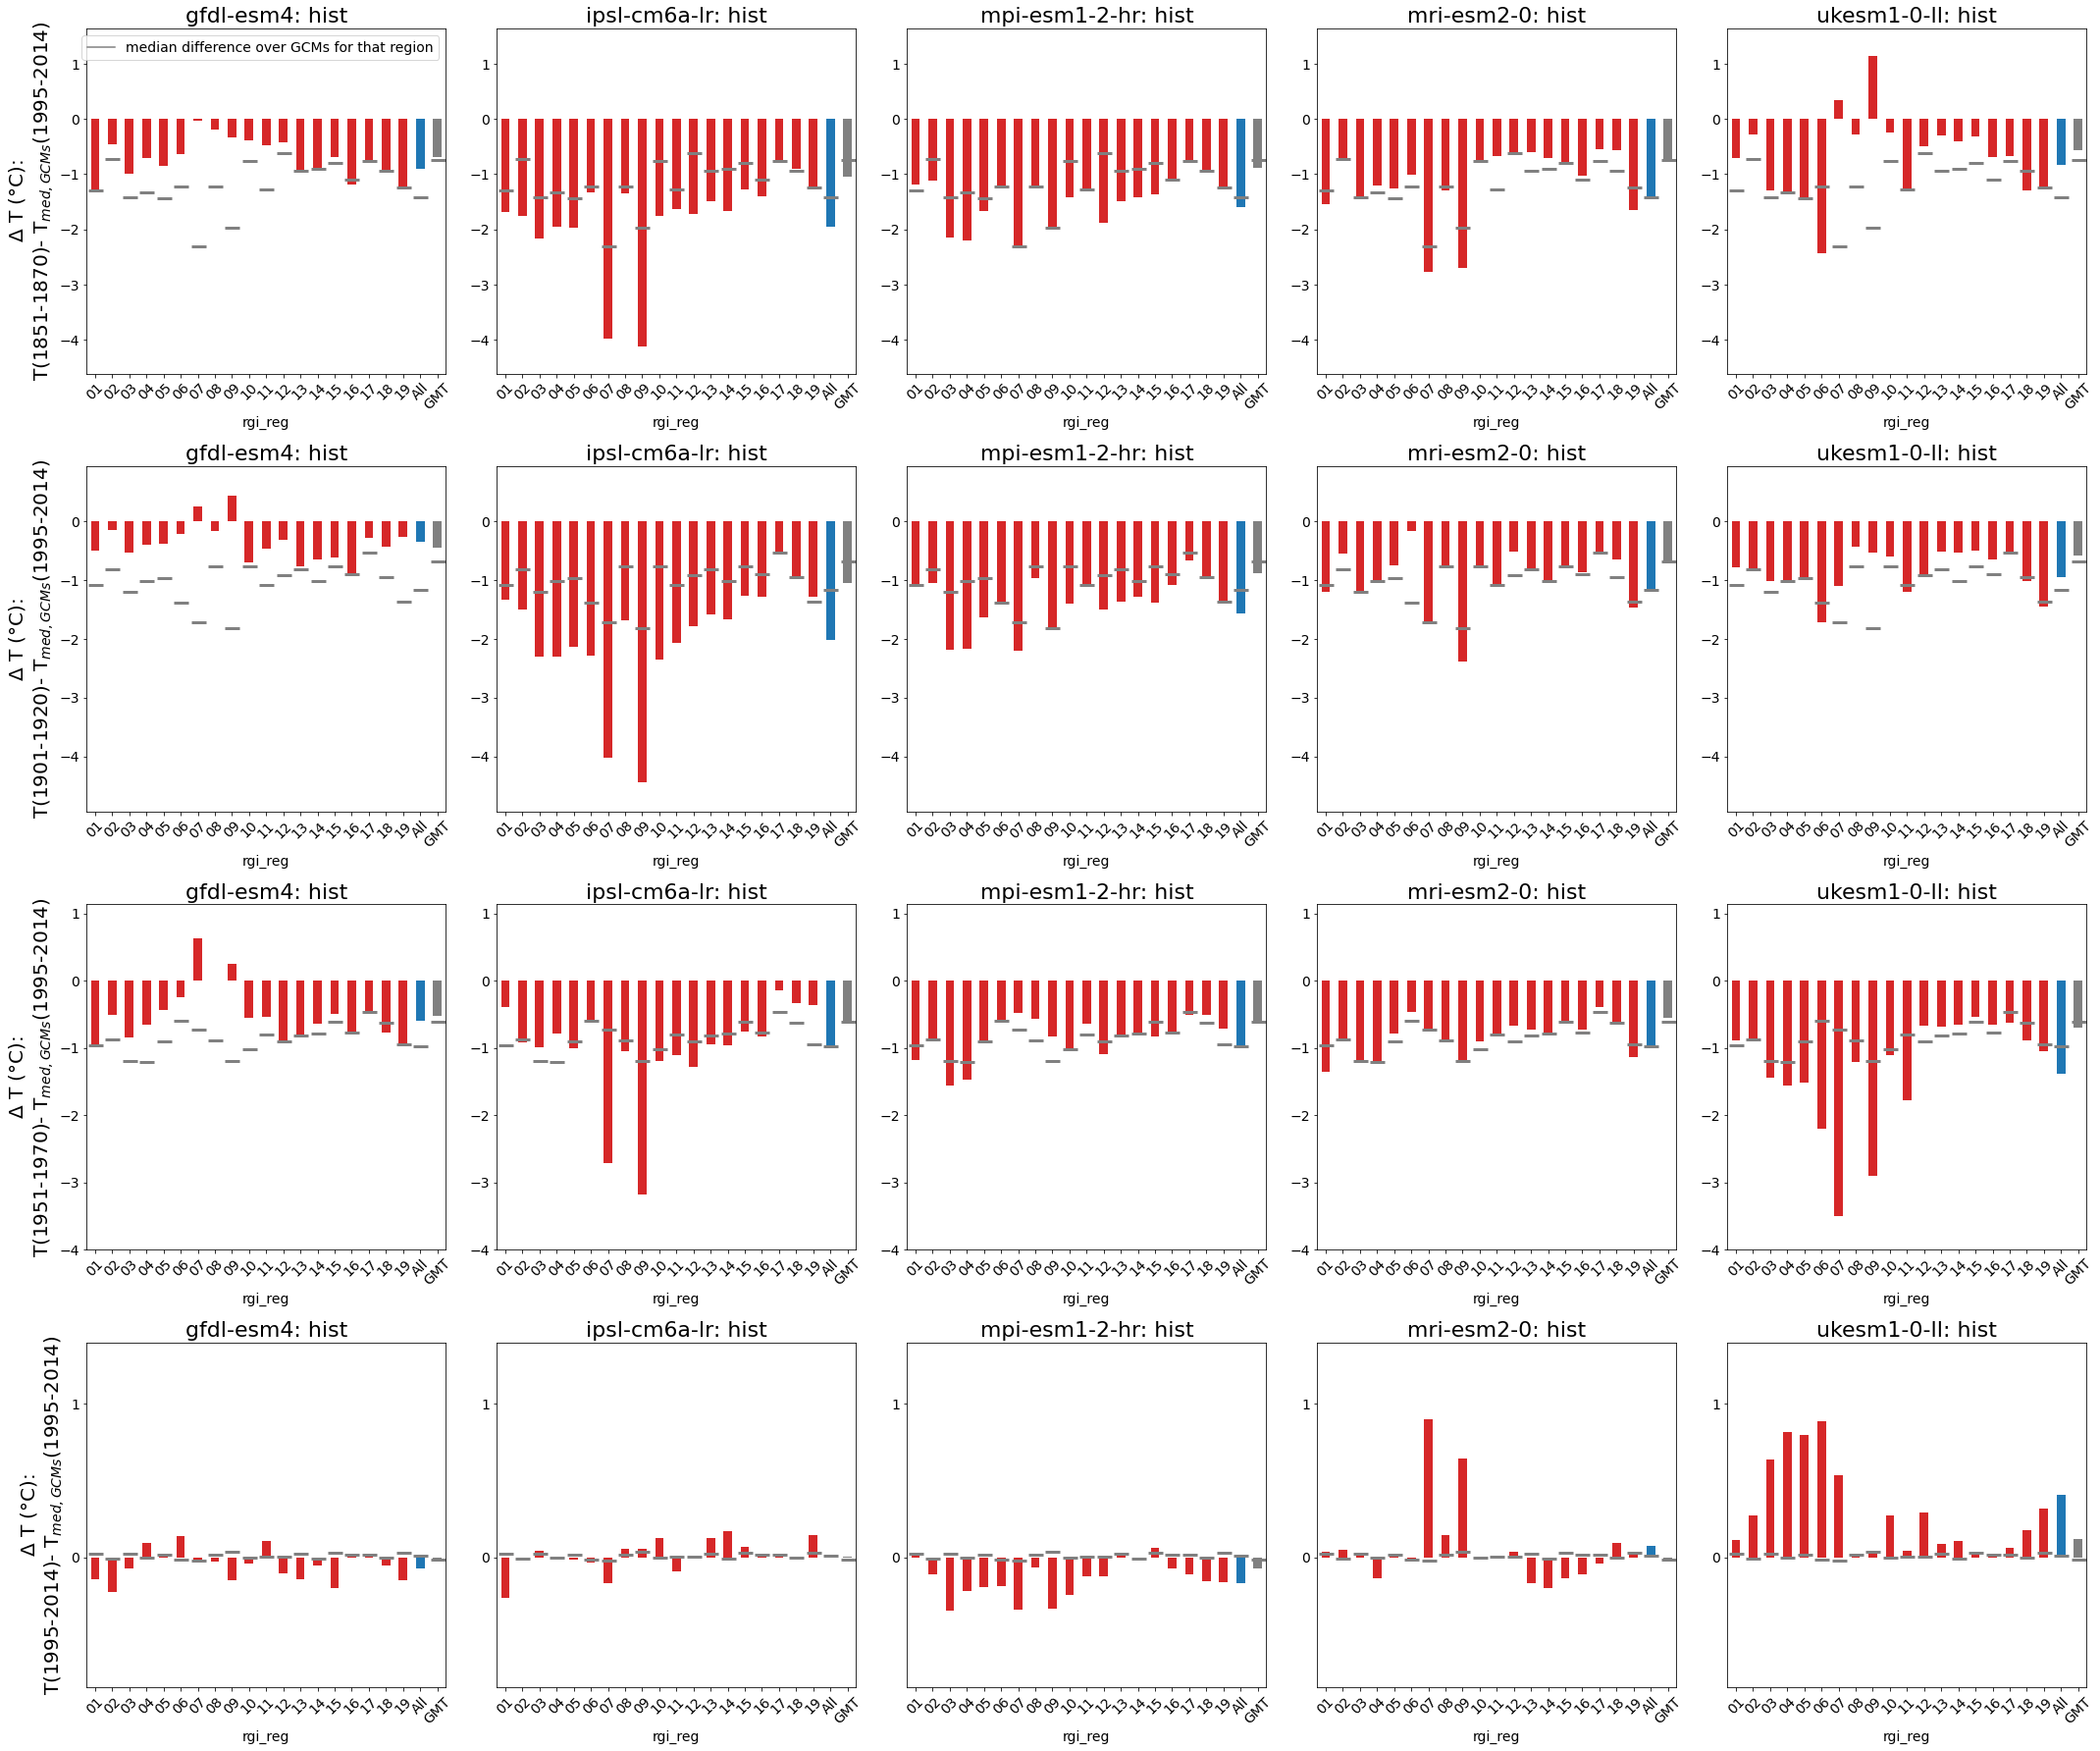

In [229]:
var = 'deltaT to median GCM'


# just drop GMT mean diff
_pd_temp_diff_1995_2014 = pd_temp_diff_1995_2014.loc[pd_temp_diff_1995_2014.rgi_reg!='GMT_mean_diff']

from matplotlib.lines import Line2D
plt.rcParams.update({'font.size': 14})

scenario = 'hist'
plt.figure(figsize=(30, 25))
j=0
for exp_time in exp_times[:4]:
    period = f'{exp_time}-{exp_time+19}'
    #taf_d = taf_e[exp_time]
    pd_sel = _pd_temp_diff_1995_2014.loc[(_pd_temp_diff_1995_2014.period==period) & (_pd_temp_diff_1995_2014.ssp==scenario)] 
    for gcm in gcms:
        plt.subplot(4,5,j+1)
        ax = plt.gca()
        # for every GCM the same ... 
        plt.plot(pd_sel.groupby('rgi_reg').median().index,
                 pd_sel.groupby('rgi_reg').median()[var].values,
                 marker='_', ls = '',
                 color='grey', markersize=15, markeredgewidth=3,
                 label='median difference over GCMs for that region')

        if gcm==gcms[0]:
            plt.ylabel('$\Delta$ T (°C):\nT({}-{})'.format(exp_time, exp_time+19)+r'- T$_{med,GCMs}$(1995-2014)', fontsize=20)

        plt.yticks(np.arange(-14,22,1))
        maxi = pd_sel[var].max() +0.5
        mini = pd_sel[var].min() -0.5
        plt.ylim(mini, maxi)
        plt.title('{}: {}'.format(gcm,scenario), fontsize=22)
        ax.tick_params(axis='x',which='minor',bottom=False)
        if j==0:
            ax.legend([Line2D([0], [0], color='grey', marker='_', markersize=12, markeredgewidth=3)],
                  ['median difference over GCMs for that region'], fontsize=22)
        pd_sel_gcm = pd_sel.loc[pd_sel.gcm==gcm]
        pd_sel_gcm.index = pd_sel_gcm.rgi_reg
        pd_sel_gcm[var].plot(ax=ax, kind='bar', rot=45, color=['C3'] * 19+ [ 'C0','grey']) 
        j+=1
plt.tight_layout()
plt.savefig('plots_isimip3b_analysis/plot_isimip3b_glaciers_deltaT_exppast-ref_median_GCM.pdf')


## mean over all GCMs

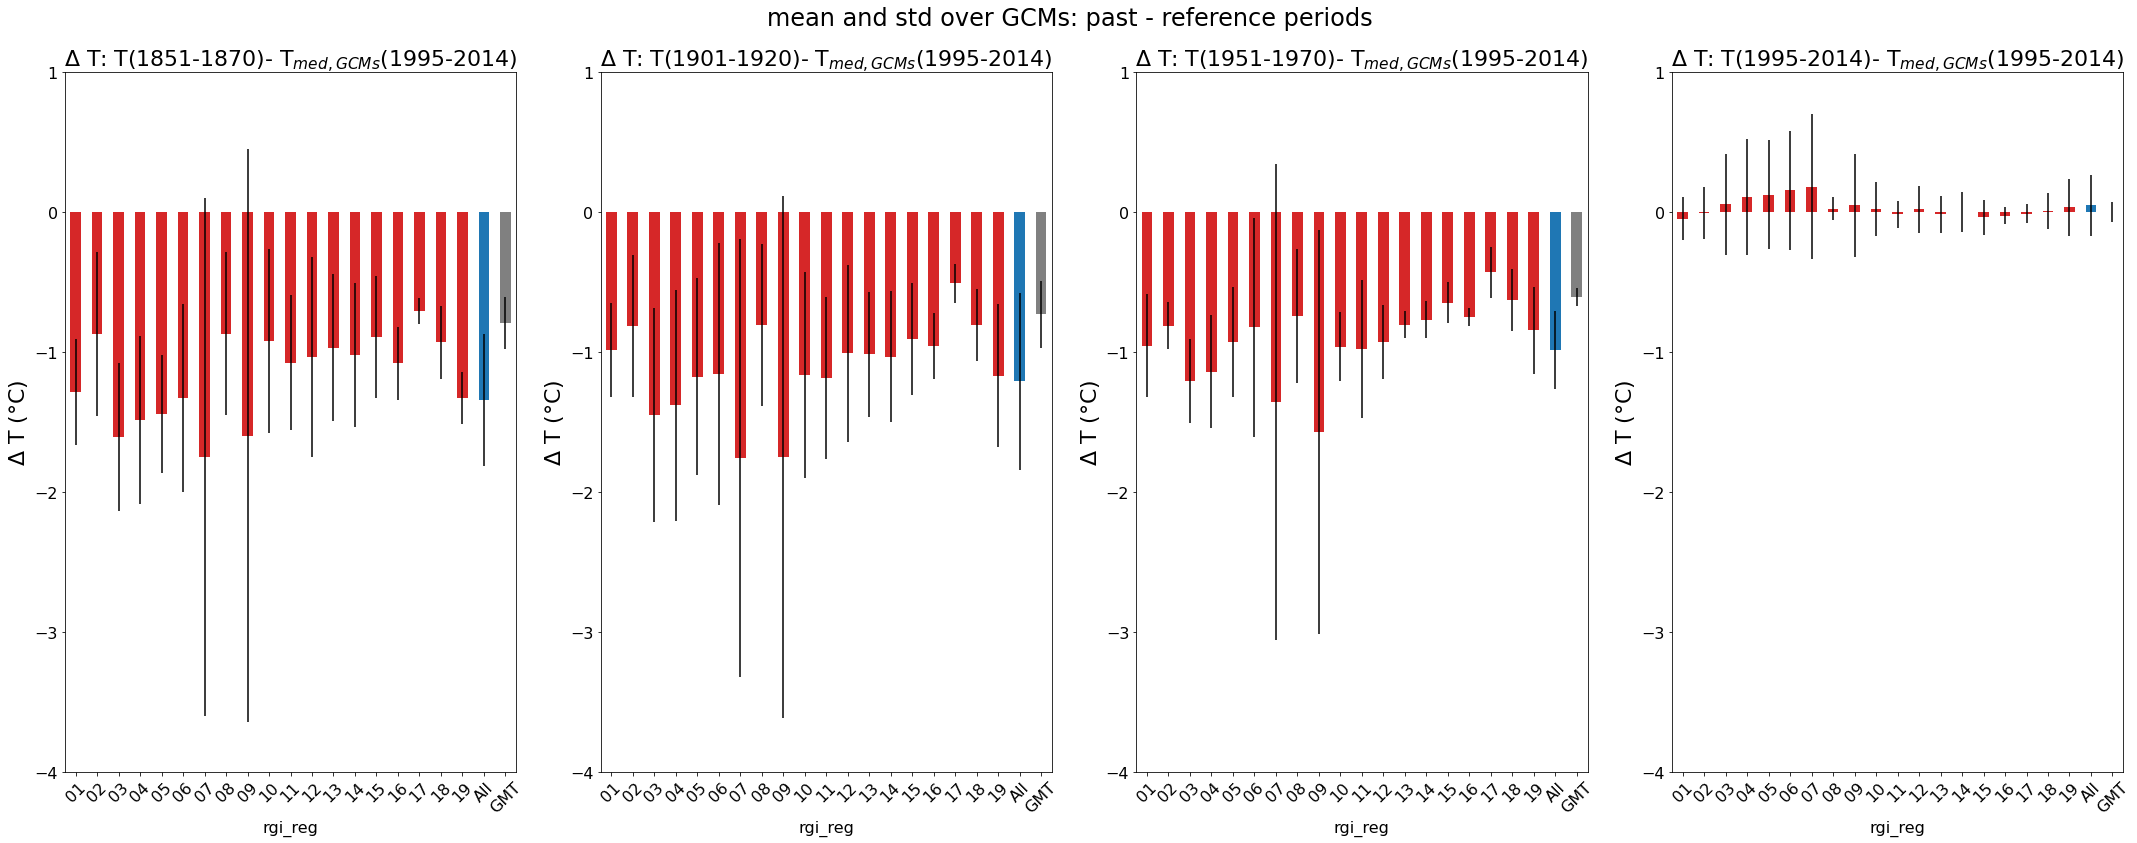

In [240]:
var = 'deltaT to median GCM'


# just drop GMT mean diff
_pd_temp_diff_1995_2014 = pd_temp_diff_1995_2014.loc[pd_temp_diff_1995_2014.rgi_reg!='GMT_mean_diff']

from matplotlib.lines import Line2D
plt.rcParams.update({'font.size': 16})

scenario = 'hist'
plt.figure(figsize=(30, 12))
plt.suptitle('mean and std over GCMs: past - reference periods',
                  fontsize=24)
j=0
for exp_time in exp_times[:4]:
    period = f'{exp_time}-{exp_time+19}'
    #taf_d = taf_e[exp_time]
    pd_sel = _pd_temp_diff_1995_2014.loc[(_pd_temp_diff_1995_2014.period==period) & (_pd_temp_diff_1995_2014.ssp==scenario)] 
    plt.subplot(1,4,j+1)
    ax = plt.gca()
    plt.title('$\Delta$ T: T({}-{})'.format(exp_time, exp_time+19)+r'- T$_{med,GCMs}$(1995-2014)', fontsize=22)
    plt.ylabel('$\Delta$ T (°C)', fontsize=22)

    plt.yticks(np.arange(-14,22,1))
    plt.ylim(-4, 1)
    ax.tick_params(axis='x',which='minor',bottom=False)
    yerr = pd_sel.groupby('rgi_reg').std()[var].values
    pd_sel.groupby('rgi_reg').mean()[var].plot(ax=ax, kind='bar', rot=45,
                                                            color=['C3'] * 19+['C0','grey'],
                                               yerr=yerr);

    j+=1
plt.tight_layout()
plt.savefig('plots_isimip3b_analysis/plot_isimip3b_glaciers_deltaT_exppast-ref_mean_std_ref_median_GCM.pdf')


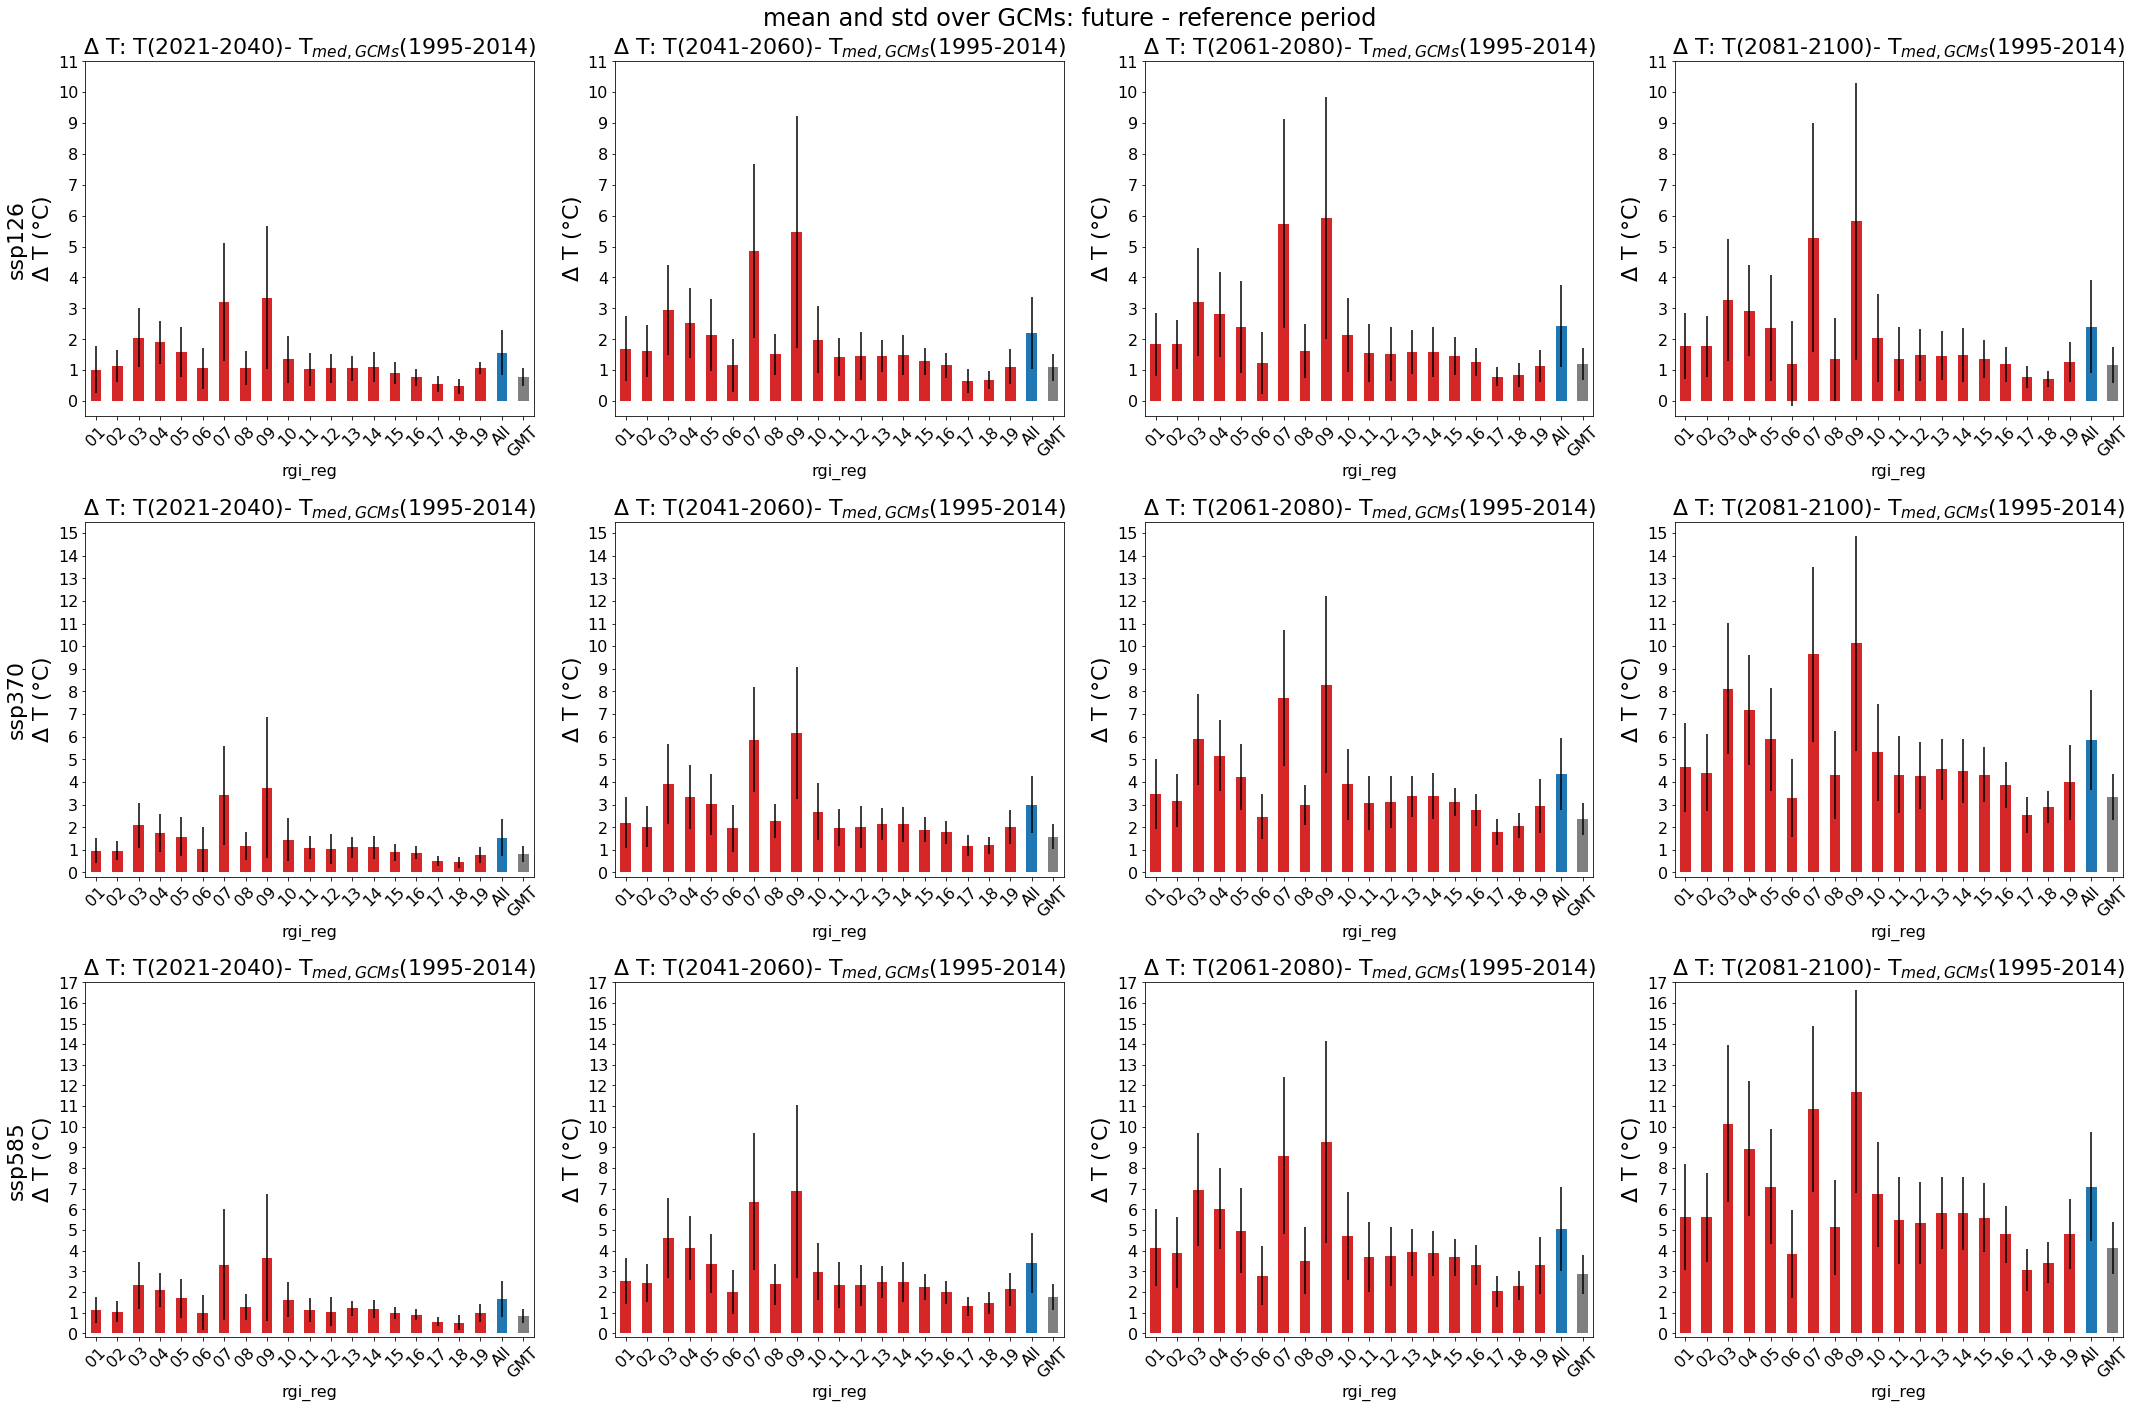

In [242]:
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(30, 20))

j=0
plt.suptitle('mean and std over GCMs: future - reference period',
                  fontsize=24)
for scenario in scenarios:
    for exp_time in exp_times[4:]:
        period = f'{exp_time}-{exp_time+19}'

        pd_sel = _pd_temp_diff_1995_2014.loc[(_pd_temp_diff_1995_2014.period==period) & (_pd_temp_diff_1995_2014.ssp==scenario)] 

        plt.subplot(3,4,j+1)
        ax = plt.gca()
        if exp_time == exp_times[4]:
            plt.ylabel('{}\n$\Delta$ T (°C)'.format(scenario), fontsize=22)
        else:
            plt.ylabel('$\Delta$ T (°C)'.format(scenario), fontsize=22)
        plt.title('$\Delta$ T: T({}-{})'.format(exp_time, exp_time+19)+r'- T$_{med,GCMs}$(1995-2014)', fontsize=22)
        plt.yticks(np.arange(-14,22,1))
        if scenario == 'ssp126':
            plt.ylim(-0.5, 11)
        elif scenario =='ssp370':
            plt.ylim(-0.2, 15.5)
        else:
            plt.ylim(-0.2, 17)
        ax.tick_params(axis='x',which='minor',bottom=False)
        yerr = pd_sel.groupby('rgi_reg').std()[var].values
        pd_sel.groupby('rgi_reg').mean()[var].plot(ax=ax, kind='bar', rot=45,
                                                                color=['C3'] * 19+['C0','grey'],
                                                   yerr=yerr);
        j+=1
plt.tight_layout()
plt.savefig('plots_isimip3b_analysis/plot_isimip3b_glaciers_deltaT_expfuture-ref_mean_std_ref_median_GCM.pdf')



## gridpoint temperature warming per GMT warming for each experimental period

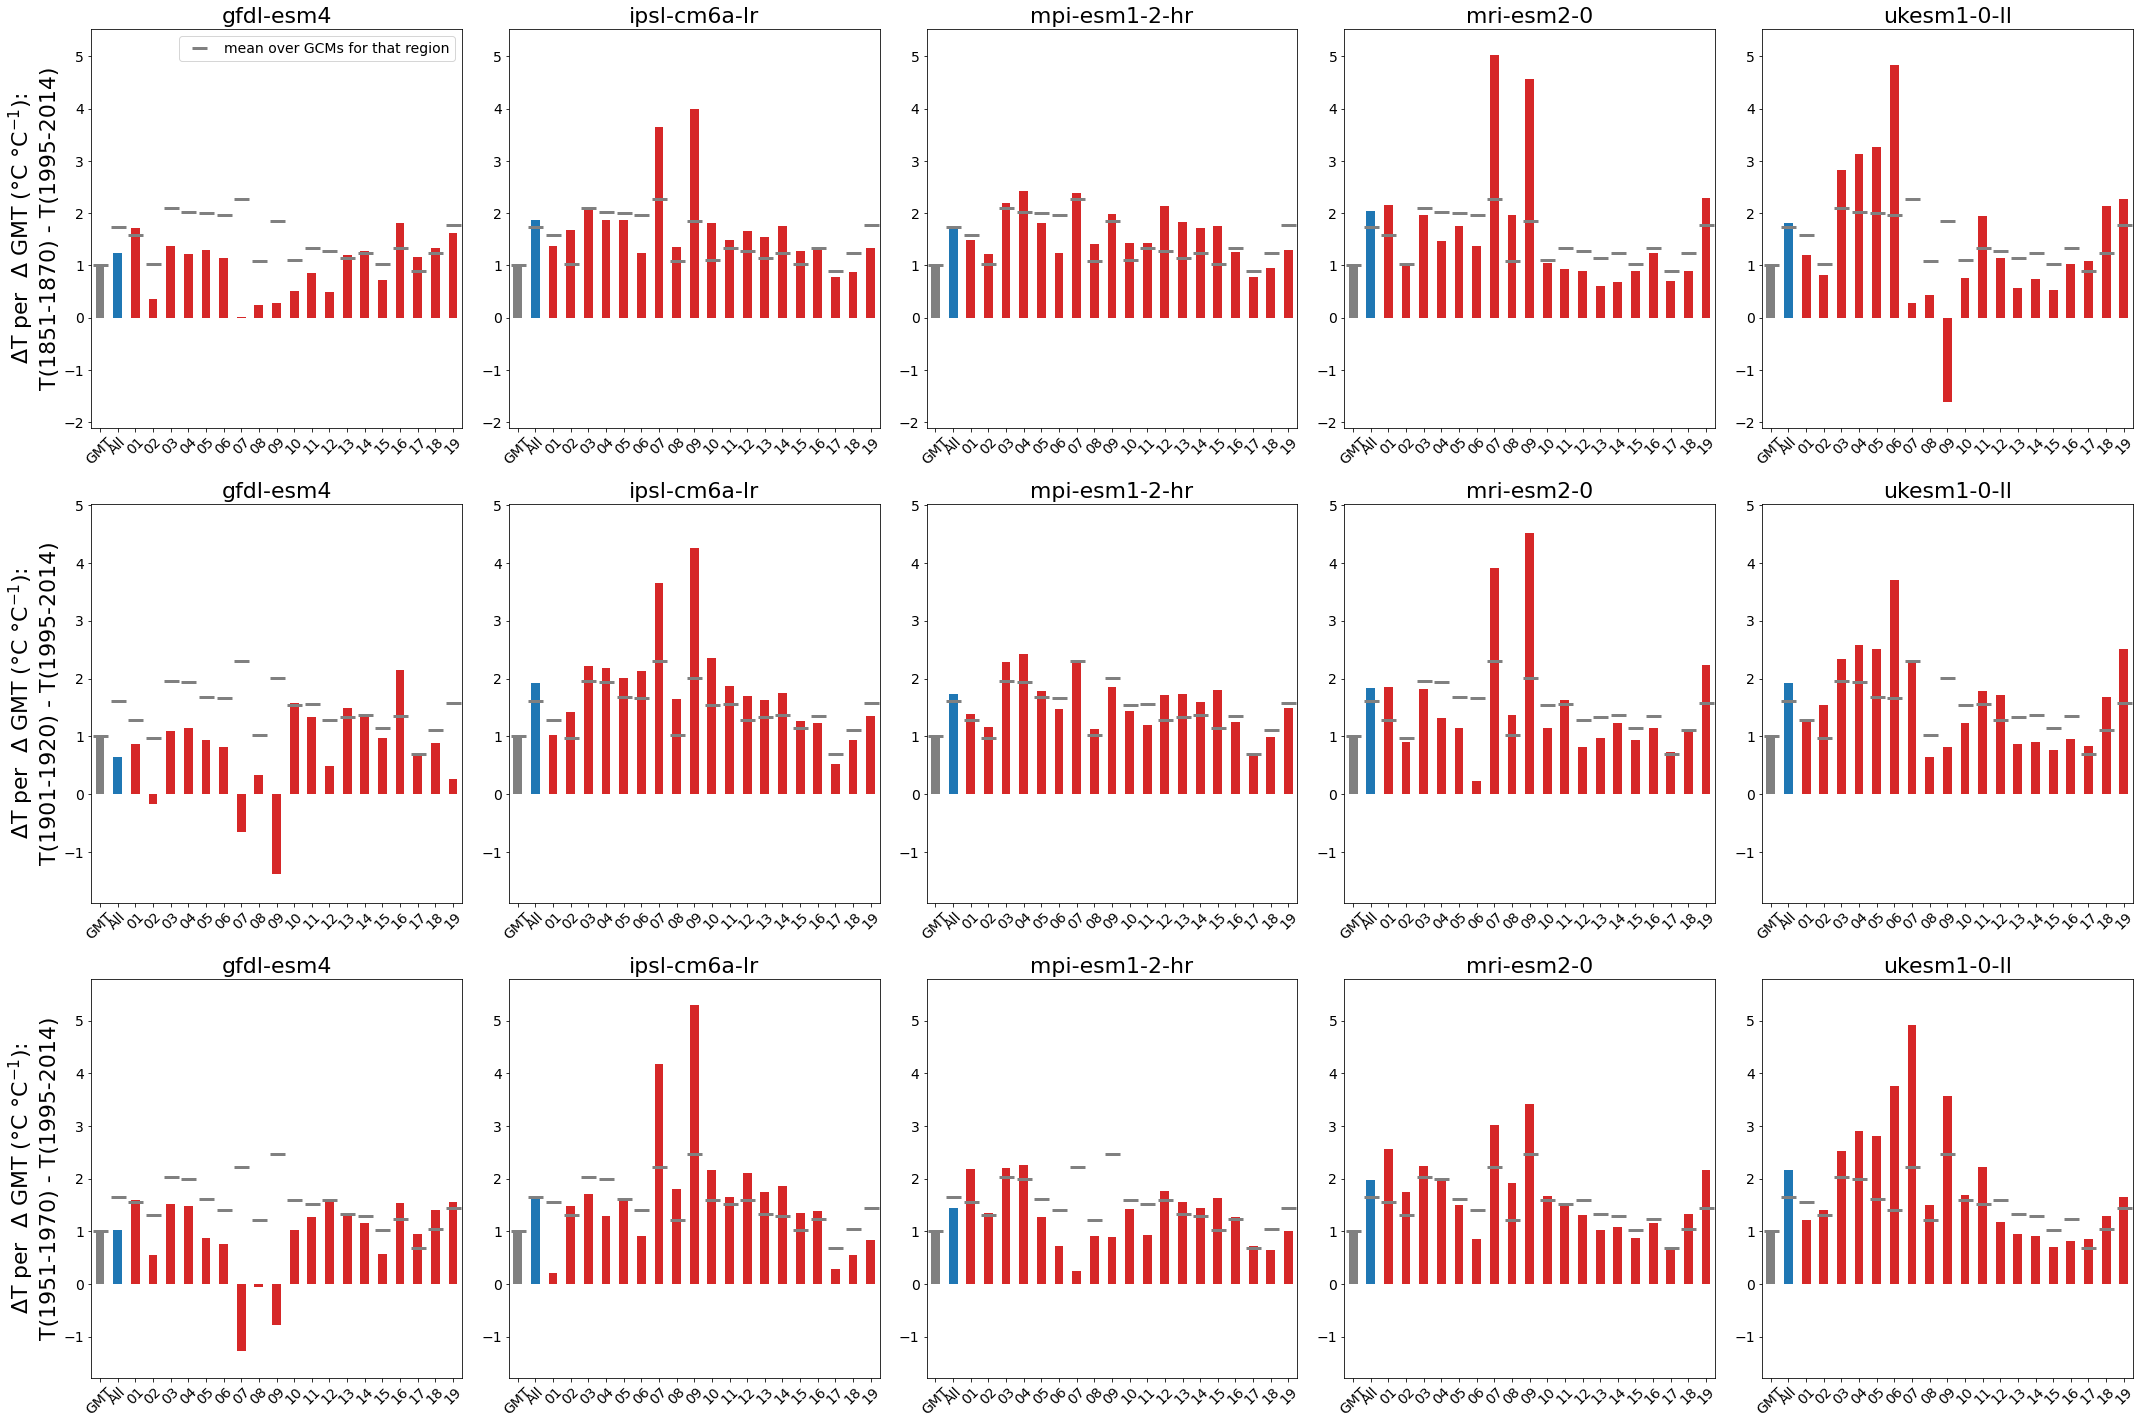

In [39]:
plt.rcParams.update({'font.size': 14})
scenario = 'ssp126'
plt.figure(figsize=(30, 20))

j=0
for exp_time in exp_times[:3]:
        tdf_d = tdf_e[exp_time]
        for gcm in gcms:
            plt.subplot(3,5,j+1)
            ax = plt.gca()
            #plt.axhline([taf_d[scenario].loc['GMT'].mean()], linestyle='--', color='k', label='mean over GCMs')
            plt.plot(tdf_d[scenario].drop('GMT_mean_diff').mean(axis=1).index,
                     tdf_d[scenario].drop('GMT_mean_diff').mean(axis=1).values, '_', color='grey', markersize=15, markeredgewidth=3,
                    label='mean over GCMs for that region')
            if gcm==gcms[0]:
                first_part = '$\Delta$T per  $\Delta$ GMT (°C °C$^{-1}$)'
                plt.ylabel('{}:\nT({}-{}) - T(1995-2014)'.format(first_part, exp_time, exp_time+19), fontsize=22)
            plt.yticks(np.arange(-14,22,1))
            maxi = tdf_d[scenario].max().max() +0.5
            mini = tdf_d[scenario].min().min() -0.5
            plt.ylim(mini, maxi)
            #if exp_time == 2021:
            #    plt.ylim(-1, 8)
            #elif exp_time ==2041:
            #    plt.ylim(-1, 12)
            #elif exp_time >=2061:
            #    plt.ylim(-1, 14)
            #plt.ylim(-1, 15)
            #else:
            #    plt.ylim(0,21)
            plt.title('{}'.format(gcm), fontsize=22)
            #plt.minorticks_on() # (np.arange(0,19))
            ax.tick_params(axis='x',which='minor',bottom=False)
            if j==0:
                plt.legend(fontsize=22)
            tdf_d[scenario].drop('GMT_mean_diff')[gcm].plot(ax=ax, kind='bar', rot=45,
                                                            color=['grey', 'C0'] + ['C3'] * 19+ ['grey']) #, yerr=yerr);

            j+=1
    #plt.suptitle(f'ISIMIP3b average T change at glacier locations (°C): $T_{2086-2100} - T_{2000-2014}$', fontsize=24)
plt.tight_layout()
plt.savefig('plots_isimip3b_analysis/plot_isimip3b_glaciers_deltaT_per_deltaGMT_exppast-ref.pdf')
#plt.savefig('plots_isimip3b_analysis/plot_isimip3b_glaciers_deltaT_exppast-ref.pdf')

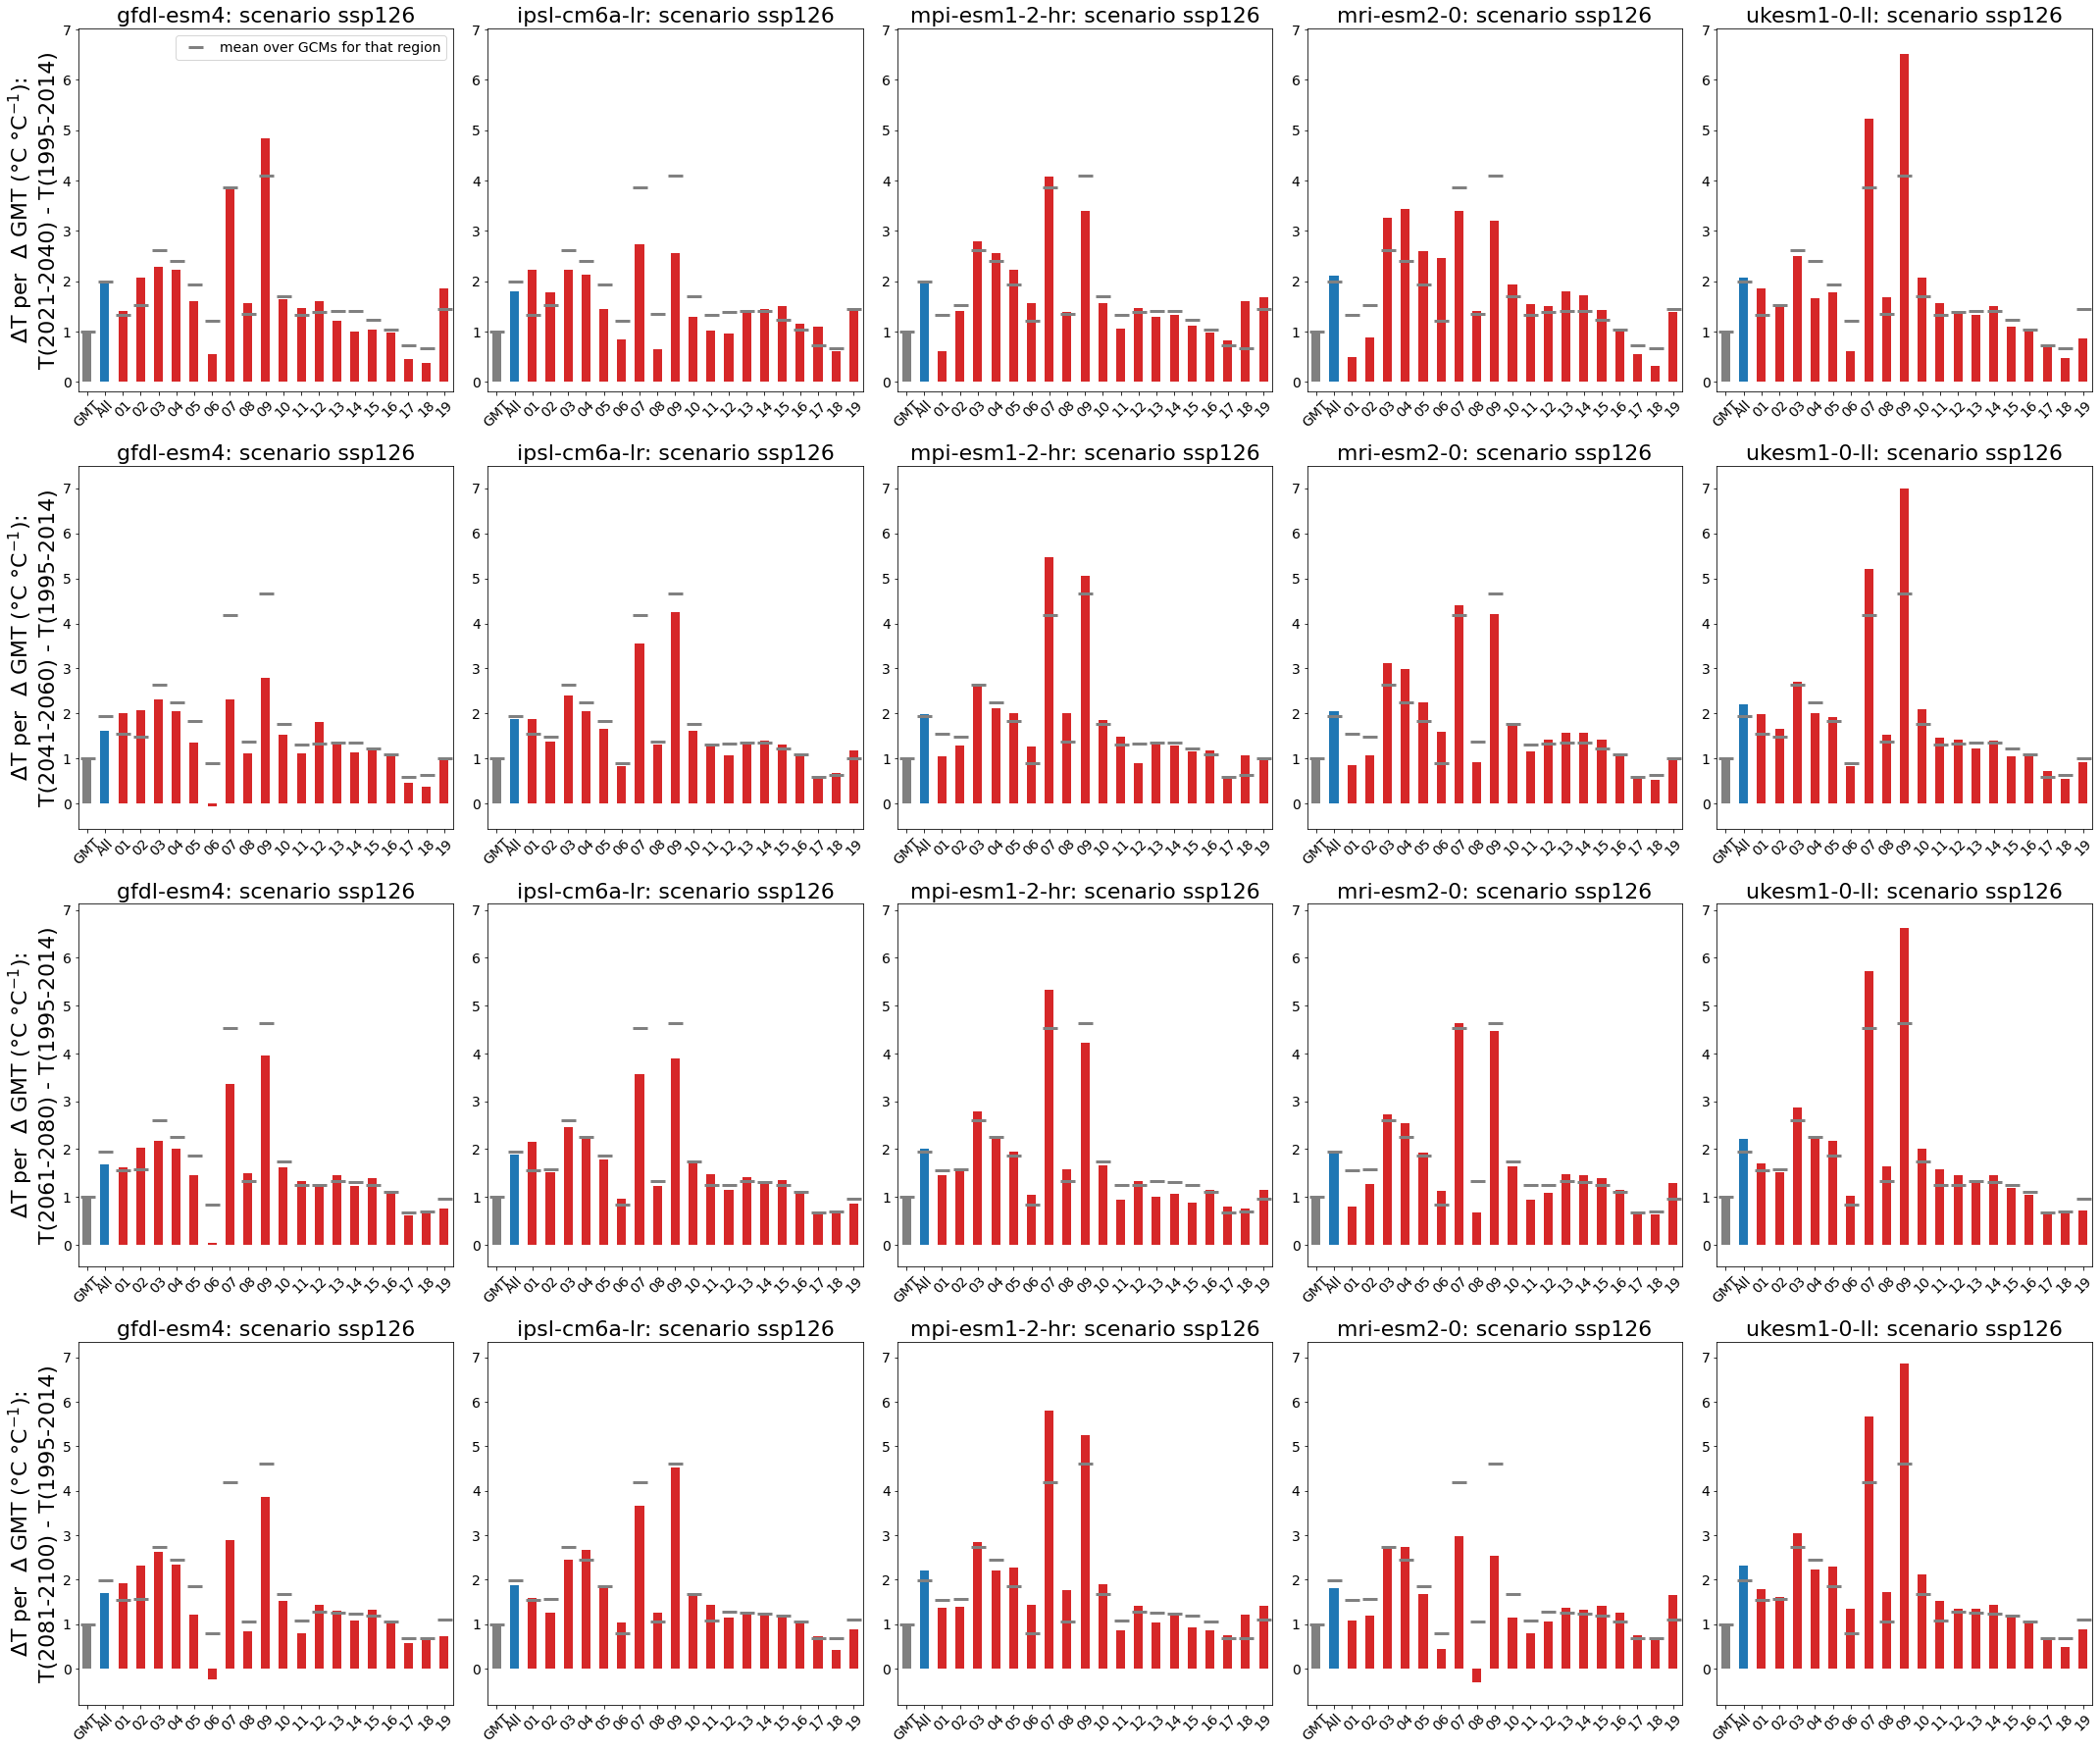

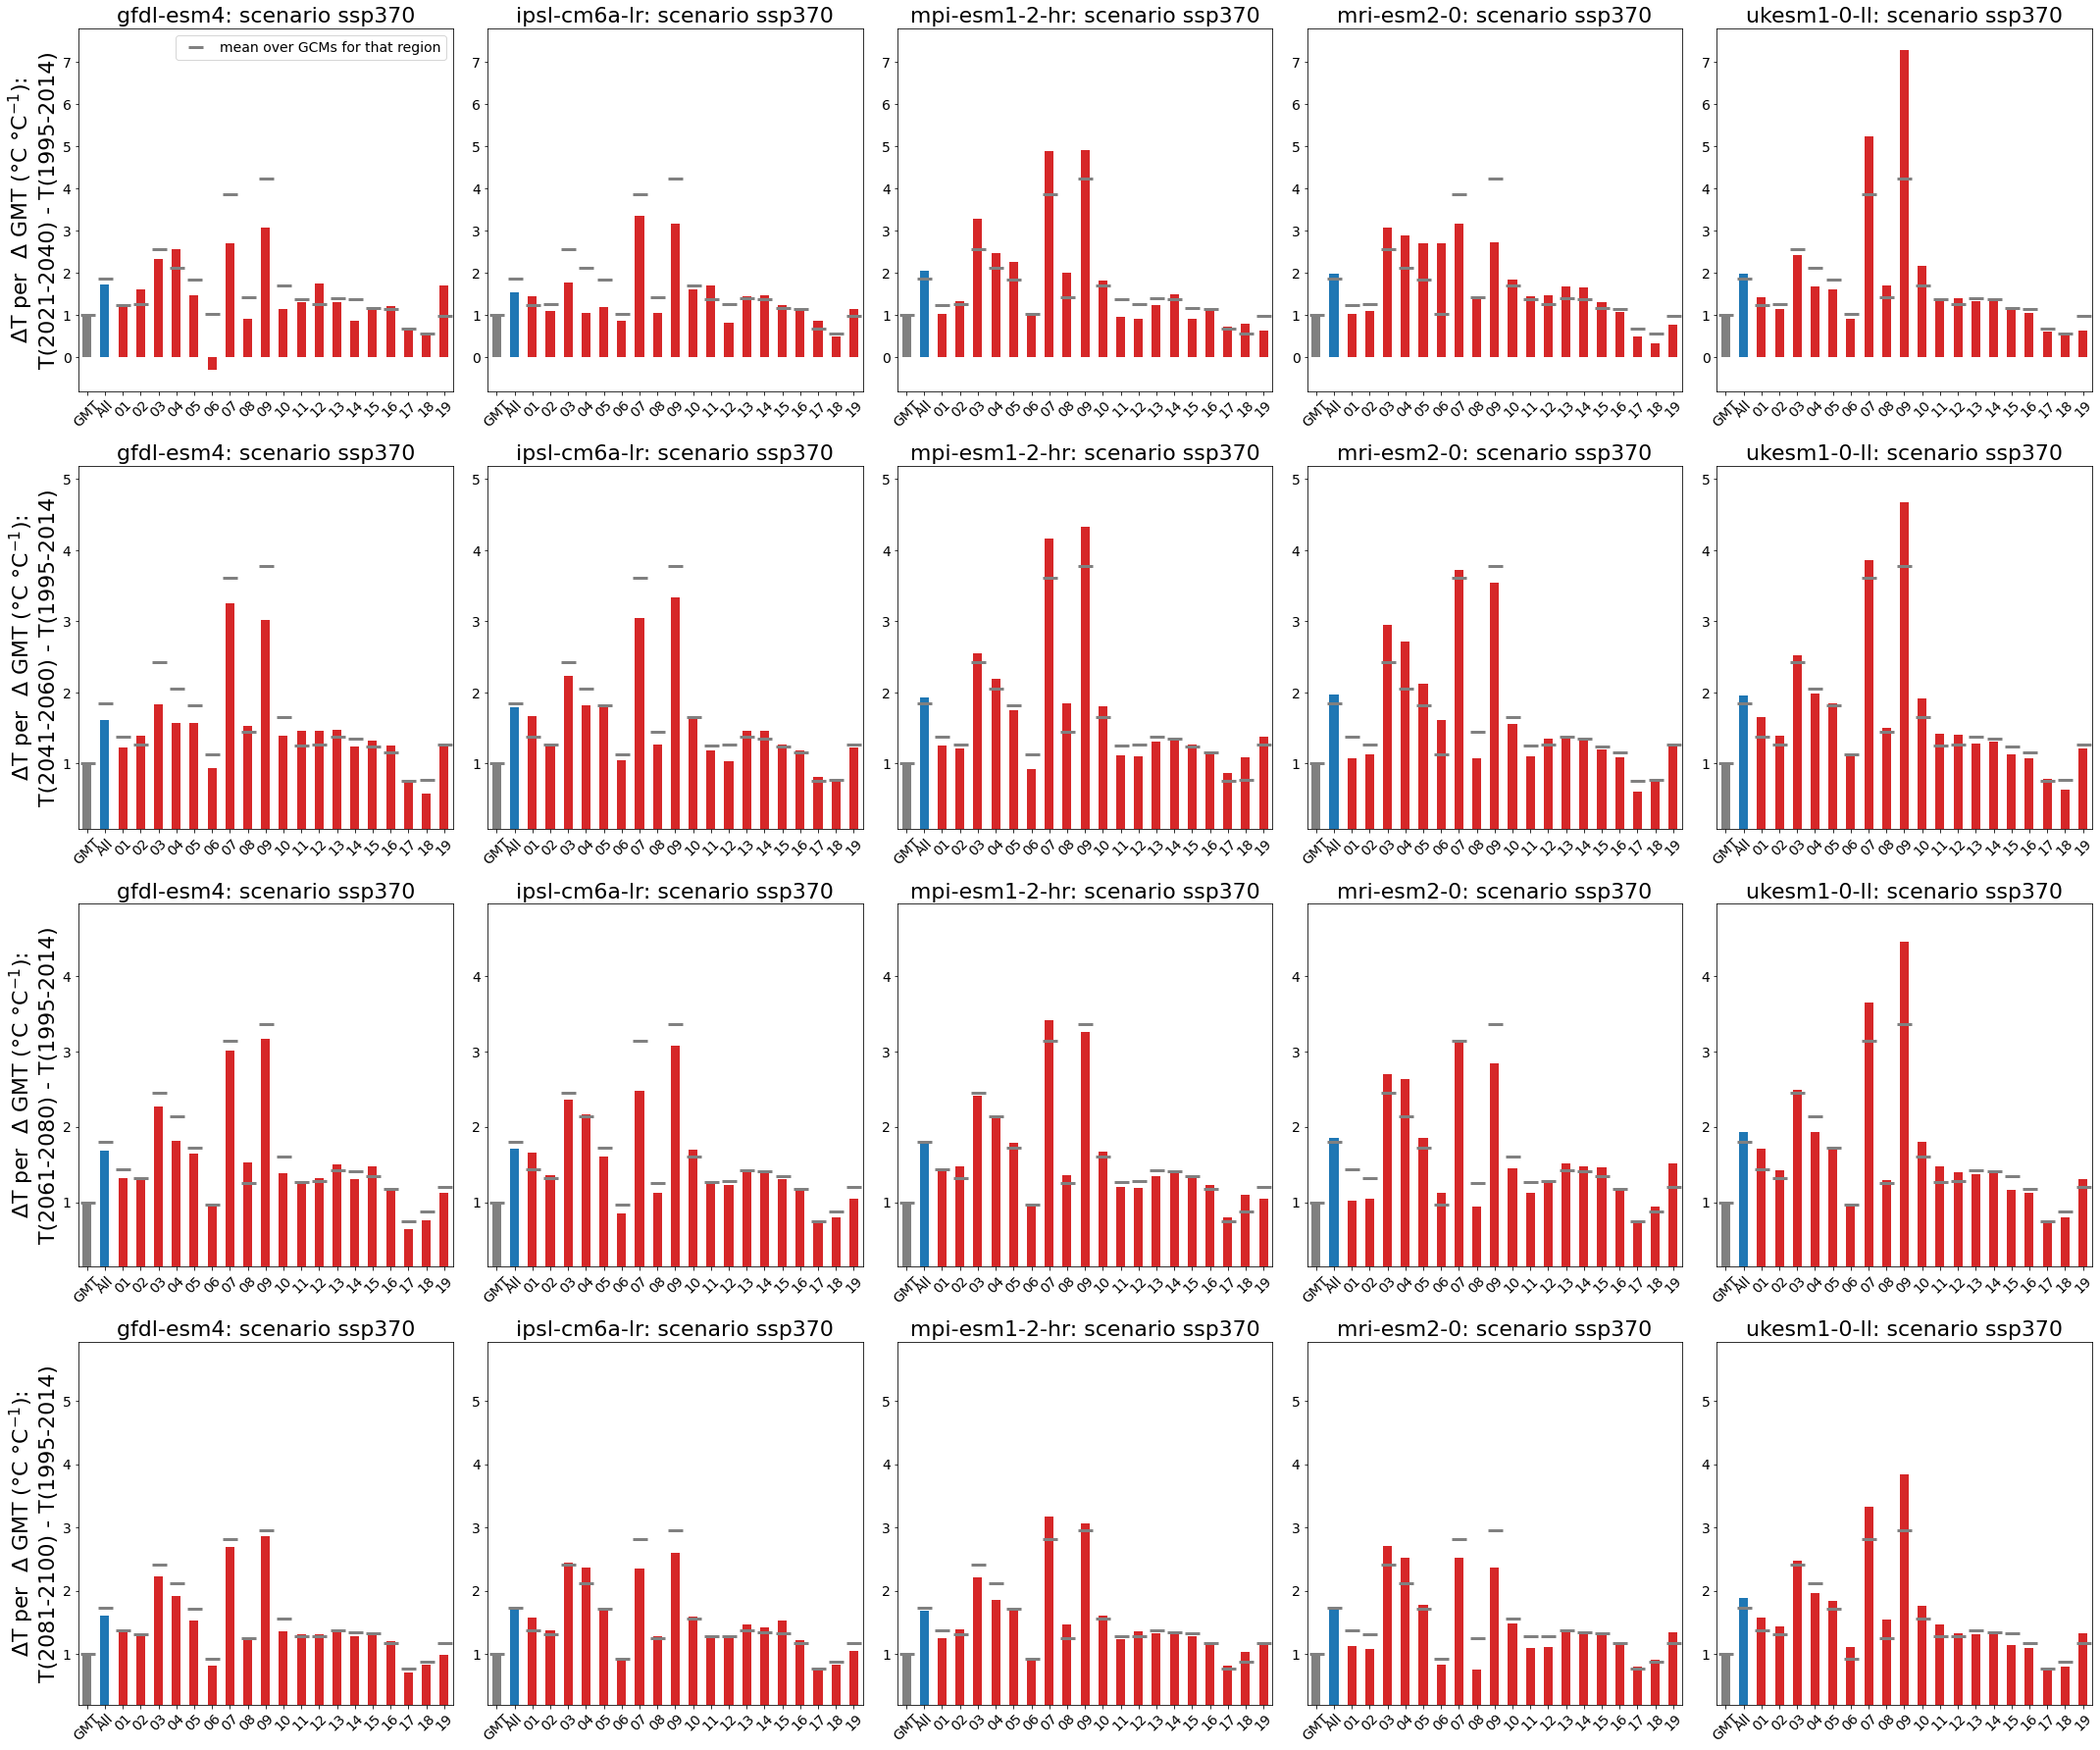

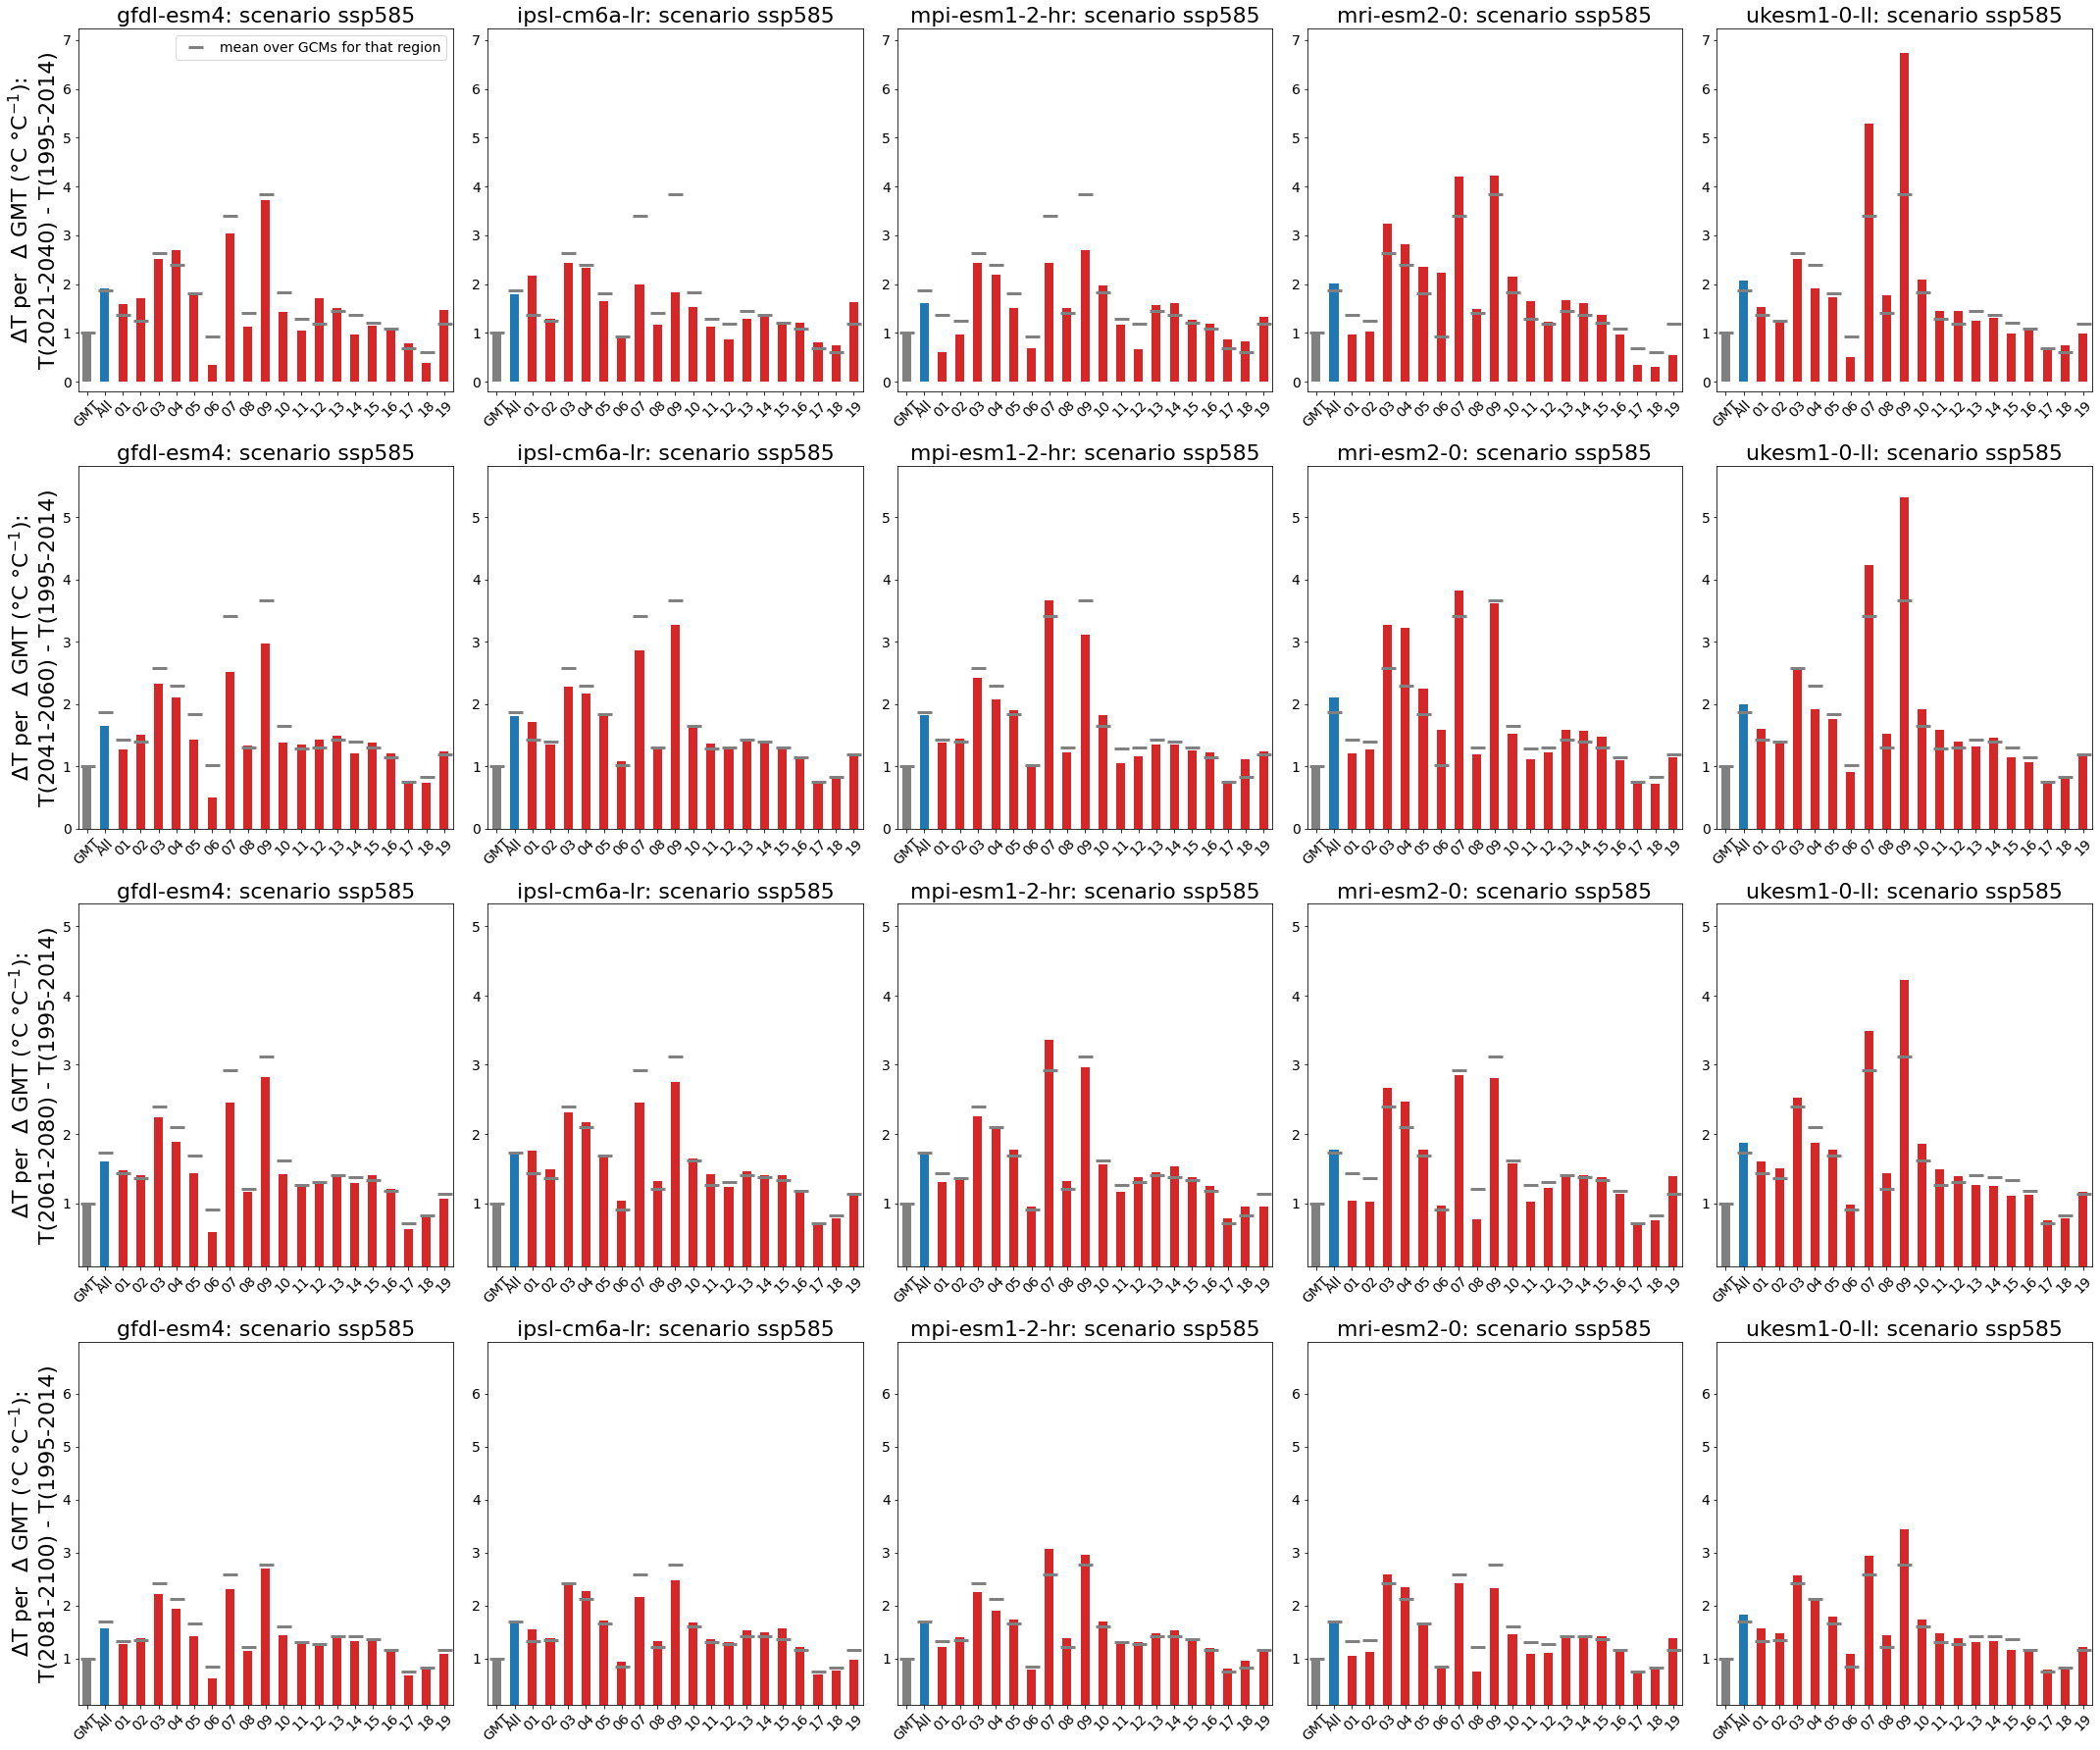

In [40]:
plt.rcParams.update({'font.size': 14})
scenario = 'ssp126'

for scenario in scenarios:
    plt.figure(figsize=(30, 25))

    j=0
    for exp_time in exp_times[3:]:
            tdf_d = tdf_e[exp_time]
            for gcm in gcms:
                plt.subplot(4,5,j+1)
                ax = plt.gca()
                #plt.axhline([taf_d[scenario].loc['GMT'].mean()], linestyle='--', color='k', label='mean over GCMs')
                plt.plot(tdf_d[scenario].drop('GMT_mean_diff').mean(axis=1).index,
                         tdf_d[scenario].drop('GMT_mean_diff').mean(axis=1).values, '_', color='grey', markersize=15, markeredgewidth=3,
                        label='mean over GCMs for that region')
                if gcm==gcms[0]:
                    first_part = '$\Delta$T per  $\Delta$ GMT (°C °C$^{-1}$)'
                    plt.ylabel('{}:\nT({}-{}) - T(1995-2014)'.format(first_part, exp_time, exp_time+19), fontsize=22)
                plt.yticks(np.arange(-14,22,1))
                maxi = tdf_d[scenario].max().max() +0.5
                mini = tdf_d[scenario].min().min() -0.5
                plt.ylim(mini, maxi)
                #if exp_time == 2021:
                #    plt.ylim(-1, 8)
                #elif exp_time ==2041:
                #    plt.ylim(-1, 12)
                #elif exp_time >=2061:
                #    plt.ylim(-1, 14)
                #plt.ylim(-1, 15)
                #else:
                #    plt.ylim(0,21)
                plt.title('{}: scenario {}'.format(gcm, scenario), fontsize=22)
                #plt.minorticks_on() # (np.arange(0,19))
                ax.tick_params(axis='x',which='minor',bottom=False)
                if j==0:
                    plt.legend(fontsize=22)
                tdf_d[scenario].drop('GMT_mean_diff')[gcm].plot(ax=ax, kind='bar', rot=45,
                                                                color=['grey', 'C0'] + ['C3'] * 19+ ['grey']) #, yerr=yerr);

                j+=1
        #plt.suptitle(f'ISIMIP3b average T change at glacier locations (°C): $T_{2086-2100} - T_{2000-2014}$', fontsize=24)
    plt.tight_layout()
    plt.savefig('plots_isimip3b_analysis/plot_isimip3b_glaciers_deltaT_per_deltaGMT_expfuture-ref_{}.pdf'.format(scenario))


#### The same for precipitation
- just look at relative precipitation change compared to reference period

In [243]:
run =False
if run:

    typ = 'prAdjust'
    scenarios = ['ssp126', 'ssp370', 'ssp585']

    #tdf_e_prcp = {}
    #taf_e_prcp = {}
    trf_prcp_e = {}
    trf_prcp_e_med = {}
    # this has to be repeated for each experiment:
    # it would be better to repeat the experiment for each typ (in the inner loop,
    # like that we would not need to repeat)
    for exp_time in exp_times:
        #tdf_d_prcp = {}
        #taf_d_prcp = {}
        trf_prcp_d = {}
        trf_prcp_d_med = {}
        for scenario in scenarios:
            #tdf_prcp = pd.DataFrame(dtype=float)
            #taf_prcp = pd.DataFrame(dtype=float)
            # relative prcp. change ... 
            trf_prcp = pd.DataFrame(dtype=float)
            trf_prcp_med = pd.DataFrame(dtype=float)

            for gcm in gcms:
                if gcm in ['gfdl-esm4', 'ipsl-cm6a-lr', 'mpi-esm1-2-hr', 'mri-esm2-0']:
                    ensemble = 'r1i1p1f1'
                elif gcm == 'ukesm1-0-ll':
                    ensemble = 'r1i1p1f2'

                    # for the ssp:
                ybegin = 2015
                yend = 2100
                folder_output = 'isimip3b_{}_monthly'.format(typ)

                path_s = '{}/{}_{}_w5e5_{}_{}_global_monthly_{}_{}.nc'.format(folder_output, gcm, ensemble, scenario, typ, ybegin, yend)
                path_h = '{}/{}_{}_w5e5_{}_{}_global_monthly_{}_{}.nc'.format(folder_output, gcm, ensemble, 'historical', typ, 1850, 2014)

                ds_gcm_pr_hist = xr.open_dataset(path+path_h).prAdjust 
                ds_gcm_pr = xr.open_dataset(path+path_s).prAdjust 
                ds_gcm_pr_hist['lon'] = np.where(ds_gcm_pr.lon.values < 0,
                                             ds_gcm_pr.lon.values + 360,
                                             ds_gcm_pr.lon.values)
                ds_gcm_pr['lon'] = np.where(ds_gcm_pr.lon.values < 0,
                                             ds_gcm_pr.lon.values + 360,
                                             ds_gcm_pr.lon.values)

                # could also look at the seasonal cycle, but here I look at the annual means ...
                if exp_time<2015:
                    # in that case the experiment period is also in the historic time!
                    # and actually it is equal for all scenarios !!!!
                    # mean relative precipiration change for each glacier grid point 
                    pr_rel_ref_perc = 100 * (ds_gcm_pr_hist.sel(time=slice(str(exp_time),str(exp_time+19))).mean(dim='time')/
                                             ds_gcm_pr_hist.sel(time=slice(str(ref_time),str(ref_time+19))).mean(dim='time'))

                    # this here is the same as before, but now we use as reference time period the median over the 5 GCMs
                    pr_rel_ref_perc_median_gcm = 100*(ds_gcm_pr_hist.sel(time=slice(str(exp_time),str(exp_time+19))).mean(dim='time')/
                                           ds_avg_ref_time_pr_per_gp_gcm.median(dim='gcm'))
                else:
                    # mean relative precipiration change for each glacier grid point 
                    pr_rel_ref_perc = 100 * (ds_gcm_pr.sel(time=slice(str(exp_time),str(exp_time+19))).mean(dim='time')/
                                             ds_gcm_pr_hist.sel(time=slice(str(ref_time),str(ref_time+19))).mean(dim='time'))

                    pr_rel_ref_perc_median_gcm = 100*(ds_gcm_pr.sel(time=slice(str(exp_time),str(exp_time+19))).mean(dim='time')/
                                           ds_avg_ref_time_pr_per_gp_gcm.median(dim='gcm'))

                # Check (should be one)
                #tdf.loc['GMT', gcm] = float((t2m_dT_per_dT * ds_inv.weight).sum(dim=['lon','lat']))

                # these should be the same ... 
                #taf.loc['GMT', gcm] = float((pr_rel_ref_perc * ds_inv.weight).sum(dim=['lon','lat']))
                #taf.loc['GMT_mean_diff', gcm] = (mean_exp.mean()-mean_ref.mean())
                #tdf.loc['GMT_mean_diff', gcm] = (mean_exp.mean()-mean_ref.mean())
                #taf.loc['GMT_mean_diff', gcm] = (mean_exp.mean()-mean_hist.mean())
                #tdf.loc['GMT_mean_diff', gcm] = (mean_exp.mean()-mean_hist.mean())

                # All glaciers (weighted by area)
                # in weight_glacier: the area of each glacier is already inside
                #tdf.loc['All', gcm] = float((t2m_dT_per_dT * ds_inv.weight_glacier).sum(dim=['lon','lat']))
                trf_prcp.loc['All', gcm] = float((pr_rel_ref_perc * ds_inv.weight_glacier).sum(dim=['lon','lat']))
                trf_prcp_med.loc['All', gcm] = float((pr_rel_ref_perc_median_gcm * ds_inv.weight_glacier).sum(dim=['lon','lat']))


                for rgi_reg in range(1, 20):
                    weight_reg = ds_inv.weight_glacier.where(ds_inv.rgi_region == rgi_reg)
                    weight_reg = weight_reg / weight_reg.sum()

                    #tdf.loc['{:02d}'.format(rgi_reg), gcm] = float((t2m_dT_per_dT * weight_reg).sum(dim=['lon','lat']))
                    trf_prcp.loc['{:02d}'.format(rgi_reg), gcm] = float((pr_rel_ref_perc * weight_reg).sum(dim=['lon','lat']))
                    trf_prcp_med.loc['{:02d}'.format(rgi_reg), gcm] = float((pr_rel_ref_perc_median_gcm * weight_reg).sum(dim=['lon','lat']))
                #tdf_d[scenario] = tdf
                trf_prcp_d[scenario] = trf_prcp
                trf_prcp_d_med[scenario] = trf_prcp_med

                ds_gcm_pr_hist.close()
                ds_gcm_pr.close()
        print(exp_time)
        trf_prcp_e[exp_time] = trf_prcp_d
        trf_prcp_e_med[exp_time] = trf_prcp_d_med
        #taf_e[exp_time] = taf_d

In [136]:
run = False
if run:
    _pd_prcp_diff_1995_2014_list = []
    for y0_time in exp_times:
        period = f'{y0_time}-{y0_time+19}'
        for scenario in scenarios:
            trf_prcp = trf_prcp_e[y0_time][scenario]
            trf_prcp_med = trf_prcp_e_med[y0_time][scenario]

            trf_prcp_long = trf_prcp.stack().reset_index()
            trf_prcp_long.columns = ['rgi_reg', 'gcm', r'prcp change (%) to same GCM']

            trf_prcp_med_long = trf_prcp_med.stack().reset_index()
            trf_prcp_med_long.columns = ['rgi_reg', 'gcm', r'prcp change (%) to median GCM']
            _pd_prcp_diff_1995_2014 = pd.concat([trf_prcp_long.groupby(['rgi_reg', 'gcm']).mean(),
                                        trf_prcp_med_long.groupby(['rgi_reg', 'gcm']).mean()
                                                ], axis=1)
            _pd_prcp_diff_1995_2014 = _pd_prcp_diff_1995_2014.reset_index()
            _pd_prcp_diff_1995_2014['ssp'] = scenario
            _pd_prcp_diff_1995_2014['period'] = period
            _pd_prcp_diff_1995_2014['ref_time'] = '1995-2014'
            _pd_prcp_diff_1995_2014_list.append(_pd_prcp_diff_1995_2014)

    pd_prcp_diff_1995_2014 = pd.concat(_pd_prcp_diff_1995_2014_list)
    pd_prcp_diff_1995_2014 = pd_prcp_diff_1995_2014.reset_index(drop=True)
    #pd_prcp_diff_1995_2014 = pd_prcp_diff_1995_2014.rename(columns={'region':'rgi_reg'})

    for p in ['1851-1870', '1901-1920', '1951-1970', '1995-2014']:
        for s in ['ssp370', 'ssp585']:
            index_drop = pd_prcp_diff_1995_2014.loc[(pd_prcp_diff_1995_2014.period == p) & (pd_prcp_diff_1995_2014.ssp == s)].index
            pd_prcp_diff_1995_2014 = pd_prcp_diff_1995_2014.drop(index_drop)
        for s in ['ssp126']:
            index_rename = pd_prcp_diff_1995_2014.loc[(pd_prcp_diff_1995_2014.period == p) & (pd_prcp_diff_1995_2014.ssp == s)].index
            pd_prcp_diff_1995_2014.loc[index_rename, 'ssp'] = 'hist'

    path_analysis = '/home/www/lschuster/glacierMIP3_analysis/'
    pd_prcp_diff_1995_2014.to_csv(path_analysis + 'rgi_reg_glacier_area_weighted_prcp_change_vs_1995_2014_isimip3b.csv')
    pd_prcp_change_1995_2014  = pd_prcp_diff_1995_2014.copy()

In [244]:
pd_prcp_diff_1995_2014 = pd.read_csv(path_analysis + 'rgi_reg_glacier_area_weighted_prcp_change_vs_1995_2014_isimip3b.csv', index_col=[0])


In [245]:
pd_prcp_change_1995_2014

rgi_reg            gcm  prcp change (%) to same GCM  \
0         01      gfdl-esm4                    99.206802   
1         01   ipsl-cm6a-lr                   100.103465   
2         01  mpi-esm1-2-hr                    93.084911   
3         01     mri-esm2-0                    99.222659   
4         01    ukesm1-0-ll                   101.388026   
...      ...            ...                          ...   
2395     All      gfdl-esm4                   133.338139   
2396     All   ipsl-cm6a-lr                   162.413411   
2397     All  mpi-esm1-2-hr                   141.700187   
2398     All     mri-esm2-0                   143.515596   
2399     All    ukesm1-0-ll                   182.988319   

      prcp change (%) to median GCM     ssp     period   ref_time  
0                         97.902062    hist  1851-1870  1995-2014  
1                         99.231394    hist  1851-1870  1995-2014  
2                         94.417611    hist  1851-1870  1995-2014  
3                         98.861025    hist  1851-1870  1995-2014  
4                        103.691520    hist  1851-1870  1995-2014  
...                             ...     ...        ...        ...  
2395                     130.922807  ssp585  2081-2100  1995-2014  
2396                     162.593161  ssp585  2081-2100  1995-2014  
2397                     140.555890  ssp585  2081-2100  1995-2014  
2398                     145.635116  ssp585  2081-2100  1995-2014  
2399                     186.594120  ssp585  2081-2100  1995-2014  

[1600 rows x 7 columns]

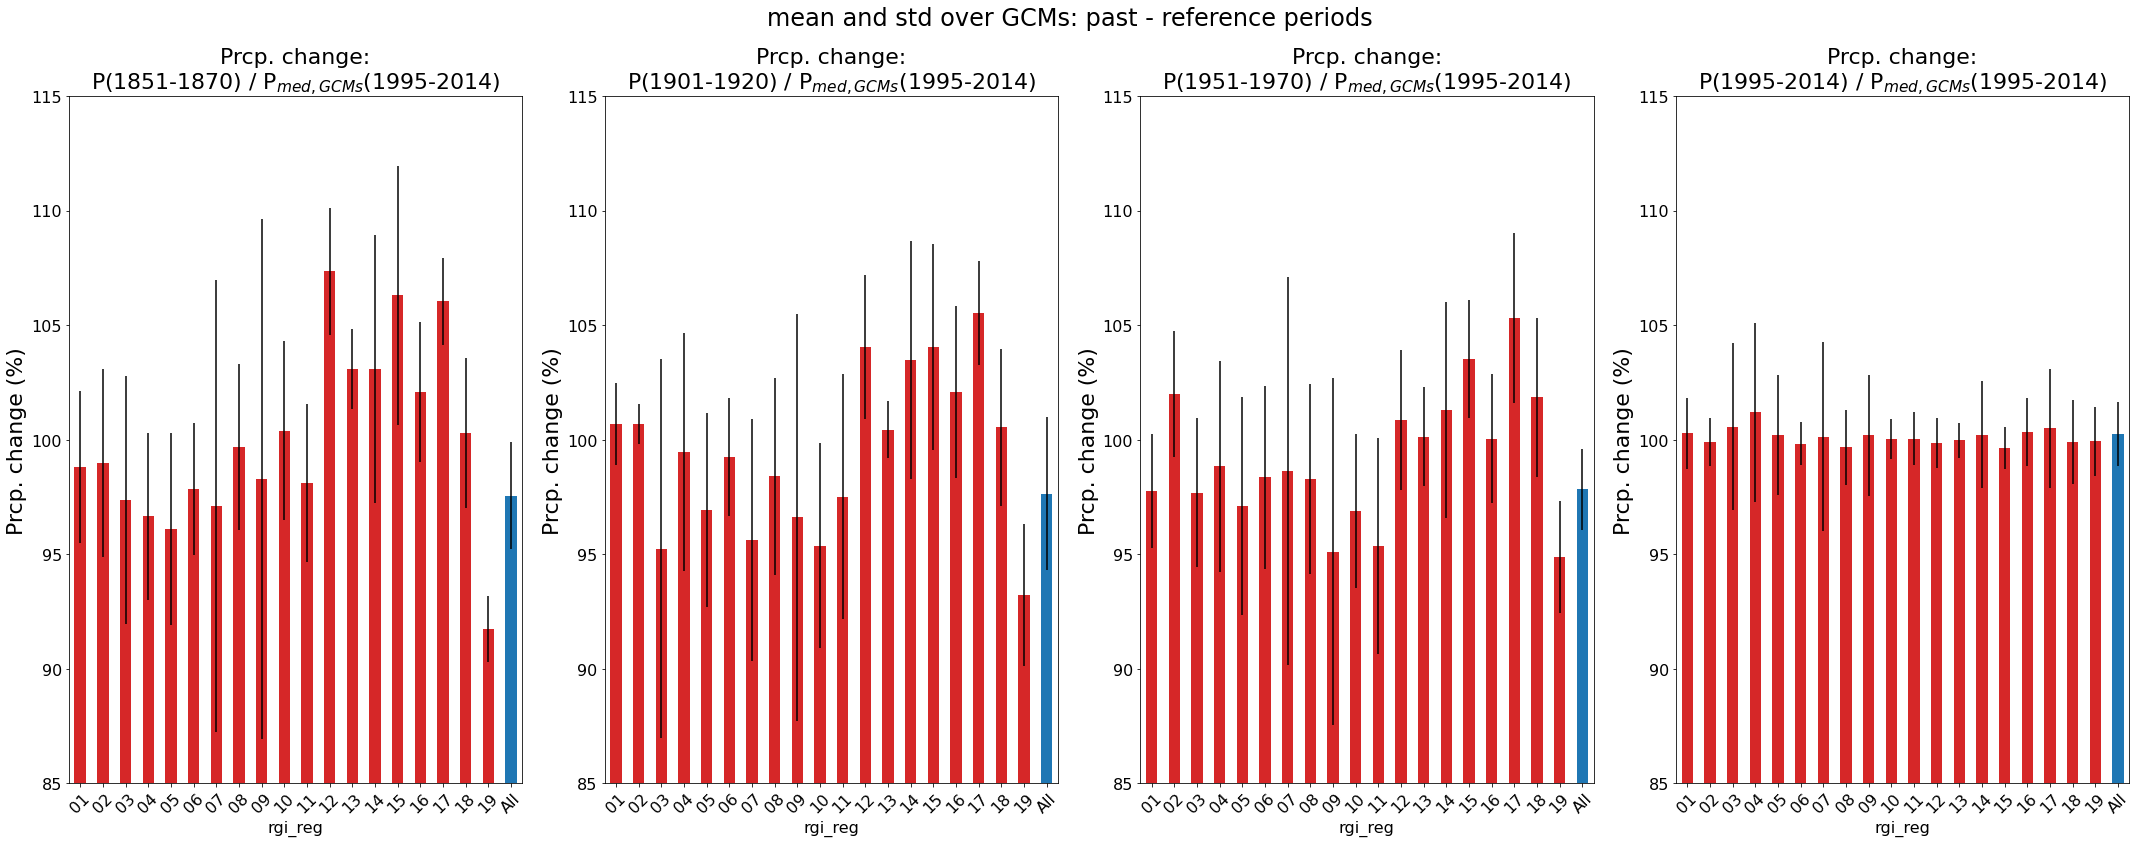

In [250]:
var = 'prcp change (%) to median GCM'

# just drop GMT mean diff
_pd_prcp_change_1995_2014 = pd_prcp_change_1995_2014.loc[pd_prcp_change_1995_2014.rgi_reg!='GMT_mean_diff']

from matplotlib.lines import Line2D
plt.rcParams.update({'font.size': 16})

scenario = 'hist'
plt.figure(figsize=(30, 12))
plt.suptitle('mean and std over GCMs: past - reference periods',
                  fontsize=24)
j=0
for exp_time in exp_times[:4]:
    period = f'{exp_time}-{exp_time+19}'
    #taf_d = taf_e[exp_time]
    pd_sel = _pd_prcp_change_1995_2014.loc[(_pd_prcp_change_1995_2014.period==period) & (_pd_prcp_change_1995_2014.ssp==scenario)] 
    plt.subplot(1,4,j+1)
    ax = plt.gca()
    plt.title('Prcp. change:\nP({}-{})'.format(exp_time, exp_time+19)+r' / P$_{med,GCMs}$(1995-2014)', fontsize=22)
    plt.ylabel('Prcp. change (%)', fontsize=22)

    #plt.yticks(np.arange(-14,22,1))
    plt.ylim([85, 115])
    ax.tick_params(axis='x',which='minor',bottom=False)
    yerr = pd_sel.groupby('rgi_reg').std()[var].values
    pd_sel.groupby('rgi_reg').mean()[var].plot(ax=ax, kind='bar', rot=45,
                                                            color=['C3'] * 19+['C0','grey'],
                                               yerr=yerr);

    j+=1
plt.tight_layout()
plt.savefig('plots_isimip3b_analysis/plot_isimip3b_glaciers_Prcp_change_exppast-ref_mean_std_ref_median_GCM.pdf')


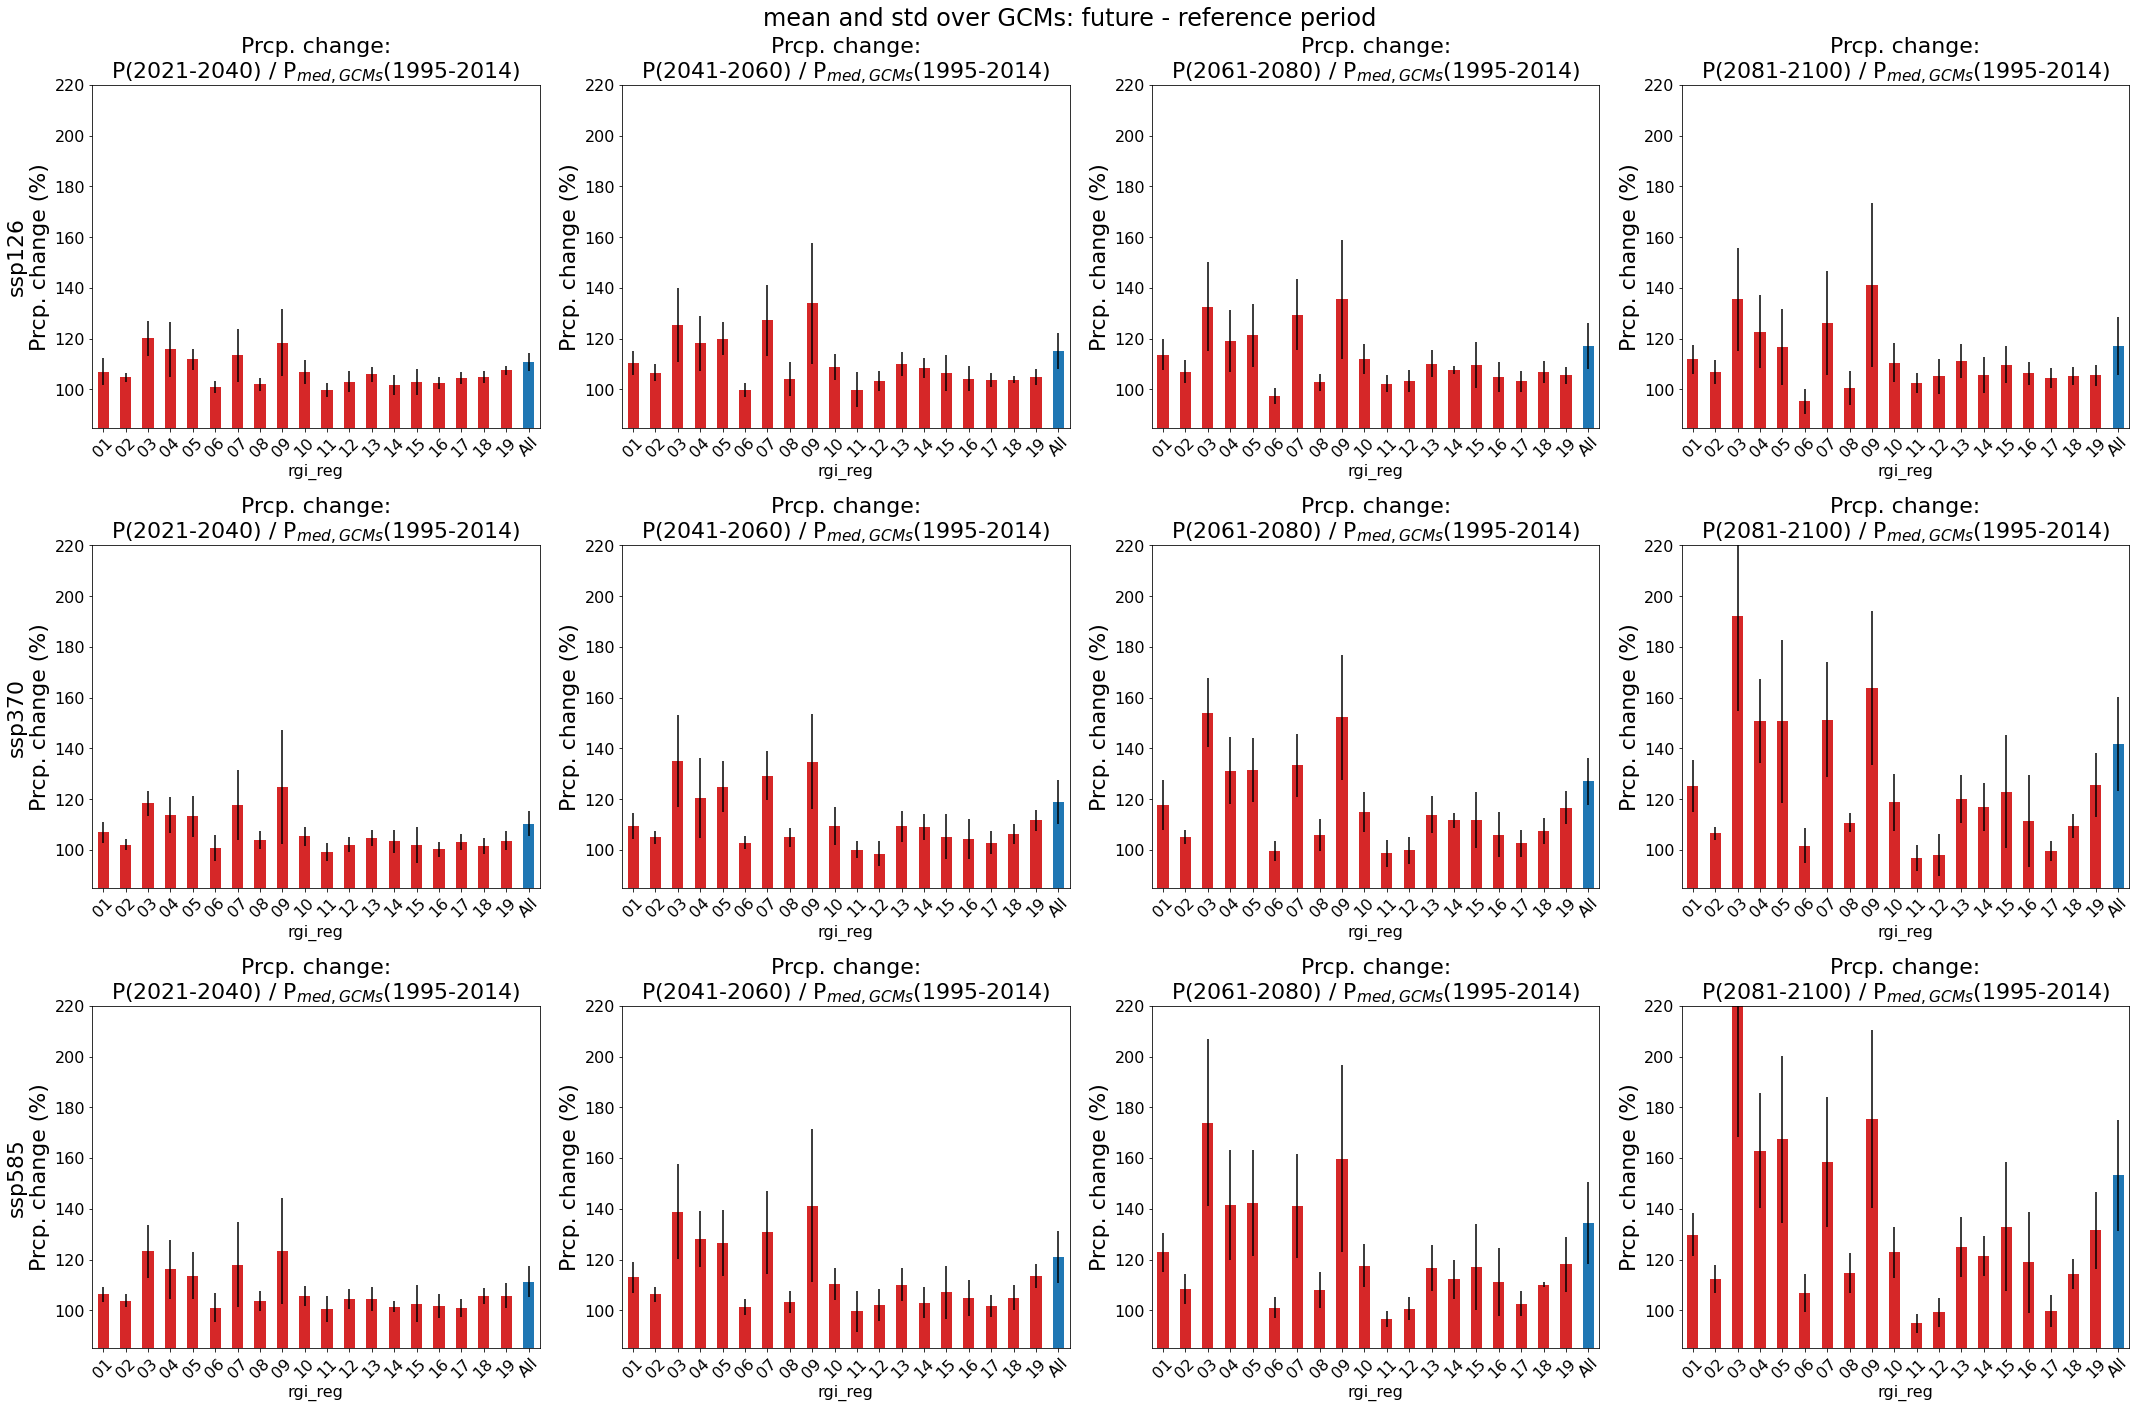

In [254]:
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(30, 20))
_pd_prcp_change_1995_2014 = pd_prcp_change_1995_2014.loc[pd_prcp_change_1995_2014.rgi_reg!='GMT_mean_diff']

j=0
plt.suptitle('mean and std over GCMs: future - reference period',
                  fontsize=24)
for scenario in scenarios:
    for exp_time in exp_times[4:]:
        period = f'{exp_time}-{exp_time+19}'

        pd_sel = _pd_prcp_change_1995_2014.loc[(_pd_prcp_change_1995_2014.period==period) & (_pd_prcp_change_1995_2014.ssp==scenario)] 

        plt.subplot(3,4,j+1)
        ax = plt.gca()
        if exp_time == exp_times[4]:
            plt.ylabel('{}\nPrcp. change (%)'.format(scenario), fontsize=22)
        else:
            plt.ylabel('Prcp. change (%)', fontsize=22)
        plt.title('Prcp. change:\nP({}-{})'.format(exp_time, exp_time+19)+r' / P$_{med,GCMs}$(1995-2014)', fontsize=22)
        #plt.yticks(np.arange(-14,22,1))
        plt.ylim([85, 220])

        ax.tick_params(axis='x',which='minor',bottom=False)
        yerr = pd_sel.groupby('rgi_reg').std()[var].values
        pd_sel.groupby('rgi_reg').mean()[var].plot(ax=ax, kind='bar', rot=45,
                                                                color=['C3'] * 19+['C0','grey'],
                                                   yerr=yerr);
        j+=1
plt.tight_layout()

plt.savefig('plots_isimip3b_analysis/plot_isimip3b_glaciers_Prcp_change_expfuture-ref_mean_std_ref_median_GCM.pdf')


# Climate change for the different selected GlacierMIP3 time periods compared to the reference time period (1850-2000)

- 1859-2000 climate (here just randomly chosen median over GCMs)
    - temperature of the average reference time  for each gridpoint and for a single gcm 
    - then computed the amount of warming for each grid point compared to reference time period (1850-2000)
    - then estimate glacier-area weighted averaged temp. change for each RGI region!!! 


In [5]:
# **FIRST: precompute the 1995-2014 reference climate (i.e. median over the 5 GCM's)**

# 20 years before 2015 (starting with 2015, data depends on ssp!)
# I also added here the reference period
exp_times = [1851, 1901, 1951, 1995, 2021, 2041, 2061, 2081]

# get the right format for the longitudes
ds_inv.coords['lon'] = np.where(ds_inv.lon.values < 0, ds_inv.lon.values + 360,
                                  ds_inv.lon.values)
ds_inv = ds_inv.sortby(ds_inv.lon)
ds_inv.lon.attrs['units'] = 'degrees_onlypositive'

gcms = ['gfdl-esm4', 'ipsl-cm6a-lr', 'mpi-esm1-2-hr', 'mri-esm2-0', 'ukesm1-0-ll' ]
scenarios = ['ssp126', 'ssp370', 'ssp585']

In [6]:
run = True
if run:
    scenario = 'hist'

    avg_ref_time_temp_per_gp_gcm_l = []
    avg_ref_time_temp_gcm_l = []
    avg_ref_time_pr_per_gp_gcm_l = []
    avg_ref_time_pr_gcm_l = []
    for gcm in gcms:
        if gcm in ['gfdl-esm4', 'ipsl-cm6a-lr', 'mpi-esm1-2-hr', 'mri-esm2-0']:
            ensemble = 'r1i1p1f1'
        elif gcm == 'ukesm1-0-ll':
            ensemble = 'r1i1p1f2'
        # for the ssp:
        ybegin = 2015
        yend = 2100
        ### temperature 
        # get the historical temperature file
        folder_output_t = 'isimip3b_tasAdjust_monthly'
        path_h_tas = '{}/{}_{}_w5e5_{}_{}_global_monthly_{}_{}.nc'.format(folder_output_t, gcm, ensemble, 'historical', 'tasAdjust', 1850, 2014)

        ds_gcm_t2m_hist = xr.open_dataset(path+path_h_tas).tasAdjust-273.15
        ds_gcm_t2m_hist['lon'] = np.where(ds_gcm_t2m_hist.lon.values < 0,
                                     ds_gcm_t2m_hist.lon.values + 360,
                                     ds_gcm_t2m_hist.lon.values)
        # temperature of the average reference time  for each gridpoint and for a single gcm 
        avg_ref_time_temp_per_gp_gcm = ds_gcm_t2m_hist.sel(time=slice(str(1850), str(1900))).mean(dim='time')
        avg_ref_time_temp_per_gp_gcm.coords['gcm'] = gcm
        avg_ref_time_temp_per_gp_gcm_l.append(avg_ref_time_temp_per_gp_gcm)      
        avg_ref_time_temp_gcm_l.append((ds_gcm_t2m_hist.sel(time=slice(str(1850),
                                                               str(1900))).groupby('time.year').mean()  * ds_inv.weight).sum(dim=['lon','lat']).mean())
        ### same for prcp.:
        folder_output_p = 'isimip3b_prAdjust_monthly'
        path_h_pr = '{}/{}_{}_w5e5_{}_{}_global_monthly_{}_{}.nc'.format(folder_output_p, gcm, ensemble, 'historical', 'prAdjust', 1850, 2014)
        ds_gcm_pr_hist = xr.open_dataset(path+path_h_pr).prAdjust
        ds_gcm_pr_hist['lon'] = np.where(ds_gcm_pr_hist.lon.values < 0,
                                         ds_gcm_pr_hist.lon.values + 360,
                                         ds_gcm_pr_hist.lon.values)
        avg_ref_time_pr_per_gp_gcm = ds_gcm_pr_hist.sel(time=slice(str(1850),str(1900))).mean(dim='time')
        avg_ref_time_pr_per_gp_gcm.coords['gcm'] = gcm
        avg_ref_time_pr_per_gp_gcm_l.append(avg_ref_time_pr_per_gp_gcm)
        avg_ref_time_pr_gcm_l.append((ds_gcm_pr_hist.sel(time=slice(str(1850),
                                                               str(1900))).groupby('time.year').mean()  * ds_inv.weight).sum(dim=['lon','lat']).mean())

    # the median temperature from the 5 gcms for the average reference time period for each gridpoint
    ds_avg_ref_time_temp_per_gp_gcm = xr.concat(avg_ref_time_temp_per_gp_gcm_l, dim='gcm')
    # median global temperature over the 5 GCMs  for the average reverence time period
    avg_ref_time_temp_median_gcm = np.median(avg_ref_time_temp_gcm_l)


    # the median precipitation from the 5 gcms for the average reference time period for each gridpoint
    avg_ref_time_pr_median_gcm = np.median(avg_ref_time_pr_gcm_l)
    # median global precipitation from the 5 GCMs  for the average reverence time period
    ds_avg_ref_time_pr_per_gp_gcm = xr.concat(avg_ref_time_pr_per_gp_gcm_l, dim='gcm')

In [12]:
avg_ref_time_temp_median_gcm

13.703933258216063

In [8]:
run = True
if run:
    scenario = 'hist'

    avg_ref_time_temp_per_gp_gcm_l = []
    avg_ref_time_temp_gcm_l = []
    avg_ref_time_pr_per_gp_gcm_l = []
    avg_ref_time_pr_gcm_l = []
    for gcm in gcms:
        if gcm in ['gfdl-esm4', 'ipsl-cm6a-lr', 'mpi-esm1-2-hr', 'mri-esm2-0']:
            ensemble = 'r1i1p1f1'
        elif gcm == 'ukesm1-0-ll':
            ensemble = 'r1i1p1f2'
        # for the ssp:
        ybegin = 2015
        yend = 2100
        ### temperature 
        # get the historical temperature file
        folder_output_t = 'isimip3b_tasAdjust_monthly'
        path_h_tas = '{}/{}_{}_w5e5_{}_{}_global_monthly_{}_{}.nc'.format(folder_output_t, gcm, ensemble, 'historical', 'tasAdjust', 1850, 2014)

        ds_gcm_t2m_hist = xr.open_dataset(path+path_h_tas).tasAdjust-273.15
        ds_gcm_t2m_hist['lon'] = np.where(ds_gcm_t2m_hist.lon.values < 0,
                                     ds_gcm_t2m_hist.lon.values + 360,
                                     ds_gcm_t2m_hist.lon.values)
        # temperature of the average reference time  for each gridpoint and for a single gcm 
        avg_ref_time_temp_per_gp_gcm = ds_gcm_t2m_hist.sel(time=slice(str(1850), str(1900))).mean(dim='time')
        avg_ref_time_temp_per_gp_gcm.coords['gcm'] = gcm
        avg_ref_time_temp_per_gp_gcm_l.append(avg_ref_time_temp_per_gp_gcm)      
        avg_ref_time_temp_gcm_l.append((ds_gcm_t2m_hist.sel(time=slice(str(1850),
                                                               str(1900))).groupby('time.year').mean()  * ds_inv.weight).sum(dim=['lon','lat']).mean())
        ### same for prcp.:
        folder_output_p = 'isimip3b_prAdjust_monthly'
        path_h_pr = '{}/{}_{}_w5e5_{}_{}_global_monthly_{}_{}.nc'.format(folder_output_p, gcm, ensemble, 'historical', 'prAdjust', 1850, 2014)
        ds_gcm_pr_hist = xr.open_dataset(path+path_h_pr).prAdjust
        ds_gcm_pr_hist['lon'] = np.where(ds_gcm_pr_hist.lon.values < 0,
                                         ds_gcm_pr_hist.lon.values + 360,
                                         ds_gcm_pr_hist.lon.values)
        avg_ref_time_pr_per_gp_gcm = ds_gcm_pr_hist.sel(time=slice(str(1850),str(1900))).mean(dim='time')
        avg_ref_time_pr_per_gp_gcm.coords['gcm'] = gcm
        avg_ref_time_pr_per_gp_gcm_l.append(avg_ref_time_pr_per_gp_gcm)
        avg_ref_time_pr_gcm_l.append((ds_gcm_pr_hist.sel(time=slice(str(1850),
                                                               str(1900))).groupby('time.year').mean()  * ds_inv.weight).sum(dim=['lon','lat']).mean())

    # the median temperature from the 5 gcms for the average reference time period for each gridpoint
    ds_avg_ref_time_temp_per_gp_gcm = xr.concat(avg_ref_time_temp_per_gp_gcm_l, dim='gcm')
    # median global temperature over the 5 GCMs  for the average reverence time period
    avg_ref_time_temp_median_gcm = np.median(avg_ref_time_temp_gcm_l)


    # the median precipitation from the 5 gcms for the average reference time period for each gridpoint
    avg_ref_time_pr_median_gcm = np.median(avg_ref_time_pr_gcm_l)
    # median global precipitation from the 5 GCMs  for the average reverence time period
    ds_avg_ref_time_pr_per_gp_gcm = xr.concat(avg_ref_time_pr_per_gp_gcm_l, dim='gcm')

run = False
if run:
    tdf_e = {}
    taf_e = {}
    taf_e_med = {}
    # this has to be repeated for each experiment:
    # it would be better to repeat the experiment for each typ (in the inner loop,
    # like that we would not need to repeat)
    for exp_time in exp_times:
        tdf_d = {}
        taf_d = {}
        taf_d_med = {}

        for scenario in scenarios:
            tdf = pd.DataFrame(dtype=float)
            taf = pd.DataFrame(dtype=float)
            taf_med = pd.DataFrame(dtype=float)
            for gcm in gcms:
                if gcm in ['gfdl-esm4', 'ipsl-cm6a-lr', 'mpi-esm1-2-hr', 'mri-esm2-0']:
                    ensemble = 'r1i1p1f1'
                elif gcm == 'ukesm1-0-ll':
                    ensemble = 'r1i1p1f2'

                    # for the ssp:
                ybegin = 2015
                yend = 2100

                folder_output = 'isimip3b_tasAdjust_monthly'    
                path_s = '{}/{}_{}_w5e5_{}_{}_global_monthly_{}_{}.nc'.format(folder_output, gcm, ensemble, scenario, 'tasAdjust', ybegin, yend)
                path_h = '{}/{}_{}_w5e5_{}_{}_global_monthly_{}_{}.nc'.format(folder_output, gcm, ensemble, 'historical', 'tasAdjust', 1850, 2014)

                # convert from K to Celsius 
                ds_gcm_t2m_hist = xr.open_dataset(path+path_h).tasAdjust-273.15
                ds_gcm_t2m = xr.open_dataset(path+path_s).tasAdjust-273.15
                ds_gcm_t2m_hist['lon'] = np.where(ds_gcm_t2m.lon.values < 0,
                                             ds_gcm_t2m.lon.values + 360,
                                             ds_gcm_t2m.lon.values)
                ds_gcm_t2m['lon'] = np.where(ds_gcm_t2m.lon.values < 0,
                                             ds_gcm_t2m.lon.values + 360,
                                             ds_gcm_t2m.lon.values)

                # could also look at the seasonal cycle, but here I look at the annual means ...
                if exp_time<2015:
                    # in that case the experiment period is also in the historic time!
                    # and actually it is equal for all scenarios !!!!
                    # mean temperature difference for each grid point 
                    t2m_dT = ds_gcm_t2m_hist.sel(time=slice(str(exp_time),
                                                            str(exp_time+19)) ).mean(dim='time') - ds_gcm_t2m_hist.sel(time=slice(str(1850),
                                                                                                                                  str(1900))).mean(dim='time')
                    # ... divided by GMT warming 
                    mean_ref = (ds_gcm_t2m_hist.sel(time=slice(str(1850),
                                                               str(1900))).groupby('time.year').mean()  * ds_inv.weight).sum(dim=['lon','lat'])
                    mean_exp = (ds_gcm_t2m_hist.sel(time=slice(str(exp_time),
                                                               str(exp_time+19))).groupby('time.year').mean()  * ds_inv.weight).sum(dim=['lon','lat'])

                    t2m_dT_per_dT = t2m_dT / (mean_exp.mean()-mean_ref.mean())

                    # this here is the same as before, but now we use as reference time period the median over the 5 GCMs
                    t2m_dT_median_gcm = ds_gcm_t2m_hist.sel(time=slice(str(exp_time),
                                                            str(exp_time+19)) ).mean(dim='time') - ds_avg_ref_time_temp_per_gp_gcm.median(dim='gcm')
                else:
                    # amount of warming for each grid point compared to reference time period (1995-2014)
                    t2m_dT = ds_gcm_t2m.sel(time=slice(str(exp_time),
                                                       str(exp_time+19))).mean(dim='time') - ds_gcm_t2m_hist.sel(time=slice(str(1850), str(1900))).mean(dim='time')

                    # ... divided by GMT warming 
                    mean_exp = (ds_gcm_t2m.sel(time=slice(str(exp_time), str(exp_time+19))).groupby('time.year').mean()  * ds_inv.weight).sum(dim=['lon','lat'])

                    mean_ref = (ds_gcm_t2m_hist.sel(time=slice(str(1850), str(1900))).groupby('time.year').mean()  * ds_inv.weight).sum(dim=['lon','lat'])

                    t2m_dT_per_dT = t2m_dT / (mean_exp.mean()-mean_ref.mean())

                    t2m_dT_median_gcm = ds_gcm_t2m.sel(time=slice(str(exp_time),
                                                       str(exp_time+19))).mean(dim='time') - ds_avg_ref_time_temp_per_gp_gcm.median(dim='gcm')

                # Check (should be one)
                tdf.loc['GMT', gcm] = float((t2m_dT_per_dT * ds_inv.weight).sum(dim=['lon','lat']))

                # these should be the same ... 
                taf.loc['GMT', gcm] = float((t2m_dT * ds_inv.weight).sum(dim=['lon','lat']))
                taf.loc['GMT_mean_diff', gcm] = (mean_exp.mean()-mean_ref.mean())
                tdf.loc['GMT_mean_diff', gcm] = (mean_exp.mean()-mean_ref.mean())

                #taf.loc['GMT_mean_diff', gcm] = (mean_exp.mean()-mean_hist.mean())
                #tdf.loc['GMT_mean_diff', gcm] = (mean_exp.mean()-mean_hist.mean())

                # All glaciers (weighted by area)
                # in weight_glacier: the area of each glacier is already inside
                tdf.loc['All', gcm] = float((t2m_dT_per_dT * ds_inv.weight_glacier).sum(dim=['lon','lat']))
                taf.loc['All', gcm] = float((t2m_dT * ds_inv.weight_glacier).sum(dim=['lon','lat']))

                # also get the numbers when we use the median climate over the 5 GCMs as reference time period
                taf_med.loc['GMT', gcm] = float((t2m_dT_median_gcm * ds_inv.weight).sum(dim=['lon','lat']))
                taf_med.loc['GMT_mean_diff', gcm] = (mean_exp.mean()- avg_ref_time_temp_median_gcm)
                taf_med.loc['All', gcm] = float((t2m_dT_median_gcm * ds_inv.weight_glacier).sum(dim=['lon','lat']))
                for rgi_reg in range(1, 20):
                    weight_reg = ds_inv.weight_glacier.where(ds_inv.rgi_region == rgi_reg)
                    weight_reg = weight_reg / weight_reg.sum()

                    tdf.loc['{:02d}'.format(rgi_reg), gcm] = float((t2m_dT_per_dT * weight_reg).sum(dim=['lon','lat']))
                    taf.loc['{:02d}'.format(rgi_reg), gcm] = float((t2m_dT * weight_reg).sum(dim=['lon','lat']))
                    taf_med.loc['{:02d}'.format(rgi_reg), gcm] = float((t2m_dT_median_gcm * weight_reg).sum(dim=['lon','lat']))

                tdf_d[scenario] = tdf
                taf_d[scenario] = taf
                taf_d_med[scenario] = taf_med

                ds_gcm_t2m_hist.close()
                ds_gcm_t2m.close()
        print(exp_time)
        tdf_e[exp_time] = tdf_d
        taf_e[exp_time] = taf_d
        taf_e_med[exp_time] = taf_d_med
        
if run:
    _pd_temp_diff_1995_2014_list = []
    for y0_time in exp_times:
        period = f'{y0_time}-{y0_time+19}'
        for scenario in scenarios:
            taf = taf_e[y0_time][scenario]
            tdf = tdf_e[y0_time][scenario]
            taf_med = taf_e_med[y0_time][scenario]

            tdf_long = tdf.stack().reset_index()
            # "to same GCM" means here, we compare each GCM to the same GCM, that means in time period 1995-2014, the temperature difference is zero
            tdf_long.columns = ['rgi_reg', 'gcm', r'deltaT per deltaGMT to same GCM']
            taf_long = taf.stack().reset_index()
            taf_long.columns = ['rgi_reg', 'gcm', r'deltaT to same GCM']
            taf_med_long = taf_med.stack().reset_index()
            # "to median GCM" means here, we compare each GCM to the median GCM estimate of the ref. time period,
            # that means in time period 1995-2014, the temperature difference is not exactly zero
            # This is more useful when we want to compare all experiments together!
            taf_med_long.columns = ['rgi_reg', 'gcm', r'deltaT to median GCM']
            _pd_temp_diff_1995_2014 = pd.concat([taf_long.groupby(['rgi_reg', 'gcm']).mean(),
                                        tdf_long.groupby(['rgi_reg', 'gcm']).mean(), 
                                                taf_med_long.groupby(['rgi_reg', 'gcm']).mean()], axis=1)
            _pd_temp_diff_1995_2014 = _pd_temp_diff_1995_2014.reset_index()
            _pd_temp_diff_1995_2014['ssp'] = scenario
            _pd_temp_diff_1995_2014['period'] = period
            _pd_temp_diff_1995_2014['ref_time'] = '1850-1900'
            _pd_temp_diff_1995_2014_list.append(_pd_temp_diff_1995_2014)

    pd_temp_diff_1995_2014 = pd.concat(_pd_temp_diff_1995_2014_list)
    pd_temp_diff_1995_2014 = pd_temp_diff_1995_2014.reset_index(drop=True)

    for p in ['1851-1870', '1901-1920', '1951-1970', '1995-2014']:
        for s in ['ssp370', 'ssp585']:
            index_drop = pd_temp_diff_1995_2014.loc[(pd_temp_diff_1995_2014.period == p) & (pd_temp_diff_1995_2014.ssp == s)].index
            pd_temp_diff_1995_2014 = pd_temp_diff_1995_2014.drop(index_drop)
        for s in ['ssp126']:
            index_rename = pd_temp_diff_1995_2014.loc[(pd_temp_diff_1995_2014.period == p) & (pd_temp_diff_1995_2014.ssp == s)].index
            pd_temp_diff_1995_2014.loc[index_rename, 'ssp'] = 'hist'

    # this is the absolute temperature difference compared to the reference time period together with the
    # per degree global temperature warming temperature difference compared to the reference time period 
    path_analysis = '/home/www/lschuster/glacierMIP3_analysis/'
    pd_temp_diff_1995_2014.to_csv(path_analysis + 'rgi_reg_glacier_area_weighted_temperature_difference_vs_1850_1900_isimip3b.csv')


1851
1901
1951
1995
2021
2041
2061
2081


In [9]:
if run:
    _pd_temp_diff_1995_2014_list = []
    for y0_time in exp_times:
        period = f'{y0_time}-{y0_time+19}'
        for scenario in scenarios:
            taf = taf_e[y0_time][scenario]
            tdf = tdf_e[y0_time][scenario]
            taf_med = taf_e_med[y0_time][scenario]

            tdf_long = tdf.stack().reset_index()
            # "to same GCM" means here, we compare each GCM to the same GCM, that means in time period 1995-2014, the temperature difference is zero
            tdf_long.columns = ['rgi_reg', 'gcm', r'deltaT per deltaGMT to same GCM']
            taf_long = taf.stack().reset_index()
            taf_long.columns = ['rgi_reg', 'gcm', r'deltaT to same GCM']
            taf_med_long = taf_med.stack().reset_index()
            # "to median GCM" means here, we compare each GCM to the median GCM estimate of the ref. time period,
            # that means in time period 1995-2014, the temperature difference is not exactly zero
            # This is more useful when we want to compare all experiments together!
            taf_med_long.columns = ['rgi_reg', 'gcm', r'deltaT to median GCM']
            _pd_temp_diff_1995_2014 = pd.concat([taf_long.groupby(['rgi_reg', 'gcm']).mean(),
                                        tdf_long.groupby(['rgi_reg', 'gcm']).mean(), 
                                                taf_med_long.groupby(['rgi_reg', 'gcm']).mean()], axis=1)
            _pd_temp_diff_1995_2014 = _pd_temp_diff_1995_2014.reset_index()
            _pd_temp_diff_1995_2014['ssp'] = scenario
            _pd_temp_diff_1995_2014['period'] = period
            _pd_temp_diff_1995_2014['ref_time'] = '1850-1900'
            _pd_temp_diff_1995_2014_list.append(_pd_temp_diff_1995_2014)

    pd_temp_diff_1995_2014 = pd.concat(_pd_temp_diff_1995_2014_list)
    pd_temp_diff_1995_2014 = pd_temp_diff_1995_2014.reset_index(drop=True)

    for p in ['1851-1870', '1901-1920', '1951-1970', '1995-2014']:
        for s in ['ssp370', 'ssp585']:
            index_drop = pd_temp_diff_1995_2014.loc[(pd_temp_diff_1995_2014.period == p) & (pd_temp_diff_1995_2014.ssp == s)].index
            pd_temp_diff_1995_2014 = pd_temp_diff_1995_2014.drop(index_drop)
        for s in ['ssp126']:
            index_rename = pd_temp_diff_1995_2014.loc[(pd_temp_diff_1995_2014.period == p) & (pd_temp_diff_1995_2014.ssp == s)].index
            pd_temp_diff_1995_2014.loc[index_rename, 'ssp'] = 'hist'

    # this is the absolute temperature difference compared to the reference time period together with the
    # per degree global temperature warming temperature difference compared to the reference time period 
    path_analysis = '/home/www/lschuster/glacierMIP3_analysis/'
    pd_temp_diff_1995_2014.to_csv(path_analysis + 'rgi_reg_glacier_area_weighted_temperature_difference_vs_1850_1900_isimip3b.csv')


**same for precipitation:**

In [10]:
run =True
if run:

    typ = 'prAdjust'
    scenarios = ['ssp126', 'ssp370', 'ssp585']

    #tdf_e_prcp = {}
    #taf_e_prcp = {}
    trf_prcp_e = {}
    trf_prcp_e_med = {}
    # this has to be repeated for each experiment:
    # it would be better to repeat the experiment for each typ (in the inner loop,
    # like that we would not need to repeat)
    for exp_time in exp_times:
        #tdf_d_prcp = {}
        #taf_d_prcp = {}
        trf_prcp_d = {}
        trf_prcp_d_med = {}
        for scenario in scenarios:
            #tdf_prcp = pd.DataFrame(dtype=float)
            #taf_prcp = pd.DataFrame(dtype=float)
            # relative prcp. change ... 
            trf_prcp = pd.DataFrame(dtype=float)
            trf_prcp_med = pd.DataFrame(dtype=float)

            for gcm in gcms:
                if gcm in ['gfdl-esm4', 'ipsl-cm6a-lr', 'mpi-esm1-2-hr', 'mri-esm2-0']:
                    ensemble = 'r1i1p1f1'
                elif gcm == 'ukesm1-0-ll':
                    ensemble = 'r1i1p1f2'

                    # for the ssp:
                ybegin = 2015
                yend = 2100
                folder_output = 'isimip3b_{}_monthly'.format(typ)

                path_s = '{}/{}_{}_w5e5_{}_{}_global_monthly_{}_{}.nc'.format(folder_output, gcm, ensemble, scenario, typ, ybegin, yend)
                path_h = '{}/{}_{}_w5e5_{}_{}_global_monthly_{}_{}.nc'.format(folder_output, gcm, ensemble, 'historical', typ, 1850, 2014)

                ds_gcm_pr_hist = xr.open_dataset(path+path_h).prAdjust 
                ds_gcm_pr = xr.open_dataset(path+path_s).prAdjust 
                ds_gcm_pr_hist['lon'] = np.where(ds_gcm_pr.lon.values < 0,
                                             ds_gcm_pr.lon.values + 360,
                                             ds_gcm_pr.lon.values)
                ds_gcm_pr['lon'] = np.where(ds_gcm_pr.lon.values < 0,
                                             ds_gcm_pr.lon.values + 360,
                                             ds_gcm_pr.lon.values)

                # could also look at the seasonal cycle, but here I look at the annual means ...
                if exp_time<2015:
                    # in that case the experiment period is also in the historic time!
                    # and actually it is equal for all scenarios !!!!
                    # mean relative precipiration change for each glacier grid point 
                    pr_rel_ref_perc = 100 * (ds_gcm_pr_hist.sel(time=slice(str(exp_time),str(exp_time+19))).mean(dim='time')/
                                             ds_gcm_pr_hist.sel(time=slice(str(1850),str(1900))).mean(dim='time'))

                    # this here is the same as before, but now we use as reference time period the median over the 5 GCMs
                    pr_rel_ref_perc_median_gcm = 100*(ds_gcm_pr_hist.sel(time=slice(str(exp_time),str(exp_time+19))).mean(dim='time')/
                                           ds_avg_ref_time_pr_per_gp_gcm.median(dim='gcm'))
                else:
                    # mean relative precipiration change for each glacier grid point 
                    pr_rel_ref_perc = 100 * (ds_gcm_pr.sel(time=slice(str(exp_time),str(exp_time+19))).mean(dim='time')/
                                             ds_gcm_pr_hist.sel(time=slice(str(1850),str(1900))).mean(dim='time'))

                    pr_rel_ref_perc_median_gcm = 100*(ds_gcm_pr.sel(time=slice(str(exp_time),str(exp_time+19))).mean(dim='time')/
                                           ds_avg_ref_time_pr_per_gp_gcm.median(dim='gcm'))

                # Check (should be one)
                #tdf.loc['GMT', gcm] = float((t2m_dT_per_dT * ds_inv.weight).sum(dim=['lon','lat']))

                # these should be the same ... 
                #taf.loc['GMT', gcm] = float((pr_rel_ref_perc * ds_inv.weight).sum(dim=['lon','lat']))
                #taf.loc['GMT_mean_diff', gcm] = (mean_exp.mean()-mean_ref.mean())
                #tdf.loc['GMT_mean_diff', gcm] = (mean_exp.mean()-mean_ref.mean())
                #taf.loc['GMT_mean_diff', gcm] = (mean_exp.mean()-mean_hist.mean())
                #tdf.loc['GMT_mean_diff', gcm] = (mean_exp.mean()-mean_hist.mean())

                # All glaciers (weighted by area)
                # in weight_glacier: the area of each glacier is already inside
                #tdf.loc['All', gcm] = float((t2m_dT_per_dT * ds_inv.weight_glacier).sum(dim=['lon','lat']))
                trf_prcp.loc['All', gcm] = float((pr_rel_ref_perc * ds_inv.weight_glacier).sum(dim=['lon','lat']))
                trf_prcp_med.loc['All', gcm] = float((pr_rel_ref_perc_median_gcm * ds_inv.weight_glacier).sum(dim=['lon','lat']))


                for rgi_reg in range(1, 20):
                    weight_reg = ds_inv.weight_glacier.where(ds_inv.rgi_region == rgi_reg)
                    weight_reg = weight_reg / weight_reg.sum()

                    #tdf.loc['{:02d}'.format(rgi_reg), gcm] = float((t2m_dT_per_dT * weight_reg).sum(dim=['lon','lat']))
                    trf_prcp.loc['{:02d}'.format(rgi_reg), gcm] = float((pr_rel_ref_perc * weight_reg).sum(dim=['lon','lat']))
                    trf_prcp_med.loc['{:02d}'.format(rgi_reg), gcm] = float((pr_rel_ref_perc_median_gcm * weight_reg).sum(dim=['lon','lat']))
                #tdf_d[scenario] = tdf
                trf_prcp_d[scenario] = trf_prcp
                trf_prcp_d_med[scenario] = trf_prcp_med

                ds_gcm_pr_hist.close()
                ds_gcm_pr.close()
        print(exp_time)
        trf_prcp_e[exp_time] = trf_prcp_d
        trf_prcp_e_med[exp_time] = trf_prcp_d_med
        #taf_e[exp_time] = taf_d

1851
1901
1951
1995
2021
2041
2061
2081


In [11]:
run = True
if run:
    _pd_prcp_diff_1995_2014_list = []
    for y0_time in exp_times:
        period = f'{y0_time}-{y0_time+19}'
        for scenario in scenarios:
            trf_prcp = trf_prcp_e[y0_time][scenario]
            trf_prcp_med = trf_prcp_e_med[y0_time][scenario]

            trf_prcp_long = trf_prcp.stack().reset_index()
            trf_prcp_long.columns = ['rgi_reg', 'gcm', r'prcp change (%) to same GCM']

            trf_prcp_med_long = trf_prcp_med.stack().reset_index()
            trf_prcp_med_long.columns = ['rgi_reg', 'gcm', r'prcp change (%) to median GCM']
            _pd_prcp_diff_1995_2014 = pd.concat([trf_prcp_long.groupby(['rgi_reg', 'gcm']).mean(),
                                        trf_prcp_med_long.groupby(['rgi_reg', 'gcm']).mean()
                                                ], axis=1)
            _pd_prcp_diff_1995_2014 = _pd_prcp_diff_1995_2014.reset_index()
            _pd_prcp_diff_1995_2014['ssp'] = scenario
            _pd_prcp_diff_1995_2014['period'] = period
            _pd_prcp_diff_1995_2014['ref_time'] = '1850-1900'
            _pd_prcp_diff_1995_2014_list.append(_pd_prcp_diff_1995_2014)

    pd_prcp_diff_1995_2014 = pd.concat(_pd_prcp_diff_1995_2014_list)
    pd_prcp_diff_1995_2014 = pd_prcp_diff_1995_2014.reset_index(drop=True)
    #pd_prcp_diff_1995_2014 = pd_prcp_diff_1995_2014.rename(columns={'region':'rgi_reg'})

    for p in ['1851-1870', '1901-1920', '1951-1970', '1995-2014']:
        for s in ['ssp370', 'ssp585']:
            index_drop = pd_prcp_diff_1995_2014.loc[(pd_prcp_diff_1995_2014.period == p) & (pd_prcp_diff_1995_2014.ssp == s)].index
            pd_prcp_diff_1995_2014 = pd_prcp_diff_1995_2014.drop(index_drop)
        for s in ['ssp126']:
            index_rename = pd_prcp_diff_1995_2014.loc[(pd_prcp_diff_1995_2014.period == p) & (pd_prcp_diff_1995_2014.ssp == s)].index
            pd_prcp_diff_1995_2014.loc[index_rename, 'ssp'] = 'hist'

    path_analysis = '/home/www/lschuster/glacierMIP3_analysis/'
    pd_prcp_diff_1995_2014.to_csv(path_analysis + 'rgi_reg_glacier_area_weighted_prcp_change_vs_1850_1900_isimip3b.csv')
    pd_prcp_change_1995_2014  = pd_prcp_diff_1995_2014.copy()

# Climate change for the different selected GlacierMIP3 time periods compared to the IPCC reference time period (1986-2005)

- 1859-2000 climate (here just randomly chosen median over GCMs)
    - temperature of the average reference time  for each gridpoint and for a single gcm 
    - then computed the amount of warming for each grid point compared to reference time period (1850-2000)
    - then estimate glacier-area weighted averaged temp. change for each RGI region!!! 


In [9]:
# **FIRST: precompute the 1995-2014 reference climate (i.e. median over the 5 GCM's)**

# 20 years before 2015 (starting with 2015, data depends on ssp!)
# I also added here the reference period
exp_times = [1851, 1901, 1951, 1995, 2021, 2041, 2061, 2081]

# get the right format for the longitudes
ds_inv.coords['lon'] = np.where(ds_inv.lon.values < 0, ds_inv.lon.values + 360,
                                  ds_inv.lon.values)
ds_inv = ds_inv.sortby(ds_inv.lon)
ds_inv.lon.attrs['units'] = 'degrees_onlypositive'

gcms = ['gfdl-esm4', 'ipsl-cm6a-lr', 'mpi-esm1-2-hr', 'mri-esm2-0', 'ukesm1-0-ll' ]
scenarios = ['ssp126', 'ssp370', 'ssp585']

In [10]:
ref_period = [1986,2005]

In [ ]:
run = True
if run:

In [13]:
gcm = gcms[0]
if gcm in ['gfdl-esm4', 'ipsl-cm6a-lr', 'mpi-esm1-2-hr', 'mri-esm2-0']:
    ensemble = 'r1i1p1f1'
elif gcm == 'ukesm1-0-ll':
    ensemble = 'r1i1p1f2'

In [16]:
path

'/home/www/lschuster/isimip3b/'

In [19]:
ds_inv.coords['lon'] = np.where(ds_inv.lon.values > 180, ds_inv.lon.values - 360,
                                  ds_inv.lon.values)
ds_inv = ds_inv.sortby(ds_inv.lon)
ds_inv.lon.attrs['units'] = 'degrees_neg_pos'

In [17]:
folder_output_t = path+'isimip3b_tasAdjust_monthly'
path_h_tas = '{}/{}_{}_w5e5_{}_{}_global_monthly_{}_{}.nc'.format(folder_output_t, gcm, ensemble,
                                                                          'historical', 'tasAdjust', 1850, 2014)
ds_tas_monthly = xr.open_dataset(path_h_tas)
global_tas_mean_g = (ds_tas_monthly.tasAdjust* ds_inv.weight_glacier).sum(dim=['lon','lat']).resample(time='1Y').mean() - 273.15  # from K to °C




In [20]:
ds_tas_monthly

<xarray.Dataset>
Dimensions:    (time: 1980, lon: 720, lat: 360)
Coordinates:
  * time       (time) datetime64[ns] 1850-01-01 1850-02-01 ... 2014-12-01
  * lon        (lon) float64 -179.8 -179.2 -178.8 -178.2 ... 178.8 179.2 179.8
  * lat        (lat) float64 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
Data variables:
    tasAdjust  (time, lat, lon) float32 ...
Attributes: (12/24)
    institution:               Potsdam Institute for Climate Impact Research ...
    contact:                   ISIMIP cross-sectoral science team <info@isimi...
    title:                     ISIMIP3b bias-adjusted climate input data
    summary:                   CMIP6 daily output data bias-adjusted and stat...
    project:                   isimip3b
    product:                   input
    ...                        ...
    creation_date:             2021-05-12T16:21:38Z
    licence:                   CC0 1.0
    description:               GFDL-ESM4 bias corrected impact model input pr...
    postprocessing_date:       2021-05-22
    postprocessing_scientist:  lilian.schuster@student.uibk.ac.at
    postprocessing_actions:    using xarray: ds = xr.open_mfdataset(isimip3b/...

In [18]:
global_tas_mean_g

<xarray.DataArray (time: 165)>
array([-195.86358716, -195.96515031, -195.88078698, -195.89585423,
       -196.02102993, -195.81397197, -195.7508572 , -195.58334615,
       -195.65055573, -195.55795796, -195.73298904, -195.94232103,
       -195.70532166, -195.57552966, -195.84140301, -195.74125977,
       -195.64900489, -195.70167745, -195.65100261, -195.61920244,
       -195.68802652, -195.63112923, -195.79297611, -195.57568886,
       -195.84022255, -195.51004839, -195.67274857, -195.79050191,
       -195.83814064, -195.73579173, -195.90509562, -195.66649142,
       -195.83793458, -195.6118032 , -195.92752918, -195.97173262,
       -196.0240358 , -196.09458463, -195.99029747, -195.98249767,
       -195.89293448, -195.75717407, -195.78829108, -195.7282637 ,
       -195.73630833, -195.70601589, -195.69738408, -195.61197719,
       -195.64110167, -195.64135314, -195.48854899, -195.60770741,
       -195.66688569, -195.77276899, -195.75672988, -195.68204264,
       -195.59387559, -195.60018715, -195.70458167, -195.5720345 ,
       -195.35028498, -195.5896161 , -195.70792368, -195.91740309,
       -195.66986753, -195.64811474, -195.66828493, -195.59707577,
       -195.66681934, -195.4805216 , -195.53048419, -195.65801954,
       -195.70713502, -195.57857198, -195.68370884, -195.78936243,
       -195.48111689, -195.73676117, -195.50437121, -195.75294463,
...
       -195.50325975, -195.62128508, -195.63217224, -195.60736223,
       -195.64872839, -195.490045  , -195.72511224, -195.79476249,
       -195.81476465, -195.64177165, -195.56499576, -195.57652827,
       -195.6572435 , -195.66390624, -195.58706222, -195.79176172,
       -195.4597185 , -195.61886189, -195.50505127, -195.43234443,
       -195.47093832, -195.61888706, -195.78914989, -195.70607157,
       -195.64100727, -195.66944908, -195.63246639, -195.93334005,
       -195.70809894, -195.77558649, -195.64348488, -195.39961085,
       -195.77173465, -195.62493935, -195.6684808 , -195.62294074,
       -195.50936603, -195.80378343, -195.82765564, -195.927329  ,
       -196.01687846, -195.9477608 , -195.91972365, -195.87987186,
       -195.81839131, -195.96365405, -195.92352364, -195.79810954,
       -195.72945328, -195.54616427, -195.47403074, -195.46954194,
       -195.61237727, -195.492448  , -195.90520666, -195.95568634,
       -195.77888478, -195.7759496 , -195.61117423, -195.85713188,
       -195.73418607, -195.67022406, -195.76904549, -195.55372134,
       -195.52939179, -195.59855014, -195.43293517, -195.61188352,
       -195.46315389, -195.60072485, -195.49764054, -195.50285549,
       -195.65686334, -195.58711792, -195.6530301 , -195.58219666,
       -195.37751227])
Coordinates:
  * time     (time) datetime64[ns] 1850-12-31 1851-12-31 ... 2014-12-31

In [ ]:
run = True
if run:
    scenario = 'hist'

    avg_ref_time_temp_per_gp_gcm_l = []
    avg_ref_time_temp_gcm_l = []
    avg_ref_time_pr_per_gp_gcm_l = []
    avg_ref_time_pr_gcm_l = []
    for gcm in gcms:
        if gcm in ['gfdl-esm4', 'ipsl-cm6a-lr', 'mpi-esm1-2-hr', 'mri-esm2-0']:
            ensemble = 'r1i1p1f1'
        elif gcm == 'ukesm1-0-ll':
            ensemble = 'r1i1p1f2'
        # for the ssp:
        ybegin = 2015
        yend = 2100
        ### temperature 
        # get the historical temperature file
        folder_output_t = 'isimip3b_tasAdjust_monthly'
        path_h_tas = '{}/{}_{}_w5e5_{}_{}_global_monthly_{}_{}.nc'.format(folder_output_t, gcm, ensemble,
                                                                          'historical', 'tasAdjust', 1850, 2014)

        ds_gcm_t2m_hist = xr.open_dataset(path+path_h_tas).tasAdjust-273.15
        ds_gcm_t2m_hist['lon'] = np.where(ds_gcm_t2m_hist.lon.values < 0,
                                     ds_gcm_t2m_hist.lon.values + 360,
                                     ds_gcm_t2m_hist.lon.values)
        # temperature of the average reference time  for each gridpoint and for a single gcm 
        avg_ref_time_temp_per_gp_gcm = ds_gcm_t2m_hist.sel(time=slice(str(ref_period[0]), str(ref_period[1]))).mean(dim='time')
        avg_ref_time_temp_per_gp_gcm.coords['gcm'] = gcm
        avg_ref_time_temp_per_gp_gcm_l.append(avg_ref_time_temp_per_gp_gcm)      
        avg_ref_time_temp_gcm_l.append((ds_gcm_t2m_hist.sel(time=slice(str(ref_period[0]),
                                                               str(ref_period[1]))).groupby('time.year').mean()  * ds_inv.weight).sum(dim=['lon','lat']).mean())
        ### same for prcp.:
        folder_output_p = 'isimip3b_prAdjust_monthly'
        path_h_pr = '{}/{}_{}_w5e5_{}_{}_global_monthly_{}_{}.nc'.format(folder_output_p, gcm, ensemble, 'historical', 'prAdjust', 1850, 2014)
        ds_gcm_pr_hist = xr.open_dataset(path+path_h_pr).prAdjust
        ds_gcm_pr_hist['lon'] = np.where(ds_gcm_pr_hist.lon.values < 0,
                                         ds_gcm_pr_hist.lon.values + 360,
                                         ds_gcm_pr_hist.lon.values)
        avg_ref_time_pr_per_gp_gcm = ds_gcm_pr_hist.sel(time=slice(str(ref_period[0]),str(ref_period[1]))).mean(dim='time')
        avg_ref_time_pr_per_gp_gcm.coords['gcm'] = gcm
        avg_ref_time_pr_per_gp_gcm_l.append(avg_ref_time_pr_per_gp_gcm)
        avg_ref_time_pr_gcm_l.append((ds_gcm_pr_hist.sel(time=slice(str(ref_period[0]),
                                                               str(ref_period[1]))).groupby('time.year').mean()  * ds_inv.weight).sum(dim=['lon','lat']).mean())

    # the median temperature from the 5 gcms for the average reference time period for each gridpoint
    ds_avg_ref_time_temp_per_gp_gcm = xr.concat(avg_ref_time_temp_per_gp_gcm_l, dim='gcm')
    # median global temperature over the 5 GCMs  for the average reverence time period
    avg_ref_time_temp_median_gcm = np.median(avg_ref_time_temp_gcm_l)


    # the median precipitation from the 5 gcms for the average reference time period for each gridpoint
    avg_ref_time_pr_median_gcm = np.median(avg_ref_time_pr_gcm_l)
    # median global precipitation from the 5 GCMs  for the average reverence time period
    ds_avg_ref_time_pr_per_gp_gcm = xr.concat(avg_ref_time_pr_per_gp_gcm_l, dim='gcm')

In [ ]:
run = False
if run:
    tdf_e = {}
    taf_e = {}
    taf_e_med = {}
    # this has to be repeated for each experiment:
    # it would be better to repeat the experiment for each typ (in the inner loop,
    # like that we would not need to repeat)
    for exp_time in exp_times:
        tdf_d = {}
        taf_d = {}
        taf_d_med = {}

        for scenario in scenarios:
            tdf = pd.DataFrame(dtype=float)
            taf = pd.DataFrame(dtype=float)
            taf_med = pd.DataFrame(dtype=float)
            for gcm in gcms:
                if gcm in ['gfdl-esm4', 'ipsl-cm6a-lr', 'mpi-esm1-2-hr', 'mri-esm2-0']:
                    ensemble = 'r1i1p1f1'
                elif gcm == 'ukesm1-0-ll':
                    ensemble = 'r1i1p1f2'

                    # for the ssp:
                ybegin = 2015
                yend = 2100

                folder_output = 'isimip3b_tasAdjust_monthly'    
                path_s = '{}/{}_{}_w5e5_{}_{}_global_monthly_{}_{}.nc'.format(folder_output, gcm, ensemble, scenario, 'tasAdjust', ybegin, yend)
                path_h = '{}/{}_{}_w5e5_{}_{}_global_monthly_{}_{}.nc'.format(folder_output, gcm, ensemble, 'historical', 'tasAdjust', 1850, 2014)

                # convert from K to Celsius 
                ds_gcm_t2m_hist = xr.open_dataset(path+path_h).tasAdjust-273.15
                ds_gcm_t2m = xr.open_dataset(path+path_s).tasAdjust-273.15
                ds_gcm_t2m_hist['lon'] = np.where(ds_gcm_t2m.lon.values < 0,
                                             ds_gcm_t2m.lon.values + 360,
                                             ds_gcm_t2m.lon.values)
                ds_gcm_t2m['lon'] = np.where(ds_gcm_t2m.lon.values < 0,
                                             ds_gcm_t2m.lon.values + 360,
                                             ds_gcm_t2m.lon.values)

                # could also look at the seasonal cycle, but here I look at the annual means ...
                if exp_time<2015:
                    # in that case the experiment period is also in the historic time!
                    # and actually it is equal for all scenarios !!!!
                    # mean temperature difference for each grid point 
                    t2m_dT = ds_gcm_t2m_hist.sel(time=slice(str(exp_time),
                                                            str(exp_time+19)) ).mean(dim='time') - ds_gcm_t2m_hist.sel(time=slice(str(1850),
                                                                                                                                  str(1900))).mean(dim='time')
                    # ... divided by GMT warming 
                    mean_ref = (ds_gcm_t2m_hist.sel(time=slice(str(1850),
                                                               str(1900))).groupby('time.year').mean()  * ds_inv.weight).sum(dim=['lon','lat'])
                    mean_exp = (ds_gcm_t2m_hist.sel(time=slice(str(exp_time),
                                                               str(exp_time+19))).groupby('time.year').mean()  * ds_inv.weight).sum(dim=['lon','lat'])

                    t2m_dT_per_dT = t2m_dT / (mean_exp.mean()-mean_ref.mean())

                    # this here is the same as before, but now we use as reference time period the median over the 5 GCMs
                    t2m_dT_median_gcm = ds_gcm_t2m_hist.sel(time=slice(str(exp_time),
                                                            str(exp_time+19)) ).mean(dim='time') - ds_avg_ref_time_temp_per_gp_gcm.median(dim='gcm')
                else:
                    # amount of warming for each grid point compared to reference time period (1995-2014)
                    t2m_dT = ds_gcm_t2m.sel(time=slice(str(exp_time),
                                                       str(exp_time+19))).mean(dim='time') - ds_gcm_t2m_hist.sel(time=slice(str(1850), str(1900))).mean(dim='time')

                    # ... divided by GMT warming 
                    mean_exp = (ds_gcm_t2m.sel(time=slice(str(exp_time), str(exp_time+19))).groupby('time.year').mean()  * ds_inv.weight).sum(dim=['lon','lat'])

                    mean_ref = (ds_gcm_t2m_hist.sel(time=slice(str(1850), str(1900))).groupby('time.year').mean()  * ds_inv.weight).sum(dim=['lon','lat'])

                    t2m_dT_per_dT = t2m_dT / (mean_exp.mean()-mean_ref.mean())

                    t2m_dT_median_gcm = ds_gcm_t2m.sel(time=slice(str(exp_time),
                                                       str(exp_time+19))).mean(dim='time') - ds_avg_ref_time_temp_per_gp_gcm.median(dim='gcm')

                # Check (should be one)
                tdf.loc['GMT', gcm] = float((t2m_dT_per_dT * ds_inv.weight).sum(dim=['lon','lat']))

                # these should be the same ... 
                taf.loc['GMT', gcm] = float((t2m_dT * ds_inv.weight).sum(dim=['lon','lat']))
                taf.loc['GMT_mean_diff', gcm] = (mean_exp.mean()-mean_ref.mean())
                tdf.loc['GMT_mean_diff', gcm] = (mean_exp.mean()-mean_ref.mean())

                #taf.loc['GMT_mean_diff', gcm] = (mean_exp.mean()-mean_hist.mean())
                #tdf.loc['GMT_mean_diff', gcm] = (mean_exp.mean()-mean_hist.mean())

                # All glaciers (weighted by area)
                # in weight_glacier: the area of each glacier is already inside
                tdf.loc['All', gcm] = float((t2m_dT_per_dT * ds_inv.weight_glacier).sum(dim=['lon','lat']))
                taf.loc['All', gcm] = float((t2m_dT * ds_inv.weight_glacier).sum(dim=['lon','lat']))

                # also get the numbers when we use the median climate over the 5 GCMs as reference time period
                taf_med.loc['GMT', gcm] = float((t2m_dT_median_gcm * ds_inv.weight).sum(dim=['lon','lat']))
                taf_med.loc['GMT_mean_diff', gcm] = (mean_exp.mean()- avg_ref_time_temp_median_gcm)
                taf_med.loc['All', gcm] = float((t2m_dT_median_gcm * ds_inv.weight_glacier).sum(dim=['lon','lat']))
                for rgi_reg in range(1, 20):
                    weight_reg = ds_inv.weight_glacier.where(ds_inv.rgi_region == rgi_reg)
                    weight_reg = weight_reg / weight_reg.sum()

                    tdf.loc['{:02d}'.format(rgi_reg), gcm] = float((t2m_dT_per_dT * weight_reg).sum(dim=['lon','lat']))
                    taf.loc['{:02d}'.format(rgi_reg), gcm] = float((t2m_dT * weight_reg).sum(dim=['lon','lat']))
                    taf_med.loc['{:02d}'.format(rgi_reg), gcm] = float((t2m_dT_median_gcm * weight_reg).sum(dim=['lon','lat']))

                tdf_d[scenario] = tdf
                taf_d[scenario] = taf
                taf_d_med[scenario] = taf_med

                ds_gcm_t2m_hist.close()
                ds_gcm_t2m.close()
        print(exp_time)
        tdf_e[exp_time] = tdf_d
        taf_e[exp_time] = taf_d
        taf_e_med[exp_time] = taf_d_med